In [1]:
import random
import textwrap
import numpy as np
import pandas as pd
import cvxpy as cvx
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
import AdvEMDpy
import emd_basis
import emd_utils
import emd_mean
from AdvEMDpy import EMD
from emd_utils import Utility, time_extension
from emd_preprocess import Preprocess
from scipy.interpolate import CubicSpline
from emd_hilbert import hilbert_spectrum
from emd_mean import Fluctuation
from scipy.integrate import odeint
from scipy.ndimage import gaussian_filter
from PyEMD import EMD as pyemd0215
import emd as emd040

# Package **AdvEMDpy**: Algorithmic Variations of Empirical Mode Decomposition in **Python**

## Cole van Jaarsveldt (Heriot-Watt University)
## Matthew Ames (ResilientML)
## Gareth W. Peters (University of California, Santa Barbara)
## Mike Chantler (Heriot-Watt University)

# Abstract


 This paper introduces a new Empirical Mode Decomposition (EMD) **Python** package called **AdvEMDpy** that is demonstrably more flexible and which generalises in numerous important ways the existing EMD packages available in **Python**, **R**, and **MATLAB**. The extensions introduced by this **AdvEMDpy** package both significantly improve the options available to the modeller when applying variations of the EMD methodology as well as also improving the statistical robustness and efficiency of methods otherwise available in existing packages.  Unlike many of the functions available for the EMD procedure in existing packages, this EMD package, **AdvEMDpy**, was developed for customisation by the user, to ensure that a broader class of linear, non-linear, and non-stationary time series analysis could be performed. The intrinsic mode functions (IMFs) extracted from various time series contain multi-frequency implicit structures which warrant further study and as such maximum customisability and intricate knowledge of the algorithm and algorithmic variations is required for users to exploit the full power of the EMD approach to time series decomposition. The edge effect is the most familiar and troublesome problem present in EMD. Various techniques, of varying intricacy from numerous works, have been developed, refined, and offered in **AdvEMDpy**. In addition to edge effects, numerous preprocessing, post-processing, detrended fluctuation analysis techniques, stopping criteria, spline methods, discrete-time Hilbert transforms (DTHT), knot point optimisations, and algorithmic variations have been incorporated and exposed to the user of **AdvEMDpy** for fine-tuning of applications of EMD.

# Keywords

Empirical Mode Decomposition (EMD), Statistical EMD (SEMD), Enhanced EMD (EEMD), Ensemble EMD, Hilbert transform, time series analysis, filtering, graduation, Winsorization, downsampling, splines, knot optimisation, **Python**, **R**, **MATLAB**

# 1. Introduction

EMD is a non-constructive, explicit basis deconstruction, time-frequency analysis technique
that is well-suited to more complex non-linear and non-stationary uni-variate time series
analysis than classical time series and time-frequency methods. The technique was initially
introduced and developed in Huang, Shen, Long, Wu, Shih, Zheng, Yen, Tung, and Liu (1998),
Huang, Shen, and Long (1999), and Huang (1999). These seminal works introduced the
method with minimal algorithmic variations, but numerous works over the last two decades
have attempted to refine the method both formally and heuristically. Cubic splines were
the original spline technique used - the mean squared error (MSE) optimality of which is
shown rather elegantly in Craven and Wahba (1978), Wahba (1990), and Bowman and Evers
(2017). In Chen, Huang, Riemenschneider, and Xu (2006) cubic B-splines are used, whereas
in Egambaram, Badruddin, Asirvadam, and Begum (2016) cubic Hermite splines and Akima
splines are used. Cubic B-splines will be the focus of this work owing to the optimality of
cubic splines and the iterative and closed-form solution to the Hilbert transform (HT) of cubic
B-splines. Other cubic splines are possible, such as the cubic truncated power series, but this
is not discussed or implemented in AdvEMDpy owing to the non-compact nature of these
bases.
The EMD package in (R Core Team 2017), (Kim and Oh 2018), is the current state of the art.
Two separate packages in (Python Core Team 2019), (Laszuk 2020) and (Quinn 2020), have
been published more recently and are more frequently updated with the most recent updates
having been published this year. The (MathWorks 2021) EMD package (Ortigueira 2021) is
also included here to compare and contrast with the other developed EMD packages.
The remainder of this paper continues as follows: Section 2 introduces EMD and briefly
discusses the core components of the algorithm. Section 2.1 discusses the sifting mechanism
designed to extract the IMFs, before the HT and resulting instantaneous frequency (IF) are
discussed in Section 2.2. The specific case of cubic B-spline EMD is discussed in Section 2.3.
In Section 3 the other EMD packages available in Python, R, and MATLAB are presented. In
Section 3.1 the Python EMD package by Quinn (2020) is discussed as well similarities and
differences with this package. In the next section, Section 3.2, the other Python package by
Laszuk (2020) is discussed. The two Python EMD packages are similar to each other and
are in earlier stages of development than the EMD package discussed in Section 3.3. This
package developed by Kim and Oh (2018) in R contains more algorithmic variations to the
core uni-variate EMD algorithm. Finally, the MATLAB, Ortigueira (2021), is discussed in
Section 3.4. Section 4 summarises the proposed features of AdvEMDpy with the differences
between AdvEMDpy and the other available packages being tabulated for ease of reference
in Table 1. In Section 5, some easily translatable pseudo-code is introduced that summarises
the specific method used to implement EMD.
In the following sections, the developed package presented in this paper, AdvEMDpy, is
discussed. In Section 6 the nuances of the implementation of the algorithm are discussed in
detail. In Section 6.1, the base implementation of the algorithm is discussed as well as some
helpful optional outputs such as a debugging mode plotting each iterative IMF candidate and
calculated local means, text output displaying the intermediate results of stopping criterion
tests, and other outputs. In Section 6.2, several preprocessing techniques are discussed that
can be broadly grouped into filtering and smoothing. In Section 6.3, the most ubiquitous prob-
lem in EMD, the different ways of dealing with edge effects, are discussed. After discussing
the edge effects, the different techniques available to isolate the local means are discussed
in Section 6.4. As an alternative to over-sifting as a result of restrictive IMF definitions,
the other stopping criteria are discussed in Section 6.5. Following the alternative stopping
criteria, the other available spline methods are discussed in Section 6.6. Cubic B-spline EMD
allows a closed-form solution to the HT of the IMFs extracted. A natural extension to the
previous section, discrete-time HTs, is described in Section 6.7. This is necessary for the first
IMF should initial smoothing not be done or should an alternative spline fitting technique be
used. In Section 6.8 two knot optimisation techniques are discussed. Finally, Ensemble EMD
is discussed in Section 6.9. Some worked examples (synthetic and real-world) are performed
in Section 7 to demonstrate how simple implementations can be performed alongside some fig-
ures demonstrating AdvEMDpy’s superior performance compared against PyEMD 0.2.10
and emd 0.3.3.

# 2. Empirical Mode Decomposition

The EMD algorithm and the Hilbert-Huang transform (HHT) are often used interchangeably
to refer to the same procedure in the literature. EMD primarily refers to the sifting iterative
algorithmic procedure discussed in the next section whereas the HHT refers to both the
sifting procedure proposed by Huang et al. (1998) followed by the HT of the resulting IMFs
to produce meaningful IFs discussed in Section 2.2. The cubic B-spline EMD is discussed in
Section 2.3.

## Sifting 

The algorithm will be outlined here as it was introduced in Huang et al. (1998) before the various extensions are discussed. To this end, some notation is introduced here. Let $ |\{\cdot\}| $ be the cardinality set, $ \gamma_k(t) $ be IMF $ k $ defined over $ t \in [0, T] $, $ \tilde{\gamma}^M_k(t) $ be the maxima envelope fitted through the maxima, $ \tilde{\gamma}^m_k(t) $ be the minima envelope fitted through the minima, and let $ \tilde{\gamma}^{\mu}_k(t) $ be the mean envelope being the average of $ \tilde{\gamma}^M_k(t) $ and $ \tilde{\gamma}^m_k(t) $, with $ \frac{d\gamma_k(t)}{dt} $ and $ \frac{d^2\gamma_k(t)}{dt^2} $ being the first and second derivative respectively of the the IMF, $ \gamma_k(t) $. With this notation, the two defining conditions of an IMF (first introduced by Campi, Peters, Azzaoui, and Matsui (2021)), are expressed mathematically below:

### Condition 1:

\begin{equation}
\text{abs}\bigg(\Big|\Big\{\frac{d\gamma_k(t)}{dt} = 0 : t \in (0, T)\Big\}\Big| - \Big|\Big\{\gamma_k(t) = 0 : t \in (0, T)\Big\}\Big|\bigg) \leq 1,
\end{equation}

### Condition 2:

\begin{equation}
\begin{split}
\tilde{\gamma}^{\mu}_k(t) &= \Big(\frac{\tilde{\gamma}^M_k(t) + \tilde{\gamma}^m_k(t)}{2}\Big) = 0 \text{ }\forall\text{ }t \in [0, T] \text{ with},\\
\gamma_k(t) &= \tilde{\gamma}^M_k(t) \text{  if  } \frac{d\gamma_k(t)}{dt} = 0 \text{  and  } \frac{d^2\gamma_k(t)}{dt^2} < 0,\\
\gamma_k(t) &\leq \tilde{\gamma}^M_k(t)\text{ }\forall\text{ }t \in [0, T],\\
\gamma_k(t) &= \tilde{\gamma}^m_k(t) \text{  if  } \frac{d\gamma_k(t)}{dt} = 0 \text{  and  } \frac{d^2\gamma_k(t)}{dt^2} > 0, \text{ and}\\
\gamma_k(t) &\geq \tilde{\gamma}^m_k(t)\text{ }\forall\text{ }t \in [0, T].
\end{split}
\end{equation}

This definition, specifically Condition 2, whilst precise in its formulation of one of the charac-
teristics of an IMF that are to be extracted by the EMD sifting procedure, are not practical
for implementation. Satisfying this condition is difficult to attain in practice exactly and may
lead to an excessive computational effort which can also often lead to propagation of error
and potentially removal of meaningful structures from the signal basis representation. As
such, one often needs to apply an approximation that is more computationally efficient and
iteratively favourable. Such a definition can be seen below:

### Modified Condition 2:

\begin{equation}
\sum_t\text{abs}\bigg(\tilde{\gamma}^{\mu}_k(t) - 0 \bigg) = \sum_t\text{abs}\big(\tilde{\gamma}^{\mu}_k(t) \big) \leq \epsilon,
\end{equation}

for some chosen $ \epsilon $. If Condition 1 and Modified Condition 2 are met then the IMF is stored and removed from the remainder or residual ($ r_k(t) = r_{k-1}(t) - \gamma_k(t) $), if either are not met then the process is repeated (or an additional optional third condition, known as a stopping criterion, is checked). The process is repeated until an IMF candidate either meets the required conditions or a stopping criterion is met. The end result of sifting procedure will be an IMF representation of the original time series, $ x(t) $, with the total number of IMFs being denoted by $ K $ and the remainder or trend being denoted by $ r_K(t) $:

\begin{equation}
	x_{IMF}(t) = \sum_{k=1}^{K}\gamma_k(t) + r_K(t).
\end{equation}

## Hilbert Transform and Instantaneous Frequency

Once the basis of the time series has been extracted, they need to be analysed using the HT to provide a time-frequency characterisation. The IMF basis represents the time-domain signal decomposition, and the objective is to transform this basis decomposition into a frequency-based characterisation. The joint process of decomposing the time series using EMD and Hilbert transforming the result is known as the HHT. The HT of a time series only makes physical sense if the time series satisfies the IMF conditions. Given an IMF, $ \gamma_k(t) $, the corresponding HT, $ \check{\gamma}_k(t) = \mathcal{HT}[\gamma_k(t)] $ with $ \mathcal{HT}[\cdot] $ being the HT, is calculated as follows:

\begin{equation} 
\check{\gamma}_k(t) = \frac{1}{\pi}PV\int_{-\infty}^{\infty}\frac{\gamma_k(t^*)}{t - t^*}dt^*,
\end{equation}

with PV being the Cauchy Principle Value integral. It is an improper integral that assigns
values to otherwise undefined integrals. The Cauchy Principal Value integral is formally
defined as:

\begin{equation}
\check{\gamma}_k(t) = \frac{1}{\pi}\lim_{\epsilon\rightarrow{0}^+}\bigg[\int_{t - \frac{1}{\epsilon}}^{t - \epsilon}\frac{\gamma_k(t^*)}{t - t^*}dt^* + \int_{t^* + \epsilon}^{t + \frac{1}{\epsilon}}\frac{\gamma_k(t^*)}{t - t^*}dt^*\bigg].
\end{equation}

The analytical signal, $ \gamma^a_k(t) $, can then be defined as:

\begin{eqnarray}
\gamma^a_k(t) &=& \gamma_k(t) + i\check{\gamma}_k(t)\\
&=& a_k(t)e^{i\theta_k(t)}\\
&=& a_k(t)e^{i\int\omega_k(t)dt},
\end{eqnarray}

with $ a_k(t) $ and $ \theta_k(t) $ being defined as:

\begin{equation}
a_k(t) = \sqrt{\gamma_k(t)^2 + \check{\gamma}_k(t)^2},
\end{equation}

and

\begin{equation}
\theta_k(t) = \mbox{tan}^{-1}\left(\frac{\check{\gamma}_k(t)}{\gamma_k(t)}\right).
\end{equation}

The IF, $ \omega_k(t) $, for the $k$-th IMF, is then defined as:

\begin{equation} \label{IF_equation}
\omega_k(t) = \frac{d\theta_k(t)}{dt}.
\end{equation}

The Hilbert spectrum of IMF $\gamma_k(t)$ is calculated as:

\begin{equation}
H_k(t):= H(t;\omega_k,) = 
\begin{cases}
a_k(t), &\mbox{ }\omega_{k} \leq \omega(t) < \omega_{k+1}\\
0, &\mbox{ otherwise}
\end{cases}.
\end{equation}

The Hilbert spectrum allows for a far higher resolution than other frequency analysis techniques such as STFT and MWT.

## Cubic B-Spline Empirical Mode Decomposition

One will immediately notice that the conditions on an IMF are characterising conditions
but they are not constructive, in other words, one must still define a functional form for
parameterisation of the representation of the IMF’s. This is distinct from methods such as
Fourier decomposition where a fixed basis, in this case, cosines, is determined as fundamentally
part of the basis decomposition. This is both advantageous and challenging for EMD methods.
On the one hand, it provides a lot of flexibility to the modeller to achieve the conditions for
the IMF in the EMD sifting procedure, on the other hand, it opens up a model specification
and selection problem. Fortunately, to some extent, this question has been addressed in the
literature at least to the degree that numerous choices have been proposed.
This section follows the work done in Chen et al. (2006) on applying cubic B-splines to EMD.
In this case one expresses the EMD representation as follows:

\begin{equation} \label{eq: x_imf}
	x_{IMF}(t) = \sum_{k=1}^{K}\gamma_k(t) + r_K(t),
\end{equation}

with each γ k (t) and the trend, r K (t), being the sum of compact cubic B-splines. The opti-
mality of cubic splines concerning MSE minimization has been shown in Craven and Wahba
(1978), Wahba (1990), and Bowman and Evers (2017) and in addition, the cubic B-splines
have the further practical advantage that the HT of B-splines can be obtained in closed-form
in a recursive representation. B-splines and the recursive relationship that exists to define the
higher-order splines are shown in de Boor (1978). The B-spline of order 1 is shown below:

\begin{equation}
B_{i,1,\boldsymbol{\tau}}(t) = 1_{[\tau_{i},\tau_{i+1})}.
\end{equation}

This is the base case and as such the higher-order splines can be defined recursively. $ B_{i,j,\boldsymbol{\tau}}(t) $ is the $ i^{th} $ basis function of order $ j $ defined over knot sequence $ \boldsymbol{\tau} $ with $ t \in \mathbb{R} $. With this framework, $ B_{i,j,\boldsymbol{\tau}}(t) $ is defined recursively as:

\begin{equation}
B_{i,j,\boldsymbol{\tau}}(t) = \dfrac{t - \tau_i}{\tau_{i+j-1} - \tau_i}B_{i,j-1,\boldsymbol{\tau}}(t) + \dfrac{\tau_{i+j} - t}{\tau_{i+j} - \tau_{i+1}}B_{i+1,j-1,\boldsymbol{\tau}}(t).
\end{equation}

Equation (13) is proven in de Boor (1978). The HT of Equation (12), with $ \check{B}_{i,1,\boldsymbol{\tau}}(t) = \mathcal{HT}[B_{i,1,\boldsymbol{\tau}}(t)] $ can be shown to be:

\begin{equation} \label{eq: Hilbert Cubic B-Spline Base}
\begin{split}
\check{B}_{i,1,\boldsymbol{\tau}}(t) = \frac{1}{\pi}ln\bigg|\dfrac{t-\tau_i}{t-\tau_{i+1}}\bigg|,
\end{split}
\end{equation}

with singularities at $ \tau_i $ and $ \tau_{i+1} $. It is for this reason that the knot sequence is advised to be a proper subset of the time series. The corresponding HT recursive relationship is proven in Chen et al. (2006) and is stated below:

\begin{equation}
\check{B}_{i,j,\boldsymbol{\tau}}(t) = \dfrac{t - \tau_i}{\tau_{i+j-1} - \tau_i}\check{B}_{i,j-1,\boldsymbol{\tau}}(t) + \dfrac{\tau_{i+j} - t}{\tau_{i+j} - \tau_{i+1}}\check{B}_{i+1,j-1,\boldsymbol{\tau}}(t).
\end{equation}

With this framework in place the cubic B-spline fitting problem can be stated. The time series is defined at discrete points, $ \mathbf{t} = \{t_0, \dots, t_N\} $, so that the time series can be represented by a vector, $ \boldsymbol{s} $, below:

\begin{equation}
\boldsymbol{s} = \begin{bmatrix}
s(t_0)\\
s(t_1)\\
\vdots\\
s(t_{N})
\end{bmatrix}.
\end{equation}

The knot sequence is implied by expressing the problem objective function in matrix form and as such the knot sequence subscript is dropped below:

\begin{equation}
\boldsymbol{B} = \begin{bmatrix}
B_{0,4}(t_0) & \cdots & B_{(M-4),4}(t_0)\\
B_{0,4}(t_1) & \cdots & B_{(M-4),4}(t_1)\\
\vdots & \ddots & \vdots\\
B_{0,4}(t_{N}) & \cdots & B_{(M-4),4}(t_{N})\\
\end{bmatrix}.
\end{equation}

Finally the coefficient vector, $ \boldsymbol{c} $, is defined below:

\begin{equation}
\boldsymbol{c} = \begin{bmatrix}
c_0\\
c_1\\
\vdots\\
c_{(M-4)}
\end{bmatrix}.
\end{equation}

Using the above, the objective function can be defined as follows:

\begin{equation} \label{MSE}
    MSE(\boldsymbol{c}|\boldsymbol{s}) = (\boldsymbol{s} - \boldsymbol{B}\boldsymbol{c})^T(\boldsymbol{s} - \boldsymbol{B}\boldsymbol{c}).
\end{equation}

The result of this optimisation is a cubic B-spline interpolation spline, $ p(t) $, such that:

\begin{equation}
    p(t) = \sum_{i=0}^{M-4}c_iB_{i,4,\boldsymbol{\tau}}(t).
\end{equation}

The power of using cubic B-splines is that the HT of this spline, $ \check{p}(t) = \mathcal{HT}[p(t)] $, is simply:

\begin{equation}
    \check{p}(t) = \sum_{i=0}^{M-4}c_i\check{B}_{i,4,\boldsymbol{\tau}}(t).
\end{equation}

Several variations of this general framework will be explored. An explicit smoothing term canbe incorporated in Equation (19) to create explicitly smoothed cubic B-splines as in Equation(67).  These discretely penalised B-splines are referred to as P-splines.  The number anddistribution of knots can be changed to implicitly smooth the spline either manually or usingknot point optimisation as in Section 6.8, and the knot points are extended beyond the edgeof the time series to create a non-natural spline to better fit the edges of the time series asshown in Figure 2.Assuming a consistent set of knots throughout the sifting procedure (either optimise_knots=0 or optimise_knots=1, but more about this in Section 6.1 and Section 6.8) and by letting remaining trend structure $ K $, $ r_K(t) $, be denoted as structure $ K+1 $, Equation (11) can be expressed as:

\begin{equation} \label{eq: x_imf_expand}
\begin{split}
	x_{IMF}(t) &= \sum_{k=1}^{K}\sum_{i=0}^{M-4}c_{i,k}B_{i,4,\boldsymbol{\tau}}(t) + r_K(t)\\
	&= \sum_{k=1}^{K+1}\sum_{i=0}^{M-4}c_{i,k}B_{i,4,\boldsymbol{\tau}}(t),
\end{split}
\end{equation}

with $ c_{i,k} $ denoting coefficient $ i $ for structure $ k $.

# 3. Existing Available EMD Packages

Before introducing the available algorithmic variations of EMD in this package one wouldbenefit from a summary of the other available EMD packages as well as the other availablealgorithmic variations. This package does not seek to address multi-dimensional EMD as itdeserves significant research and dedication in its own right. The other packages available arein different stages of development - the two Python packages and the MATLAB ackage are more frequently updated and are therefore less complete than the R package. While, beingmore complete, the options available, particularly concerning the edge-effect, local meanestimation, preprocessing, stopping criteria, and knot point optimisation, are still lackingwhichAdvEMDpyseeks to address. This section, as well as a comparison with the availablefeatures in AdvEMDpy, is summarised in Table 1. This table also provides a quick referencefor features present in AdvEMDpy for those seeking applicable EMD algorithmic variations.

## Python - emd 0.3.3

In this package, Quinn (2020), there are numerous variations of EMD available. The standard
uni-variate EMD does not have many algorithmic variations. The stopping criteria used are
the Cauchy-Type Convergence (Section 6.5.4), Mean Fluctuation Threshold (Section 6.5.7),
and Fixed Iteration (Section 6.5.2). The splines used in the packages are cubic B-splines,
piece-wise cubic Hermite splines, and monotonic piece-wise cubic Hermite splines. The edges
are reflected to prevent extreme extrapolation at the edges causing errors to propagate. En-
semble EMD (EEMD) Wu and Huang (2009) (Section 6.9), Complete EEMD (CEEMD)
Torres, Colominas, Schlotthauer, and Flandrin (2011), masking signal assisted EMD Deering
and Kaiser (2005), and Holo-Hilbert spectral analysis Huang, Hu, Yang, Chang, Jia, Liang,
Yeh, Kao, Juan, Peng, Meijer, Wang, Long, and Wu (2016) are also available. CEEMD 
adds noise to every IMF candidate, rather than once at the start of each iteration of the
algorithm - this does show promising results but deserves further study with an appropriate
sorting mechanism. Adding a masking signal is very time series specific - it depends on the
frequency and amplitude composition of the IMF candidates and therefore usually requires an
initial unmasked sifting. Holo-Hilbert spectral analysis attempts to deal with more complex
combinations of time series.

## Python - PyEMD (EMD-signal) 0.2.10

In this package, Laszuk (2020), some variations of EMD are available. Uni-variate EMD
does have limited algorithmic variations. The splines available are cubic, Akima (Section
6.6.2), and linear. The stopping criteria used are the standard Cauchy-Type Convergence
(Section 6.5.4), Fixed Iteration (Section 6.5.2), and S Stoppage (Section 6.5.3). Extrema
are calculated using standard finite difference methods or by fitting a parabola and inferring
extrema from the parabola. Extrema at the edges are reflected to deal with the edge effect.
Different algorithm variations are also available. Ensemble EMD (EEMD) Wu and Huang
(2009) (Section 6.9), Complete EEMD (CEEMD) Torres et al. (2011), and two dimensional
EMD grouped into Bi-dimensional EMD (BEMD) and two-dimensional EMD (EMD2D) -
both of which have been classified as in-progress or abandoned projects.

## R - EMD 1.5.8

This package, Kim and Oh (2018), is a more complete and refined EMD library. The stopping
criteria used are Fixed Iteration (Section 6.5.2), S Stoppage (Section 6.5.3), Modified Mean
(Section 6.5.1), Cauchy-Type Converge (Section 6.5.4), Cauchy-Type 11a (Section 6.5.5),
and Cauchy-Type 11b (Section 6.5.6). The optional edge effects is one of the symmetric
edge effects discussed in Section 6.3.1, the Anti-symmetric edge effect (Section 6.3.1), the
Huang Characteristic Wave (Section 6.3.3), and the Coughlin Characteristic wave (Section
6.3.3). Cubic spline interpolation is done. Furthermore, several smoothing techniques are
used such as spline smoothing, kernel smoothing, and local polynomial smoothing. As a
result, various forms of Statistical EMD (SEMD) are available. Plotting of individual IMF
candidates and final IMFs is available for debugging purposes and certain periods may be
excluded in a different method to prevent mode mixing. Confidence limits for the IMFs may
also be calculated using vector auto-regressive techniques. Bi-dimensional EMD is available
as well as a de-noising version of EMD. A limit can be imposed on the maximum number of
IMFs.

## MATLAB - Empirical Mode Decomposition 1.0.0.0

The package, Ortigueira (2021), is older and more tested with few, if any, recent additions.
Cauchy-Type convergence (Section 6.5.4) is the stopping criterion used in this package. Fixed
Iterations (Section 6.5.2) is another criterion used. An energy ration stopping criterion is used
that may be directly translated to a rephrasing of a relative Modified Mean criterion (Section
6.5.1). A limit is imposed on the allowed number of IMFs. Spline methods used are cubic
splines and piece-wise cubic Hermite splines. This package, while having few algorithmic
variations or extensions, is well-tested - much like Kim and Oh (2018).

# 4. Proposed Features of AdvEMDpy Package

In this package, the univariate EMD features from the available packages will be expanded
upon and additional features that form core components of the sifting algorithm, and as such
deserve more content, will be introduced and explained. In Section 6.2 several preprocessing
methods, a feature not introduced or mentioned in the available packages, such as mean filters,
median filters, Winsorisation, Winsorisation Interpolation, initial smoothing, a Generalised
Hodrick-Prescott filter, a Henderson-Whittaker filter, and downsampling will be explained.
In Section 6.3, various families of edge-effect techniques are introduced that, while most are
introduced in the available literature, are given a very brief treatment in the other pack-
ages. The symmetric family of methods are introduced that includes the Symmetric Discard
method, the Symmetric Anchor method, the Conditional Symmetric Anchor method, the
Symmetric method, and the Anti-Symmetric method. The family of slope-based methods in-
cludes the Sloped-Based method and the Improved Slope-Based method. The characteristic
wave family included the Modified Huang Characteristic Wave, the Coughlin Characteristic
Wave, and the Average Characteristic Wave. Finally the first of the family of explicit methods
is introduced that explicitly extrapolates the time series to find the extrema and is named
the Single Neuron Neural Network. Of all these methods, only the Symmetric method, Anti-
Symmetric method, Huang Characteristic Wave, and Coughlin Characteristic Wave are used
in the currently available packages.
In all available packages, only the envelope local mean estimation technique or detrended
fluctuation analysis technique is available. In Section 6.4 the envelope local estimation tech-
nique is discussed as well as the explicitly smoothed version referred to as the Statistical
EMD or SEMD using discretely penalised B-splines known as P-splines. In addition to these,
Enhanced EMD is used where the optimal knot points are calculated and these are kept
constant until the IMF is extracted whereupon they are recalculated for the next iteration.
Inflection point interpolation where the local mean is estimated using the inflection points
rather than creating and averaging envelopes and the binomial average interpolation where
the local average of the time series is calculated using the binomial average of the surrounding
time points. These all add to a far more robust repertoire of detrended fluctuation techniques.
Many, but not all, of the stopping criteria introduced in this package feature in other packages.
The modified mean threshold is a very notable addition in this package and detailed in
Section 6.5 and should be used, where possible, to prevent significant over-sifting of the time
series. The fixed iteration stopping criterion, S Stoppage criterion, the various Cauchy-type
convergence criteria, and the mean fluctuation threshold do feature in other packages, but
they are all given a thorough and meaningful treatment in this paper. The energy difference
tracking criterion is a notable addition that takes advantage of the local orthogonality of the
IMF bases where the sifting stops when the energy difference falls below a certain threshold.
In Section 6.6 cubic Hermite spline interpolation (CHSI) is introduced. This method features
in most of the other packages, but the modified version of CHSI known as Akima splines
is also introduced. This spline technique in addition to the base implementation of the
cubic B-splines is unique to this package. The Basic DTHT and the FFT DTHT that takes
advantage of the relationship between the Fourier transform and the Hilbert transform are
both introduced in Section 6.7 as alternatives to the cubic Hilbert B-spline interpolation that
is also available. All these Hilbert transforms are unique to this package.
This package is also the first to explicitly incorporate knot optimisation into the EMD 
algorithm. It is unfortunately lacking in other packages despite the clear advantage of optimal
placement of the knot points. The bisection method, as well as the serial bisection method,
are both introduced in Section 6.8. Finally, Ensemble EMD (EEMD) is introduced in Section
6.9. This is available in other packages. The numerous extensions to known methods in
this package as well as the formal extensions to previously neglected stages of the algorithm
deserve a more ubiquitous presence in EMD and related trend analysis methods.

![](./AdvEMDpy_paper_notebook_images/Table.png)

Table 1: Table displaying which features are present inAdvEMDpypackage versus otheravailable packages in R, MATLAB, and Python.

# 5. Pseudo-Code for Core Sifting Routine in AdvEMDpy Package

Before introducing Algorithm 1, one needs some notation. Let $ x(t) $ be the time series defined over $ \mathbf{t} = \{t_0, \dots, t_N\} $, $ h_{(p,q)}(t) $ be the $ q^{th} $ potential iteration of IMF $ p $, $ r_p(t) $ be the $ p^{th} $ residual, $ M(t_i) $ be the maxima defined over $ \mathbf{t_M} \subset \mathbf{t} $, $ m(t_j) $ be the minima defined over $ \mathbf{t_m} \subset \mathbf{t} $, $ \tilde{h}^M(t) $ be the maxima envelope, $ \tilde{h}^m(t) $ be the minima envelope, $ \tilde{h}^{\mu}(t) $ be the mean envelope, and $ \gamma_p(t) $ be IMF $ p $. In addition to Condition 1 and Modified Condition 2, to prevent over-sifting one can impose a third condition known as a stopping criterion which is discussed in Section 6.5. With an example of a stopping criterion defined in Condition 3 below after Condition 1 and Modified Condition 2 are restated for ease of reference:

### Condition 1:

\begin{equation}
\text{abs}\bigg(\Big|\Big\{\frac{d\gamma_k(t)}{dt} = 0 : t \in (0, T)\Big\}\Big| - \Big|\Big\{\gamma_k(t) = 0 : t \in (0, T)\Big\}\Big|\bigg) \leq 1,
\end{equation}

### Modified Condition 2: 

\begin{equation}
\sum_t\text{abs}\bigg(\tilde{\gamma}^{\mu}_k(t) - 0 \bigg) = \sum_t\text{abs}\big(\tilde{\gamma}^{\mu}_k(t) \big) \leq \epsilon_2, \text{ and}
\end{equation}

### Condition 3:

\begin{equation}
SD_{(p,q)} = \sum_{t=t_0}^{t_{N}} \Bigg[\dfrac{\big|(h_{(p,q-1)}(t) - h_{(p,q)}(t))\big|^2}{h^2_{(p,q-1)}(t)}\Bigg] < \epsilon_3,
\end{equation}

for some $ \epsilon_2 $ and $ \epsilon_3 $ with $ \epsilon_3 $ explained in Section 6.5.4. The EMD sifting algorithm that extracts IMFs in an iterative envelope residual compensation method is outlined in Algorithm 1.

# Figure 1

In [2]:
pseudo_alg_time = np.linspace(0, 2 * np.pi, 1001)
pseudo_alg_time_series = np.sin(pseudo_alg_time) + np.sin(5 * pseudo_alg_time)
pseudo_utils = Utility(time=pseudo_alg_time, time_series=pseudo_alg_time_series)

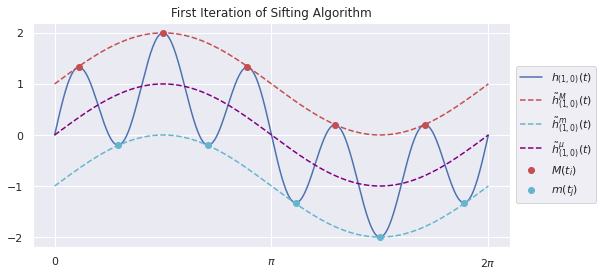

In [3]:
fig = plt.figure(figsize=(9, 4))
ax = plt.subplot(111)
plt.gcf().subplots_adjust(bottom=0.10)
plt.title('First Iteration of Sifting Algorithm')
plt.plot(pseudo_alg_time, pseudo_alg_time_series, label=r'$h_{(1,0)}(t)$', zorder=1)
plt.scatter(pseudo_alg_time[pseudo_utils.max_bool_func_1st_order_fd()],
            pseudo_alg_time_series[pseudo_utils.max_bool_func_1st_order_fd()],
            c='r', label=r'$M(t_i)$', zorder=2)
plt.plot(pseudo_alg_time, np.sin(pseudo_alg_time) + 1, '--', c='r', label=r'$\tilde{h}_{(1,0)}^M(t)$', zorder=4)
plt.scatter(pseudo_alg_time[pseudo_utils.min_bool_func_1st_order_fd()],
            pseudo_alg_time_series[pseudo_utils.min_bool_func_1st_order_fd()],
            c='c', label=r'$m(t_j)$', zorder=3)
plt.plot(pseudo_alg_time, np.sin(pseudo_alg_time) - 1, '--', c='c', label=r'$\tilde{h}_{(1,0)}^m(t)$', zorder=5)
plt.plot(pseudo_alg_time, np.sin(pseudo_alg_time), '--', c='purple', label=r'$\tilde{h}_{(1,0)}^{\mu}(t)$', zorder=5)
plt.yticks(ticks=[-2, -1, 0, 1, 2])
plt.xticks(ticks=[0, np.pi, 2 * np.pi],
           labels=[r'0', r'$\pi$', r'$2\pi$'])
box_0 = ax.get_position()
ax.set_position([box_0.x0 - 0.05, box_0.y0, box_0.width * 0.95, box_0.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Figure 1: Figure demonstrating first iteration of Algorithm 1 where extrema are found, splines
are fitted through maxima and minima respectively to form an envelope, and the local mean
is estimated as the average of the extrema splines.

The first iteration of the iterative sifting algorithm outlined in Algorithm 1 is demonstrated in Figure 1 for clarity. In Figure 1 $ h_{(1,0)}(t) $ is the first potential candidate for IMF 1, $ \tilde{h}^M_{(1,0)}(t) $ is a spline through the maxima, $ \tilde{h}^m_{(1,0)}(t) $ is a spline through the minima, $ \tilde{h}^{\mu}_{(1,0)}(t) $ is the average of the maxima spline and the minima spline, $ M(t_i) $ is the maxima of $ h_{(1,0)}(t) $, and $ m(t_j) $ is the minima of $ h_{(1,0)}(t) $.

![](./AdvEMDpy_paper_notebook_images/Algorithm.png)

# 6. Core Details of AdvEMDpy Package

In this section, the details of each of the components of **AdvEMDpy** package are outlined both in how to interact with the package through specific functionalities and what expectations one should have on outputs created and features that can be customised.

## 6.1. Base Implementation of AdvEMDpy Package

Before discussing the nuances of the algorithmic variations, one would benefit from somechoice remarks concerning non-essential, but helpful outputs of theAdvEMDpypackage.These play no direct part in the implementation of the algorithm but assist in iterative under-standing and assessment of the EMD decompositions performance. The base implementationof the algorithm may be seen below. More detailed descriptions may be found in the associatedscripts as well as a base implementation in the associatedREADME.mdfile.

\# instantiate EMD class with time (optional keyword argument) and time series

emd = EMD(time=time, time_series=time_series)

\# base implementation with optional helpful inputs shown

\# knots and knot_time are optional keyword arguments

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,knot_time=knot_time,debug=False,dft='envelopes',verbose=True,stopping_criterion='sd',output_coefficients=False,output_knots=False)

The details of each field in the input to the function is detailed in the following subsections.If time is not specified as a keyword argument, then the following code is implemented wheretime is simply an index set of the same length as the original time series.

self.time = np.arange(len(self.time_series))

If the knot sequence or the associated knot time are also unspecified keyword arguments,then the following code is implemented that sets knot time equal to time and spaces theknots10times further apart than the time points. This is problematic if the default knotsequence is insufficient to capture the highest frequency structures which is demonstrated innew_user.ipynb.knots = np.linspace(0, self.time[-1], int(len(self.time) / 10 + 1))knot_time = self.timeThe only required argument is the time series. This is detailed further in new_user.ipynb which is intended for new users to get comfortable with the package and the available options.

### Debug flag in AdvEMDpy Package 

If true, each iteration of the local mean estimation through the chosen detrended mean thresh-old technique will be plotted for analysis. The debugging output displayed depends on thechoice ofdft. If dft=‘envelopes’(base implementation), the extrema, the extrema envelopes, and the calculated local mean will be plotted.  If dft=‘inflection_points’theextrema, inflection points and the associated spline fitted through the inflection points willbe displayed. Ifdft=‘binomial_average’the extrema, the points used for the binomial average, the binomial average of these points, and the associated spline fitted will be displayed.Finally, ifdft=‘enhanced’, the extrema, the optimal ’extrema’, the associated splines, andthe resulting local mean are displayed.

### Verbose flag in AdvEMDpy Package
If true, each iteration of the algorithm will output text describing if the stopping crite-
rion chosen or the mean threshold is met. The intermediate numbering of the potential 
IMFs is output for consistency and the iteration counter is printed if the maximum num-
ber of iterations is met. Different text is displayed for each of the optional stopping cri-
teria. If, for example, stopping_criterion=‘sd’ then the text displayed for the fifth
candidate for the second IMF, should the IMF candidate not meet the stopping criterion,
will be IMF_25 Standard deviation STOPPING CRITERION NOT MET with sd = 1000.0 or
it will be IMF_25 Standard deviation STOPPING CRITERION MET with sd = 0.05 < sd
threshold = 0.1 with the stopping criterion threshold being another possible input such
as stopping_criterion_threshold=0.1, if the stopping criterion condition is met. For
stopping_criterion_threshold, a value of 0.2 − 0.3 is recommended in the paper that orig-
inally proposed the method, Huang et al. (1998). This value should be time series dependent
as the value is very much dependent on the level of noise in the time series as well as the
number of time points available, but more on this (and other stopping criteria) in Section 6.5.

### Output Coefficients flag in AdvEMDpy Package
If output_coefficients=True, cubic B-spline coefficients corresponding to each IMF output
(including initial smoothed time series and trend) are output. One must remember the six
additional coefficients corresponding to the three additional knots on either edge of the time
series as demonstrated in Figure 2. These additional bases result in implicit smoothing
through a non-natural spline which does not tend to zero at the edges in both position and
the higher-order derivatives. It would be unnecessarily restrictive to impose a natural spline
on the sifting algorithm and the resulting IMFs.

# Figure 2

In [4]:
knots = np.arange(12)
time = np.linspace(0, 11, 1101)
basis = emd_basis.Basis(time=time, time_series=time)
b_spline_basis = basis.cubic_b_spline(knots)
chsi_basis = basis.chsi_basis(knots)

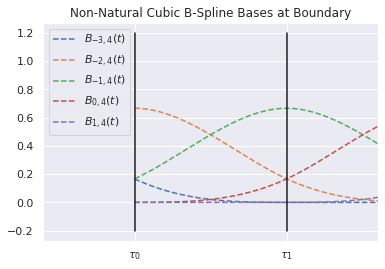

In [5]:
plt.title('Non-Natural Cubic B-Spline Bases at Boundary')
plt.plot(time[500:], b_spline_basis[2, 500:].T, '--', label=r'$ B_{-3,4}(t) $')
plt.plot(time[500:], b_spline_basis[3, 500:].T, '--', label=r'$ B_{-2,4}(t) $')
plt.plot(time[500:], b_spline_basis[4, 500:].T, '--', label=r'$ B_{-1,4}(t) $')
plt.plot(time[500:], b_spline_basis[5, 500:].T, '--', label=r'$ B_{0,4}(t) $')
plt.plot(time[500:], b_spline_basis[6, 500:].T, '--', label=r'$ B_{1,4}(t) $')
plt.xticks([5, 6], [r'$ \tau_0 $', r'$ \tau_1 $'])
plt.xlim(4.4, 6.6)
plt.plot(5 * np.ones(100), np.linspace(-0.2, 1.2, 100), 'k-')
plt.plot(6 * np.ones(100), np.linspace(-0.2, 1.2, 100), 'k-')
plt.legend(loc='upper left')
plt.rcParams['figure.figsize'] = [15, 12]
plt.show()

Figure 2: Figure demonstrating incomplete bases at the boundary of the time series to create
non-natural cubic B-splines that can accommodate non-zero edge values, derivatives, and
curvatures.

### Output Knots flag in AdvEMDpy Package
If output_knots=True, knot points are output. If knot points are not optimised, that is
if optimise_knots=0, then original knot points are repeated at each iteration of the sifting
procedure when extracting recursively each IMF. In other words, all IMF’s will have the same
knot sequence. If the user provides a uniform knot sequence and chooses not to optimise the
knot locations, then a uniform knot sequence will be used throughout as demonstrated in
Figure 3.

Alternatively, one can optimize the knots on an original spline (optimise_knots=1) represen-
tation of the input time series signal using optimal knot placement methodology as outlined
in Section 6.8 where two options are available using simple bisection and serial bisection, but
more about this will follow in the dedicated section. In this way the knot points will still be
universal for all IMF’s however, they will be optimized for the given signal input and will not
dynamically adjust as the residuals become increasingly less complex. For this reason, this
can be referred to as the statically optimised knots and an example demonstrating this can be
seen in Figure 4 where the optimised non-uniform knots can be seen to be used throughout
the algorithm despite the decreasing complexity.

In addition, one could also optimize the knot points per iteration (optimise_knots=2) of the
EMD sifting procedure once extracting an IMF, the next iteration of EMD on the residual
signal could first have the knot point optimisation performed when fitting the spline to the
residual to proceed with the next rounds of sifting to extract the next IMF. This results
in different numbers of knot points per IMF and different placements, in general one would
expect to require far fewer knots for later IMFs extracted which have lower frequency content
compared to those first few IMF bases extracted. An example demonstrating this can be
seen in Figure 5 where there are far fewer non-uniform knots for the second IMF than was
required for the first IMF.
Performing the third option may increase the speed of the algorithm if a large number of
siftings need to take place and a large number of IMFs need to be extracted, despite the added
time required to find the optimised knots at each stage. Progressively fewer knots will be
required throughout the algorithm with the added advantage of having a more parsimonious
representation with fewer parameters required for higher-order IMFs which have guaranteed
reducing oscillation in their representation.

# Figure 3

In [6]:
knot_demonstrate_time = np.linspace(0, 2 * np.pi, 1001)
knot_demonstrate_time_series = np.sin(knot_demonstrate_time) + np.sin(5 * knot_demonstrate_time)
knots_uniform = np.linspace(0, 2 * np.pi, 51)
emd = EMD(time=knot_demonstrate_time, time_series=knot_demonstrate_time_series)
imfs = emd.empirical_mode_decomposition(knots=knots_uniform, edge_effect='anti-symmetric')[0]

IMF_11 ALL IMF CONDITIONS MET
IMF_21 TREND CONDITION MET with fewer than 3 extrema and global mean removed
IMF_22 ALL IMF CONDITIONS MET


/home/cole/miniconda3/envs/advemdpy/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """
/home/cole/miniconda3/envs/advemdpy/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # Remove the CWD from sys.path while we load stuff.
/home/cole/miniconda3/envs/advemdpy/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  from ipykernel import kernelapp as app


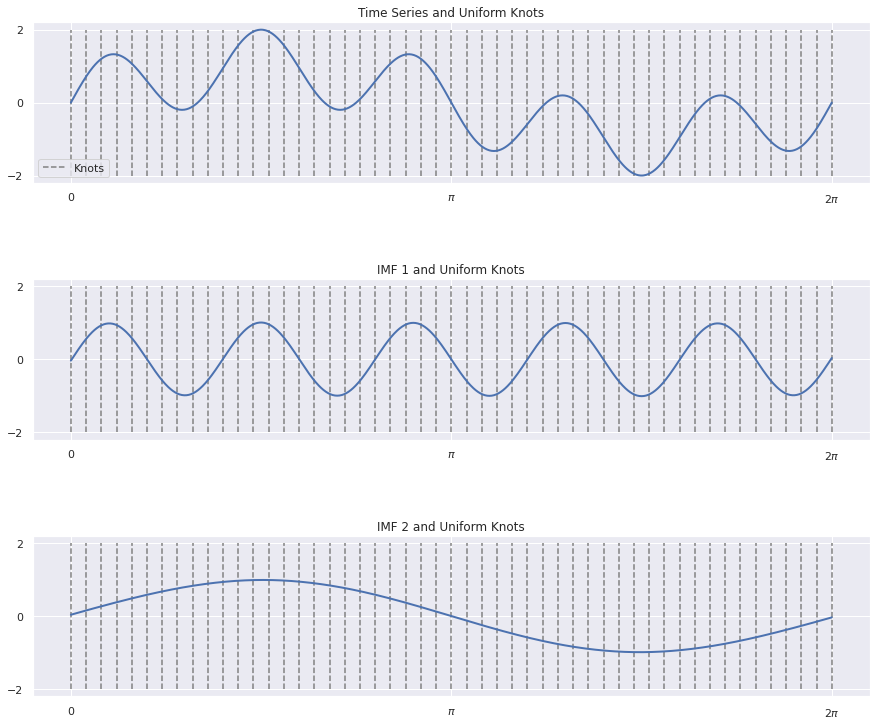

In [7]:
fig, axs = plt.subplots(3, 1)
fig.subplots_adjust(hspace=0.6)
plt.gcf().subplots_adjust(bottom=0.10)
axs[0].set_title('Time Series and Uniform Knots')
axs[0].plot(knot_demonstrate_time, knot_demonstrate_time_series, Linewidth=2, zorder=100)
axs[0].set_yticks(ticks=[-2, 0, 2])
axs[0].set_xticks(ticks=[0, np.pi, 2 * np.pi])
axs[0].set_xticklabels(labels=['0', r'$\pi$', r'$2\pi$'])
axs[1].set_title('IMF 1 and Uniform Knots')
axs[1].plot(knot_demonstrate_time, imfs[1, :], Linewidth=2, zorder=100)
axs[1].set_yticks(ticks=[-2, 0, 2])
axs[1].set_xticks(ticks=[0, np.pi, 2 * np.pi])
axs[1].set_xticklabels(labels=['0', r'$\pi$', r'$2\pi$'])
axs[2].set_title('IMF 2 and Uniform Knots')
axs[2].plot(knot_demonstrate_time, imfs[2, :], Linewidth=2, zorder=100)
axs[2].set_yticks(ticks=[-2, 0, 2])
axs[2].set_xticks(ticks=[0, np.pi, 2 * np.pi])
axs[2].set_xticklabels(labels=['0', r'$\pi$', r'$2\pi$'])
axs[0].plot(knots_uniform[0] * np.ones(101), np.linspace(-2, 2, 101), '--', c='grey', label='Knots')
axs[0].legend(loc='lower left')
axs[1].plot(knots_uniform[0] * np.ones(101), np.linspace(-2, 2, 101), '--', c='grey', label='Knots')
axs[2].plot(knots_uniform[0] * np.ones(101), np.linspace(-2, 2, 101), '--', c='grey', label='Knots')
for i in range(3):
    for j in range(1, len(knots_uniform)):
        axs[i].plot(knots_uniform[j] * np.ones(101), np.linspace(-2, 2, 101), '--', c='grey')
plt.show()

Figure 3: Figure demonstrating predefined uniform knot placement and the resulting IMFs.

# Figure 4

In [8]:
knot_demonstrate_time = np.linspace(0, 2 * np.pi, 1001)
knot_demonstrate_time_series = np.sin(knot_demonstrate_time) + np.sin(5 * knot_demonstrate_time)
emd = EMD(time=knot_demonstrate_time, time_series=knot_demonstrate_time_series)
imfs, _, _, _, knots, _, _ = emd.empirical_mode_decomposition(edge_effect='anti-symmetric', optimise_knots=1)

IMF_11 Standard deviation STOPPING CRITERION NOT MET with sd = 424363.89
IMF_12 ALL IMF CONDITIONS MET
IMF_21 ALL IMF CONDITIONS MET


/home/cole/miniconda3/envs/advemdpy/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """
/home/cole/miniconda3/envs/advemdpy/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # Remove the CWD from sys.path while we load stuff.
/home/cole/miniconda3/envs/advemdpy/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  from ipykernel import kernelapp as app


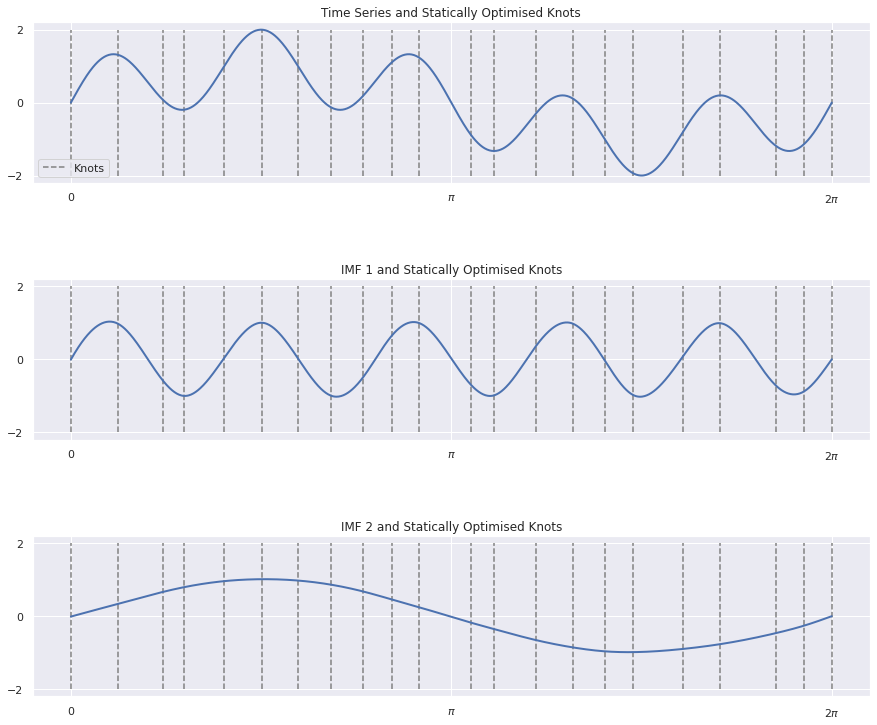

In [9]:
fig, axs = plt.subplots(3, 1)
fig.subplots_adjust(hspace=0.6)
plt.gcf().subplots_adjust(bottom=0.10)
axs[0].set_title('Time Series and Statically Optimised Knots')
axs[0].plot(knot_demonstrate_time, knot_demonstrate_time_series, Linewidth=2, zorder=100)
axs[0].set_yticks(ticks=[-2, 0, 2])
axs[0].set_xticks(ticks=[0, np.pi, 2 * np.pi])
axs[0].set_xticklabels(labels=['0', r'$\pi$', r'$2\pi$'])
axs[1].set_title('IMF 1 and Statically Optimised Knots')
axs[1].plot(knot_demonstrate_time, imfs[1, :], Linewidth=2, zorder=100)
axs[1].set_yticks(ticks=[-2, 0, 2])
axs[1].set_xticks(ticks=[0, np.pi, 2 * np.pi])
axs[1].set_xticklabels(labels=['0', r'$\pi$', r'$2\pi$'])
axs[2].set_title('IMF 2 and Statically Optimised Knots')
axs[2].plot(knot_demonstrate_time, imfs[2, :], Linewidth=2, zorder=100)
axs[2].set_yticks(ticks=[-2, 0, 2])
axs[2].set_xticks(ticks=[0, np.pi, 2 * np.pi])
axs[2].set_xticklabels(labels=['0', r'$\pi$', r'$2\pi$'])
axs[0].plot(knots[0] * np.ones(101), np.linspace(-2, 2, 101), '--', c='grey', label='Knots')
axs[0].legend(loc='lower left')
axs[1].plot(knots[0] * np.ones(101), np.linspace(-2, 2, 101), '--', c='grey', label='Knots')
axs[2].plot(knots[0] * np.ones(101), np.linspace(-2, 2, 101), '--', c='grey', label='Knots')
for i in range(3):
    for j in range(1, len(knots)):
        axs[i].plot(knots[j] * np.ones(101), np.linspace(-2, 2, 101), '--', c='grey')
plt.show()

Figure 4: Figure demonstrating statically optimised knot placement, which is optimised once
at outset and used throughout the sifting, and the resulting IMFs.

# Figure 5

In [10]:
knot_demonstrate_time = np.linspace(0, 2 * np.pi, 1001)
knot_demonstrate_time_series = np.sin(knot_demonstrate_time) + np.sin(5 * knot_demonstrate_time)
emd = EMD(time=knot_demonstrate_time, time_series=knot_demonstrate_time_series)
imfs, _, _, _, knots, _, _ = emd.empirical_mode_decomposition(edge_effect='anti-symmetric', optimise_knots=2)

IMF_11 Standard deviation STOPPING CRITERION NOT MET with sd = 424363.89
IMF_12 ALL IMF CONDITIONS MET
IMF_21 TREND CONDITION MET with fewer than 3 extrema and global mean removed
IMF_22 ALL IMF CONDITIONS MET


/home/cole/miniconda3/envs/advemdpy/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """
/home/cole/miniconda3/envs/advemdpy/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # Remove the CWD from sys.path while we load stuff.
/home/cole/miniconda3/envs/advemdpy/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  from ipykernel import kernelapp as app


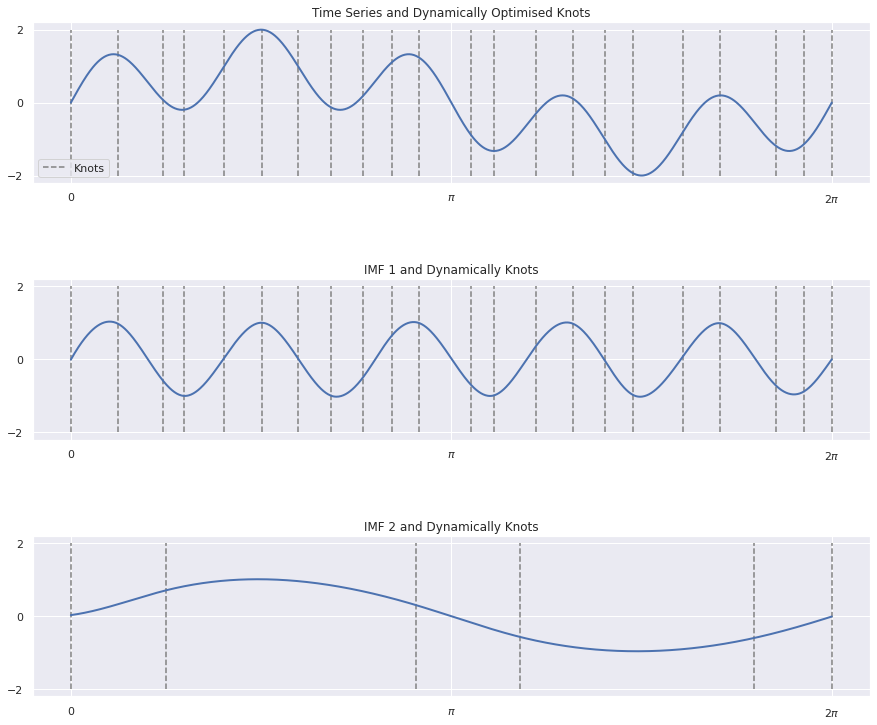

In [11]:
fig, axs = plt.subplots(3, 1)
fig.subplots_adjust(hspace=0.6)
plt.gcf().subplots_adjust(bottom=0.10)
axs[0].set_title('Time Series and Dynamically Optimised Knots')
axs[0].plot(knot_demonstrate_time, knot_demonstrate_time_series, Linewidth=2, zorder=100)
axs[0].set_yticks(ticks=[-2, 0, 2])
axs[0].set_xticks(ticks=[0, np.pi, 2 * np.pi])
axs[0].set_xticklabels(labels=['0', r'$\pi$', r'$2\pi$'])
axs[1].set_title('IMF 1 and Dynamically Knots')
axs[1].plot(knot_demonstrate_time, imfs[1, :], Linewidth=2, zorder=100)
axs[1].set_yticks(ticks=[-2, 0, 2])
axs[1].set_xticks(ticks=[0, np.pi, 2 * np.pi])
axs[1].set_xticklabels(labels=['0', r'$\pi$', r'$2\pi$'])
axs[2].set_title('IMF 2 and Dynamically Knots')
axs[2].plot(knot_demonstrate_time, imfs[2, :], Linewidth=2, zorder=100)
axs[2].set_yticks(ticks=[-2, 0, 2])
axs[2].set_xticks(ticks=[0, np.pi, 2 * np.pi])
axs[2].set_xticklabels(labels=['0', r'$\pi$', r'$2\pi$'])
axs[0].plot(knots[0][0] * np.ones(101), np.linspace(-2, 2, 101), '--', c='grey', label='Knots')
axs[0].legend(loc='lower left')
axs[1].plot(knots[1][0] * np.ones(101), np.linspace(-2, 2, 101), '--', c='grey', label='Knots')
axs[2].plot(knots[2][0] * np.ones(101), np.linspace(-2, 2, 101), '--', c='grey', label='Knots')
for i in range(3):
    for j in range(1, len(knots[i])):
        axs[i].plot(knots[i][j] * np.ones(101), np.linspace(-2, 2, 101), '--', c='grey')
plt.show()

Figure 5: Figure demonstrating dynamically optimised knot placement, which is optimised
at the beginning of each internal sifting routine, and the resulting IMFs.

### Recommendations for Base Implementation of AdvEMDpy Package
For the initial application of the algorithm to the desired time series, it is recommended that
the user display the results of the selected stopping criterion (verbose=True) and run to
completion. The user can then inspect the outputs and should anything be irregular or if the
user wants to observe each iterative step of the algorithm one can use debug=True which will
cause the method to plot each iteration of the algorithm.

\# recommended initial base implementation

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,
knot_time=knot_time,
debug=True,
verbose=True)

## 6.2. Preprocessing flag in AdvEMDpy Package

The raw time series signals that can be passed to the EMD package may contain a wide variety
of structures. This could include different non-linear structures, non-stationarity features in
trend, volatility etc. as well as corruption by observation noise that may be present in the
collection of the data. Therefore, in the AdvEMDpy package there is the option to pre-
process the time series data input to reduce the effect of these features if they may be adverse
to the user’s analysis. This is particularly the case in the context of signals observed in various
noise environments.
Therefore, before the sifting algorithm is implemented, there are several choices available for
the pre-processing of the raw time series. This was a necessary inclusion in the algorithm owing
to the wide variety of time series and their potentially vastly different statistical characteristics
that would need to be accommodated in the EMD basis decomposition. These preprocessing
techniques may be broadly grouped into filtering and smoothing. The filtering methods
developed out of a necessity to mitigate the corruption of the IMFs that would otherwise
arise as a result of the permeation of error that would occur due to the presence in the input 
time series signal of noise corruptions such as heavy-tailed noise, mixed noise (Gaussian noise
with different variances), and Poisson noise. Smoothing developed out of the broader field
of trend extraction amongst cyclical components where within EMD defining an individual
cyclical component amongst others and within a non-stationary setting becomes increasingly
challenging. The base implementation is as follows:

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,
knot_time=knot_time,
initial_smoothing=True,
preprocess='none',
preprocess_window_length=51,
preprocess_quantile=0.9,
preprocess_penalty=1,
preprocess_order=13,
preprocess_norm_1=2,
preprocess_norm_2=1,
downsample_window='hamming',
downsample_decimation_factor=20,
downsample_window_factor=20)

The following subsections will outline the different functionalities these flags provide in the
pre-processing options that users can select in the AdvEMDpy package.

### Filtering

Filtering uses a localising window to filter extrema out of the time series before the sifting pro-
cedure is performed. The preprocessing window length must be an odd integer as the window
centres on a particular time point and calculates the new preprocessed time series accordingly.
As an example, if preprocess=‘median_filter’ and preprocess_window_length=51, the
central time series point is replaced with the median of the 51 time series points. All fil-
tering techniques are displayed in Figure 6 for quick reference with quantile filters used by
Winsorization filtering included assisting with understanding.

#### Mean Filter

Each point in the time series is replaced with the mean to mitigate the effects
of outliers (preprocess=‘mean_filter’) over the specified window width centred on the
specific point. This is extremely susceptible to outliers and is therefore far less robust than
the other filters, but is included for classical usage and completeness-sake.

#### Median Filter

Each point in the time series is replaced with the median of the points
over the specified window width (preprocess=‘median_filter’). This technique is far less
susceptible to outliers with it forming the most basic technique in a toolbox of robust statistics.

#### Winsorization

Both this method and the one below are based on the ground-breaking work
by Hastings Jr., Mosteller, Tukey, and Winsor (1947). A local quantile window is created for
every point such that extreme values are restricted by making them equal to the boundary
values (preprocess=‘winsorize’). Should the point be above the maximum quantile it is
replaced with the maximum quantile value at that point and if it is below the minimum
quantile it is replaced with the minimum quantile value at that point. This is a slightly
more complex robust statistical technique in that it will leave the majority of the time series
untouched and simply restrict the extreme values. The level of the boundary is controlled
with preprocess_quantile=0.9 - this would result in the maximum boundary being such
that 95% of the time series within the window is below the maximum boundary and 5% of
the time series within the window is below minimum boundary - i.e. 90% of the time series
is within the boundaries.

#### Winsorization Interpolation

As above, a local quantile window is created for every point,
except the extreme values are treated in a slightly different manner than being made equal
to the boundary values (preprocess=‘winsorize_interpolate’). All the points above or
below the quantile windows are removed and they are linearly interpolated - this further
removes extremes from the time series.

# Figure 6

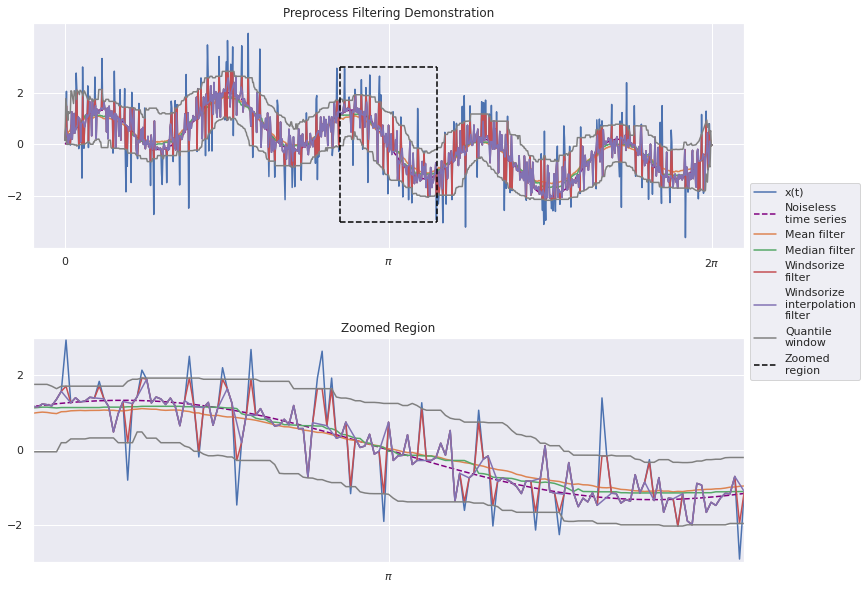

In [12]:
window = 81
fig, axs = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.4)
figure_size = plt.gcf().get_size_inches()
factor = 0.8
plt.gcf().set_size_inches((figure_size[0], factor * figure_size[1]))
plt.gcf().subplots_adjust(bottom=0.10)
axs[0].set_title('Preprocess Filtering Demonstration')
axs[1].set_title('Zoomed Region')
preprocess_time = pseudo_alg_time.copy()
np.random.seed(1)
random.seed(1)
preprocess_time_series = pseudo_alg_time_series + np.random.normal(0, 0.1, len(preprocess_time))
for i in random.sample(range(1000), 500):
    preprocess_time_series[i] += np.random.normal(0, 1)
preprocess = Preprocess(time=preprocess_time, time_series=preprocess_time_series)
axs[0].plot(preprocess_time, preprocess_time_series, label='x(t)')
axs[0].plot(pseudo_alg_time, pseudo_alg_time_series, '--', c='purple',
            label=textwrap.fill('Noiseless time series', 12))
axs[0].plot(preprocess_time, preprocess.mean_filter(window_width=window)[1], label=textwrap.fill('Mean filter', 12))
axs[0].plot(preprocess_time, preprocess.median_filter(window_width=window)[1], label=textwrap.fill('Median filter', 13))
axs[0].plot(preprocess_time, preprocess.winsorize(window_width=window, a=0.8)[1], label=textwrap.fill('Windsorize filter', 12))
axs[0].plot(preprocess_time, preprocess.winsorize_interpolate(window_width=window, a=0.8)[1],
            label=textwrap.fill('Windsorize interpolation filter', 14))
axs[0].plot(preprocess_time, preprocess.quantile_filter(window_width=window, q=0.90)[1], c='grey',
            label=textwrap.fill('Quantile window', 12))
axs[0].plot(preprocess_time, preprocess.quantile_filter(window_width=window, q=0.10)[1], c='grey')

axs[0].plot(np.linspace(0.85 * np.pi, 1.15 * np.pi, 101), -3 * np.ones(101), '--', c='black',
            label=textwrap.fill('Zoomed region', 10))
axs[0].plot(np.linspace(0.85 * np.pi, 1.15 * np.pi, 101), 3 * np.ones(101), '--', c='black')
axs[0].plot(0.85 * np.pi * np.ones(101), np.linspace(-3, 3, 101), '--', c='black')
axs[0].plot(1.15 * np.pi * np.ones(101), np.linspace(-3, 3, 101), '--', c='black')

axs[0].set_yticks(ticks=[-2, 0, 2])
axs[0].set_xticks(ticks=[0, np.pi, 2 * np.pi])
axs[0].set_xticklabels(labels=['0', r'$\pi$', r'$2\pi$'])
axs[1].plot(preprocess_time, preprocess_time_series, label='x(t)')
axs[1].plot(pseudo_alg_time, pseudo_alg_time_series, '--', c='purple', label=textwrap.fill('Noiseless time series', 12))
axs[1].plot(preprocess_time, preprocess.mean_filter(window_width=window)[1], label=textwrap.fill('Mean filter', 12))
axs[1].plot(preprocess_time, preprocess.median_filter(window_width=window)[1], label=textwrap.fill('Median filter', 13))
axs[1].plot(preprocess_time, preprocess.winsorize(window_width=window, a=0.8)[1], label=textwrap.fill('Windsorize filter', 12))
axs[1].plot(preprocess_time, preprocess.winsorize_interpolate(window_width=window, a=0.8)[1],
            label=textwrap.fill('Windsorize interpolation filter', 14))
axs[1].plot(preprocess_time, preprocess.quantile_filter(window_width=window, q=0.90)[1], c='grey',
            label=textwrap.fill('Quantile window', 12))
axs[1].plot(preprocess_time, preprocess.quantile_filter(window_width=window, q=0.10)[1], c='grey')
axs[1].set_xlim(0.85 * np.pi, 1.15 * np.pi)
axs[1].set_ylim(-3, 3)
axs[1].set_yticks(ticks=[-2, 0, 2])
axs[1].set_xticks(ticks=[np.pi])
axs[1].set_xticklabels(labels=[r'$\pi$'])
box_0 = axs[0].get_position()
axs[0].set_position([box_0.x0 - 0.05, box_0.y0, box_0.width * 0.85, box_0.height])
axs[0].legend(loc='center left', bbox_to_anchor=(1, -0.15))
box_1 = axs[1].get_position()
axs[1].set_position([box_1.x0 - 0.05, box_1.y0, box_1.width * 0.85, box_1.height])
plt.show()

Figure 6: Figure demonstrating family of filtering methods available to the user with quantile
envelope included for clarifying Winsorization calculation.

### Smoothing

Rather than explicitly limiting the effects of extrema by filtering the original time series,
one can fit a smoothing spline directly to the time series that implicitly limits the effect of
extrema, whilst simultaneously removing less extreme noise present in the time series. The
smoothing preprocessing options are displayed in Figure 7 where both an undecimated and
decimated downsampled time series is shown.

#### Smoothing

If an initial smoothing (initial_smoothing=True) is not done, then the first
IMF extracted will not be explainable in terms of cubic B-spline coefficients. It will mostly
consist of random noise in the system with little-to-no physical significance as corroborated
by numerous papers. This smoothing is implemented separately from other preprocessing
techniques to allow smoothing to be performed on a time series once some preprocessing
has been done. A natural example promoting this necessity would be a time series with
mixed-noise.

#### Generalised Hodrick-Prescott

This is a generalised form of Hodrick-Prescott filtering
(preprocess=‘HP’), introduced in Hodrick and Prescott (1997), but in this context it is
classified under smoothing:

\begin{equation}
    min_{z}\Bigg(\sum_{t=0}^{T}(y_t - z_t)^{n_1} + \lambda\sum_{t=0}^{T-d}(\nabla^d{z_t})^{n_2}\Bigg),
\end{equation}

where in the original Hodrick-Prescott filter assumes values $ n_1 = 2 $ (\code{preprocess_norm_1=2}), $ n_2 = 2 $ (\code{preprocess_norm_2=1}), the penalty term $ \lambda = 1 $ (\code{preprocess_penalty=1}) was not originally present, and $ d = 2 $ (\code{preprocess_order=2}) is the order of differencing with $ \nabla $ being the differencing function such that $ \nabla{z_t} = z_{t+1} - z_t $, $ \nabla^2{z_t} = \nabla(z_{t+1} - z_t) =  z_{t+2} - 2z_{t+1} + z_t $, and so forth.

#### Henderson-Whittaker Graduation

The well-known classical Whittaker-Henderson grad-
uation method (preprocess=‘HW’), introduced in Henderson (1916), Whittaker (1922), and
Henderson (1924), uses appropriately chosen window widths and weights to graduate the time
series to approximate a cubic spline. This may also be generalised to a higher or lower order of
smoothing with appropriately chosen constraints (such as in Equation (24) and Equation (25)
below for a cubic spline). In the interest of being able to generalise, the classical Henderson-
Whitaker weighting parameters are derived using the following objective function with the
order, d, being such that D = d + 6:

\begin{equation} \label{HW_objective}
     min_{\omega}\Bigg(\sum_{t=0}^{D-4}(\nabla^3{\omega_t})^2\Bigg),
\end{equation}

subject to the constraints:

\begin{equation} \label{HW_constraints}
\begin{split}
    \sum_{t=0}^{D-1}{\omega_t} = 1,\text{ }\sum_{t=0}^{D-1}{\Bigg(t - \frac{D-1}{2}\Bigg)^2\omega_t} = 0,\text{ }\sum_{t=0}^{D-1}{\Bigg(t - \frac{D-1}{2}\Bigg)\omega_t} = 0,\\
    \omega_0 = 0,\text{ }\omega_1 = 0,\text{ }\omega_2 = 0,\text{ }\omega_{D-3} = 0,\text{ }\omega_{D-2} = 0,\text{ and }\omega_{D-1} = 0,
\end{split}
\end{equation}

with the final cubic spline inducing weighting parameters then being the appropriately chosen subset $ \{\omega_3, \dots, \omega_{D-4}\} $. The derivation of the asymmetric weights at the edges of the timesseries have been researched extensively by Musgrave (1964b), Musgrave (1964a), Dagum andBianconcini (2006), Bianconcini (2006), and Dagum and Bianconcini (2008). This problem isrelated to the present issue of dealing with the edges discussed in Section 6.3. This problemgoes back much further as evidenced by De Forest (1877).

#### Downsampling

Certain time series may benefit from varying degrees of downsampling(preprocess=‘downsample’orpreprocess=‘downsample_decimate’). Downsampling andthe associated process of decimation are thoroughly reviewed in Crochiere and Rabiner (1983).This process involves two separate, but related transforms. The first transform uses a nor-malised sinc filter augmented with an appropriate windowing or tapering function - the mostcommon of which are Hamming and Hann windows - to downsample or truncate the frequencycontent of the time series. A sinc function is an idealised filter that removes all frequency con-tent above a certain frequency, but since this sinc function is tapered using a Hamming windowor a Hann window, it is merely a close approximation of this idealised filter. Once the fre-quency content has been truncated, the time series should undergo a decimation step where anappropriate subset of the time series can be sampled (preprocess=‘downsample_decimate’)to reflect the lower frequency content of the downsampled time series. In the smoothing con-text, to keep the lengths of the time series consistent with the original unpreprocessed timeseries, it is advised to perform only the downsampling (preprocess=‘downsample’).Having incorporated downsampling as a preprocessing technique into EMD, CompressiveSampling, introduced in Candès, Romberg, and Tao (2006), Candès (2006), and Candèsand Wakin (2008), should also be integrated into EMD to better isolate IMFs from sparselysampled time series. This technique relies on the time series being sparse in some domain, suchas the frequency domain. A simple sinusoid is exceptionally sparse in the frequency domain,where it is represented as two Dirac functions at both the appropriate negative and positivefrequencies. EMD would most certainly benefit from the integration of Compressive Sampling.The sparsity problem becomes more complicated when the IMFs are amplitude and frequencymodulated. This technique is called Compressive Sampling Empirical Mode Decomposition(CSEMD) where amplitude and frequency modulated waves are translated into a sparsedomain to fit sparsely sampled time series from which IMFs can be extracted using EMD.This technique is experimental and is included with the package inemd_experimental.py for completeness sake.

# Figure 7

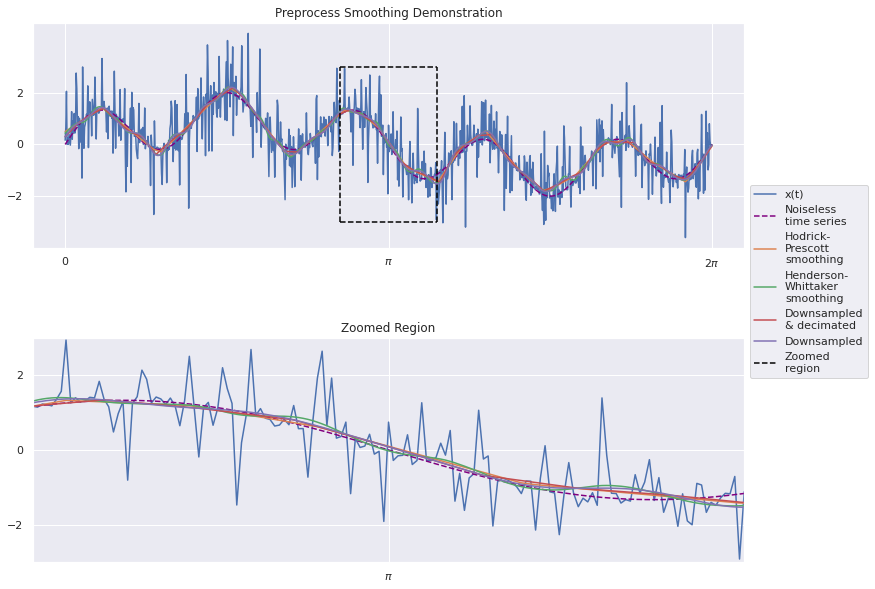

In [13]:
fig, axs = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.4)
figure_size = plt.gcf().get_size_inches()
factor = 0.8
plt.gcf().set_size_inches((figure_size[0], factor * figure_size[1]))
plt.gcf().subplots_adjust(bottom=0.10)
axs[0].set_title('Preprocess Smoothing Demonstration')
axs[1].set_title('Zoomed Region')
axs[0].plot(preprocess_time, preprocess_time_series, label='x(t)')
axs[0].plot(pseudo_alg_time, pseudo_alg_time_series, '--', c='purple',
            label=textwrap.fill('Noiseless time series', 12))
axs[0].plot(preprocess_time, preprocess.hp()[1],
            label=textwrap.fill('Hodrick-Prescott smoothing', 12))
axs[0].plot(preprocess_time, preprocess.hw(order=51)[1],
            label=textwrap.fill('Henderson-Whittaker smoothing', 13))
downsampled_and_decimated = preprocess.downsample()
axs[0].plot(downsampled_and_decimated[0], downsampled_and_decimated[1],
            label=textwrap.fill('Downsampled & decimated', 11))
downsampled = preprocess.downsample(decimate=False)
axs[0].plot(downsampled[0], downsampled[1],
            label=textwrap.fill('Downsampled', 13))
axs[0].plot(np.linspace(0.85 * np.pi, 1.15 * np.pi, 101), -3 * np.ones(101), '--', c='black',
            label=textwrap.fill('Zoomed region', 10))
axs[0].plot(np.linspace(0.85 * np.pi, 1.15 * np.pi, 101), 3 * np.ones(101), '--', c='black')
axs[0].plot(0.85 * np.pi * np.ones(101), np.linspace(-3, 3, 101), '--', c='black')
axs[0].plot(1.15 * np.pi * np.ones(101), np.linspace(-3, 3, 101), '--', c='black')
axs[0].set_yticks(ticks=[-2, 0, 2])
axs[0].set_xticks(ticks=[0, np.pi, 2 * np.pi])
axs[0].set_xticklabels(labels=['0', r'$\pi$', r'$2\pi$'])
axs[1].plot(preprocess_time, preprocess_time_series, label='x(t)')
axs[1].plot(pseudo_alg_time, pseudo_alg_time_series, '--', c='purple',
            label=textwrap.fill('Noiseless time series', 12))
axs[1].plot(preprocess_time, preprocess.hp()[1],
            label=textwrap.fill('Hodrick-Prescott smoothing', 12))
axs[1].plot(preprocess_time, preprocess.hw(order=51)[1],
            label=textwrap.fill('Henderson-Whittaker smoothing', 13))
axs[1].plot(downsampled_and_decimated[0], downsampled_and_decimated[1],
            label=textwrap.fill('Downsampled & decimated', 13))
axs[1].plot(downsampled[0], downsampled[1],
            label=textwrap.fill('Downsampled', 13))
axs[1].set_xlim(0.85 * np.pi, 1.15 * np.pi)
axs[1].set_ylim(-3, 3)
axs[1].set_yticks(ticks=[-2, 0, 2])
axs[1].set_xticks(ticks=[np.pi])
axs[1].set_xticklabels(labels=[r'$\pi$'])
box_0 = axs[0].get_position()
axs[0].set_position([box_0.x0 - 0.06, box_0.y0, box_0.width * 0.85, box_0.height])
axs[0].legend(loc='center left', bbox_to_anchor=(1, -0.15))
box_1 = axs[1].get_position()
axs[1].set_position([box_1.x0 - 0.06, box_1.y0, box_1.width * 0.85, box_1.height])
plt.show()

Figure 7: Figure demonstrating family of smoothing methods available to the user with both
decimated and undecimated downsampling being displayed.

### Recommendations for Preprocessing flag in AdvEMDpy Package

The preprocessing required depends upon the level of noise present in the time series andis very time series and process dependent. There is no preprocessing to suit all time series,but the most robust version of preprocessing would be median filtering the noise out ofthe time series (preprocess=‘median_filter’with an appropriate window length.  Thewindow length is dependent upon the highest frequency present in the time series and thesampling rate. Following the median filter, the user should then perform an initial smoothing(initial_smoothing=True) to remove the discontinuities introduced by the median filter.

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,knot_time=knot_time,initial_smoothing=True,preprocess='median_filter',preprocess_window_length=51)

## 6.3. Edge Effects in AdvEMDpy Package

The most prevalent challenge in EMD is the propagation of errors throughout the IMF and
the permeation of the errors throughout the sifting process. Owing to the iterative nature
of the algorithm, incorrectly estimated edge leads to errors being ubiquitous throughout all
the IMFs. There are several techniques used to estimate the extrema beyond the edges of
the signal - this AdvEMDpy package attempts to give the reader as many reasonable and
researched options as possible. The base implementation of the edge effects code is as follows:

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,
knot_time=knot_time,
edge_effect='symmetric',
sym_alpha=0.1,
nn_m=200,
nn_k=100,
nn_method='grad_descent',
nn_learning_rate=0.01,
nn_iter=100).

### Symmetric Methods

Without loss of generality, the procedure will be explained for the right edge maxima of thesignal. Figure 8 demonstrates examples of the three possible symmetric edge effects. In noparticular order, the technique demonstrated in Rilling, Flandrin, and Goncalves (2003) andWu and Qu (2008) is referred to in this paper as the Symmetric Discard technique owing tothe discarding of the end of time series in the new extrema approximation.

#### Symmetric Discard

In Figure 8 below, an implementation of the Symmetric Discard technique (edge_effect='symmetric_discard') maxima is shown with a purple dot. The end of the time series between the last blue dot and the orange dot is disregarded when approximating the next extreme. Taking the last maxima value, $ X(t^{max}_M) $, the associated time point, $ t^{max}_M $, the last minima value, $ X(t^{min}_m) $, and the associated time point, $ t^{min}_m $, the next extreme is calculated as:

\begin{equation}
	X(t^{max}_{M+1}) = X(t^{max}_M),
\end{equation}

with the associated time point being calculated as:

\begin{equation}
	t^{max}_{M+1} = t^{min}_{m} + (t^{min}_{m} - t^{max}_{M}).
\end{equation}

#### Symmetric Anchor

In Figure 8 below, an implementation of the Symmetric Anchor tech-nique (edge_effect=‘symmetric_anchor’) maxima is shown with an orange dot. In Zhaoand Huang (2001) and Zeng and He (2004) the technique creates an extreme at the endpoint - this is why this technique is referred to in this paper as the Symmetric Anchor technique. In this paper, this technique has been generalised to conditionally create an extreme depending on the difference in vertical displacement between the last two extrema and the difference in vertical displacement between the last extrema and the end of the signal - this can be referred to as the Conditional Symmetric Anchor technique. The Conditional Symmetric Anchor is calculated as follows - if $ \beta{L} \geq (1 - \alpha)L $ where $ \beta $ is the ratio of the vertical height between the last extrema and the end of the time series to the vertical height between the last two extrema, $ L $ is the vertical height between the last two extrema, and $ \alpha $ (sym_alpha=0.1) is the significance level input, then:

\begin{equation}
	X(t^{max}_{M+1}) = X(t_N),
\end{equation}

with the associated time point being calculated as:

\begin{equation}
	t^{max}_{M+1} = t_N.
\end{equation}

The above is the method followed (without conditions) in Zhao and Huang (2001) and Zengand He (2004)). If, however, $ \beta{L} < (1 - \alpha)L $, then:

\begin{equation}
X(t^{max}_{M+1}) = X(t^{max}_M),
\end{equation}

with the associated time point being calculated as:

\begin{equation}
t^{max}_{M+1} = t_N + (t_N - t^{max}_{M}).
\end{equation}

The Conditional Symmetric Anchor technique collapses to the Symmetric Anchor technique when $ \alpha = 1 $. The other extreme where $ \alpha = -\infty $ leads to the following method.

#### Symmetric

The Symmetric technique (\code{edge_effect='symmetric'}) does not anchor the extrema envelope to the ends of the signal under any condition and is equivalent to the Conditional Symmetric Anchor technique where $ \alpha = -\infty $. The values are calculated as follows:

\begin{equation}
X(t^{max}_{M+1}) = X(t^{max}_M),
\end{equation}

with the associated time point being calculated as:

\begin{equation}
t^{max}_{M+1} = t_N + (t_N - t^{max}_{M}).
\end{equation}

This point is denoted with a gray dot in Figure 8.

#### Anti-Symmetric

The Anti-Symmetric (edge_effect=‘anti-symmetric’) approach re-flects the uni-variate signal about both axes - the approximated maximum will be the reflectedminimum. It is formally calculated as:

\begin{equation}
X(t^{max}_{M+1}) = X(t_N) + (X(t_N) - X(t^{min}_m)),
\end{equation}

with the associated time point being calculated as:

\begin{equation}
t^{max}_{M+1} = t_N + (t_N - t^{min}_{m}).
\end{equation}

This point is denoted with a green dot in Figure 8. This technique is a more practical variationof that proposed in Zeng and He (2004), where the points are reflected about the axis rather than about the endpoints.

# Figure 8

In [14]:
a = 0.25
width = 0.2
time = np.linspace(0, (5 - a) * np.pi, 1001)
time_series = np.cos(time) + np.cos(5 * time)
utils = emd_utils.Utility(time=time, time_series=time_series)
max_bool = utils.max_bool_func_1st_order_fd()
maxima_x = time[max_bool]
maxima_y = time_series[max_bool]
min_bool = utils.min_bool_func_1st_order_fd()
minima_x = time[min_bool]
minima_y = time_series[min_bool]
max_dash_time = np.linspace(maxima_x[-1] - width, maxima_x[-1] + width, 101)
max_dash = maxima_y[-1] * np.ones_like(max_dash_time)
min_dash_time = np.linspace(minima_x[-1] - width, minima_x[-1] + width, 101)
min_dash = minima_y[-1] * np.ones_like(min_dash_time)
dash_1_time = np.linspace(maxima_x[-1], minima_x[-1], 101)
dash_1 = np.linspace(maxima_y[-1], minima_y[-1], 101)
max_discard = maxima_y[-1]
max_discard_time = minima_x[-1] - maxima_x[-1] + minima_x[-1]
max_discard_dash_time = np.linspace(max_discard_time - width, max_discard_time + width, 101)
max_discard_dash = max_discard * np.ones_like(max_discard_dash_time)
dash_2_time = np.linspace(minima_x[-1], max_discard_time, 101)
dash_2 = np.linspace(minima_y[-1], max_discard, 101)
end_point_time = time[-1]
end_point = time_series[-1]
time_reflect = np.linspace((5 - a) * np.pi, (5 + a) * np.pi, 101)
time_series_reflect = np.flip(np.cos(np.linspace((5 - 2.6 * a) * np.pi, (5 - a) * np.pi, 101)) + np.cos(5 * np.linspace((5 - 2.6 * a) * np.pi, (5 - a) * np.pi, 101)))
time_series_anti_reflect = time_series_reflect[0] - time_series_reflect
utils = emd_utils.Utility(time=time, time_series=time_series_anti_reflect)
anti_max_bool = utils.max_bool_func_1st_order_fd()
anti_max_point_time = time_reflect[anti_max_bool]
anti_max_point = time_series_anti_reflect[anti_max_bool]
utils = emd_utils.Utility(time=time, time_series=time_series_reflect)
no_anchor_max_time = time_reflect[utils.max_bool_func_1st_order_fd()]
no_anchor_max = time_series_reflect[utils.max_bool_func_1st_order_fd()]
point_1 = 5.4
length_distance = np.linspace(maxima_y[-1], minima_y[-1], 101)
length_distance_time = point_1 * np.pi * np.ones_like(length_distance)
length_time = np.linspace(point_1 * np.pi - width, point_1 * np.pi + width, 101)
length_top = maxima_y[-1] * np.ones_like(length_time)
length_bottom = minima_y[-1] * np.ones_like(length_time)
point_2 = 5.2
length_distance_2 = np.linspace(time_series[-1], minima_y[-1], 101)
length_distance_time_2 = point_2 * np.pi * np.ones_like(length_distance_2)
length_time_2 = np.linspace(point_2 * np.pi - width, point_2 * np.pi + width, 101)
length_top_2 = time_series[-1] * np.ones_like(length_time_2)
length_bottom_2 = minima_y[-1] * np.ones_like(length_time_2)
symmetry_axis_1_time = minima_x[-1] * np.ones(101)
symmetry_axis_2_time = time[-1] * np.ones(101)
symmetry_axis = np.linspace(-2, 2, 101)
end_time = np.linspace(time[-1] - width, time[-1] + width, 101)
end_signal = time_series[-1] * np.ones_like(end_time)
anti_symmetric_time = np.linspace(time[-1] - 0.5, time[-1] + 0.5, 101)
anti_symmetric_signal = time_series[-1] * np.ones_like(anti_symmetric_time)

/home/cole/miniconda3/envs/advemdpy/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cole/miniconda3/envs/advemdpy/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """
/home/cole/miniconda3/envs/advemdpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  


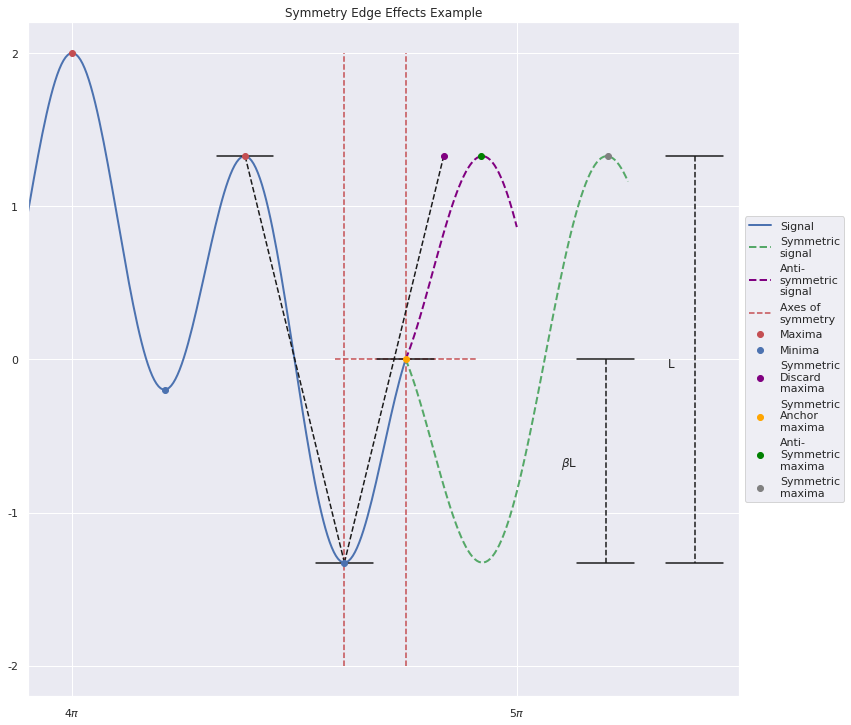

In [15]:
ax = plt.subplot(111)
plt.gcf().subplots_adjust(bottom=0.10)
plt.plot(time, time_series, LineWidth=2, label='Signal')
plt.title('Symmetry Edge Effects Example')
plt.plot(time_reflect, time_series_reflect, 'g--', LineWidth=2, label=textwrap.fill('Symmetric signal', 10))
plt.plot(time_reflect[:51], time_series_anti_reflect[:51], '--', c='purple', LineWidth=2, label=textwrap.fill('Anti-symmetric signal', 10))
plt.plot(max_dash_time, max_dash, 'k-')
plt.plot(min_dash_time, min_dash, 'k-')
plt.plot(dash_1_time, dash_1, 'k--')
plt.plot(dash_2_time, dash_2, 'k--')
plt.plot(length_distance_time, length_distance, 'k--')
plt.plot(length_distance_time_2, length_distance_2, 'k--')
plt.plot(length_time, length_top, 'k-')
plt.plot(length_time, length_bottom, 'k-')
plt.plot(length_time_2, length_top_2, 'k-')
plt.plot(length_time_2, length_bottom_2, 'k-')
plt.plot(end_time, end_signal, 'k-')
plt.plot(symmetry_axis_1_time, symmetry_axis, 'r--', zorder=1)
plt.plot(anti_symmetric_time, anti_symmetric_signal, 'r--', zorder=1)
plt.plot(symmetry_axis_2_time, symmetry_axis, 'r--', label=textwrap.fill('Axes of symmetry', 10), zorder=1)
plt.text(5.1 * np.pi, -0.7, r'$\beta$L')
plt.text(5.34 * np.pi, -0.05, 'L')
plt.scatter(maxima_x, maxima_y, c='r', zorder=4, label='Maxima')
plt.scatter(minima_x, minima_y, c='b', zorder=4, label='Minima')
plt.scatter(max_discard_time, max_discard, c='purple', zorder=4, label=textwrap.fill('Symmetric Discard maxima', 10))
plt.scatter(end_point_time, end_point, c='orange', zorder=4, label=textwrap.fill('Symmetric Anchor maxima', 10))
plt.scatter(anti_max_point_time, anti_max_point, c='green', zorder=4, label=textwrap.fill('Anti-Symmetric maxima', 10))
plt.scatter(no_anchor_max_time, no_anchor_max, c='gray', zorder=4, label=textwrap.fill('Symmetric maxima', 10))
plt.xlim(3.9 * np.pi, 5.5 * np.pi)
plt.xticks((4 * np.pi, 5 * np.pi), (r'4$\pi$', r'5$\pi$'))
plt.yticks((-2, -1, 0, 1, 2), ('-2', '-1', '0', '1', '2'))
box_0 = ax.get_position()
ax.set_position([box_0.x0 - 0.05, box_0.y0, box_0.width * 0.85, box_0.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Figure 8: Example time series demonstrating four (five if Conditional Symmetric Anchor isincluded) different symmetric edge effect techniques with axes of symmetry included.

### Slope-Based Methods

The slope-based methods offer a different approach to the edge effect problem. These methodsuse the calculated slopes and difference in temporal location between the extrema nearest tothe edges to approximate the subsequent slopes and temporal locations and therefore thelocation of the subsequent points.

#### Slope-Based

This technique (edge_effect=‘slope_based_method’), which relies on thefour nearest extrema, is introduced in Dätig and Schlurmann (2004). The slopes ($ s_1 $ and $ s_2 $) can be calculated as follows:

\begin{equation}
	s_1 = \frac{X(t^{max}_{M}) - X(t^{min}_{m-1})}{t^{max}_{M} - t^{min}_{m-1}},
\end{equation}

and

\begin{equation}
s_2 = \frac{X(t^{max}_{M}) - X(t^{min}_{m})}{t^{max}_{M} - t^{min}_{m}}.
\end{equation}

With $ \Delta{t^{max}_M} = t^{max}_M - t^{max}_{M-1} $, the slope-based maximum ($ X(t^{max}_{M+1}) $) is calculated as follows:

\begin{equation}
	t^{max}_{M+1} = t^{max}_{M} + \Delta{t^{max}_M},
\end{equation}

and

\begin{equation}
	X(t^{max}_{M+1}) = X(t^{min}_{m}) + s_1\times(t^{max}_{M+1} - t^{min}_{m}).
\end{equation}

With $ \Delta{t^{min}_m} = t^{min}_m - t^{min}_{m-1} $, the slope-based minimum ($ X(t^{min}_{m+1}) $) is calculated as follows:

\begin{equation}
t^{min}_{m+1} = t^{min}_{m} + \Delta{t^{min}_m},
\end{equation}

and

\begin{equation}
X(t^{min}_{m+1}) = X(t^{max}_{M+1}) + s_2\times(t^{min}_{m+1} - t^{max}_{M+1}).
\end{equation}

#### Improved Slope-Based

This (edge_effect=‘improved_slope_based_method’) is intro-duced in Wu and Qu (2008) as an improvement upon the slope-based method that takes into account the end of the signal and is therefore a conditional edge effect much like the Symmetric Anchor edge effect. With $ s_1 $, $ s_2 $, $ \Delta{t^{max}_M} $, $ \Delta{t^{min}_m} $, and $ X(t^{max}_{M+1}) $ defined as above the Improved Slope-Based maximum is calculated as follows: If $ X(t_N) < X(t^{max}_{M+1}) $, then proceed as in Slope-Based method, otherwise, set: 

\begin{equation}
	t^{max}_{M+1} = t_N,
\end{equation}

and

\begin{equation}
	X(t^{max}_{M+1}) = X(t_N).
\end{equation}

The Improved Slope-Based minimum is then calculated as:

\begin{equation}
t^{min}_{m+1} = t^{min}_{m} + \Delta{t^{min}_m},
\end{equation}

and

\begin{equation}
X(t^{min}_{m+1}) = X(t^{max}_{M+1}) + s_2\times(t^{min}_{m+1} - t^{max}_{M+1}).
\end{equation}

# Figure 9

In [16]:
a = 0.21
width = 0.2
time = np.linspace(0, (5 - a) * np.pi, 1001)
time_series = np.cos(time) + np.cos(5 * time)
utils = emd_utils.Utility(time=time, time_series=time_series)
max_bool = utils.max_bool_func_1st_order_fd()
maxima_x = time[max_bool]
maxima_y = time_series[max_bool]
min_bool = utils.min_bool_func_1st_order_fd()
minima_x = time[min_bool]
minima_y = time_series[min_bool]
max_dash_1 = np.linspace(maxima_y[-1] - width, maxima_y[-1] + width, 101)
max_dash_2 = np.linspace(maxima_y[-2] - width, maxima_y[-2] + width, 101)
max_dash_time_1 = maxima_x[-1] * np.ones_like(max_dash_1)
max_dash_time_2 = maxima_x[-2] * np.ones_like(max_dash_1)
min_dash_1 = np.linspace(minima_y[-1] - width, minima_y[-1] + width, 101)
min_dash_2 = np.linspace(minima_y[-2] - width, minima_y[-2] + width, 101)
min_dash_time_1 = minima_x[-1] * np.ones_like(min_dash_1)
min_dash_time_2 = minima_x[-2] * np.ones_like(min_dash_1)
dash_1_time = np.linspace(maxima_x[-1], minima_x[-1], 101)
dash_1 = np.linspace(maxima_y[-1], minima_y[-1], 101)
dash_2_time = np.linspace(maxima_x[-1], minima_x[-2], 101)
dash_2 = np.linspace(maxima_y[-1], minima_y[-2], 101)
s1 = (minima_y[-2] - maxima_y[-1]) / (minima_x[-2] - maxima_x[-1])
slope_based_maximum_time = maxima_x[-1] + (maxima_x[-1] - maxima_x[-2])
slope_based_maximum = minima_y[-1] + (slope_based_maximum_time - minima_x[-1]) * s1
max_dash_time_3 = slope_based_maximum_time * np.ones_like(max_dash_1)
max_dash_3 = np.linspace(slope_based_maximum - width, slope_based_maximum + width, 101)
dash_3_time = np.linspace(minima_x[-1], slope_based_maximum_time, 101)
dash_3 = np.linspace(minima_y[-1], slope_based_maximum, 101)
s2 = (minima_y[-1] - maxima_y[-1]) / (minima_x[-1] - maxima_x[-1])
slope_based_minimum_time = minima_x[-1] + (minima_x[-1] - minima_x[-2])
slope_based_minimum = slope_based_maximum - (slope_based_maximum_time - slope_based_minimum_time) * s2
min_dash_time_3 = slope_based_minimum_time * np.ones_like(min_dash_1)
min_dash_3 = np.linspace(slope_based_minimum - width, slope_based_minimum + width, 101)
dash_4_time = np.linspace(slope_based_maximum_time, slope_based_minimum_time)
dash_4 = np.linspace(slope_based_maximum, slope_based_minimum)
maxima_dash = np.linspace(2.5 - width, 2.5 + width, 101)
maxima_dash_time_1 = maxima_x[-2] * np.ones_like(maxima_dash)
maxima_dash_time_2 = maxima_x[-1] * np.ones_like(maxima_dash)
maxima_dash_time_3 = slope_based_maximum_time * np.ones_like(maxima_dash)
maxima_line_dash_time = np.linspace(maxima_x[-2], slope_based_maximum_time, 101)
maxima_line_dash = 2.5 * np.ones_like(maxima_line_dash_time)
minima_dash = np.linspace(-3.4 - width, -3.4 + width, 101)
minima_dash_time_1 = minima_x[-2] * np.ones_like(minima_dash)
minima_dash_time_2 = minima_x[-1] * np.ones_like(minima_dash)
minima_dash_time_3 = slope_based_minimum_time * np.ones_like(minima_dash)
minima_line_dash_time = np.linspace(minima_x[-2], slope_based_minimum_time, 101)
minima_line_dash = -3.4 * np.ones_like(minima_line_dash_time)

# slightly edit signal to make difference between slope-based method and improved slope-based method more clear

time_series[time >= minima_x[-1]] = 1.5 * (time_series[time >= minima_x[-1]] - time_series[time == minima_x[-1]]) + time_series[time == minima_x[-1]]
improved_slope_based_maximum_time = time[-1]
improved_slope_based_maximum = time_series[-1]
improved_slope_based_minimum_time = slope_based_minimum_time
improved_slope_based_minimum = improved_slope_based_maximum + s2 * (improved_slope_based_minimum_time - improved_slope_based_maximum_time)
min_dash_4 = np.linspace(improved_slope_based_minimum - width, improved_slope_based_minimum + width, 101)
min_dash_time_4 = improved_slope_based_minimum_time * np.ones_like(min_dash_4)
dash_final_time = np.linspace(improved_slope_based_maximum_time, improved_slope_based_minimum_time, 101)
dash_final = np.linspace(improved_slope_based_maximum, improved_slope_based_minimum, 101)

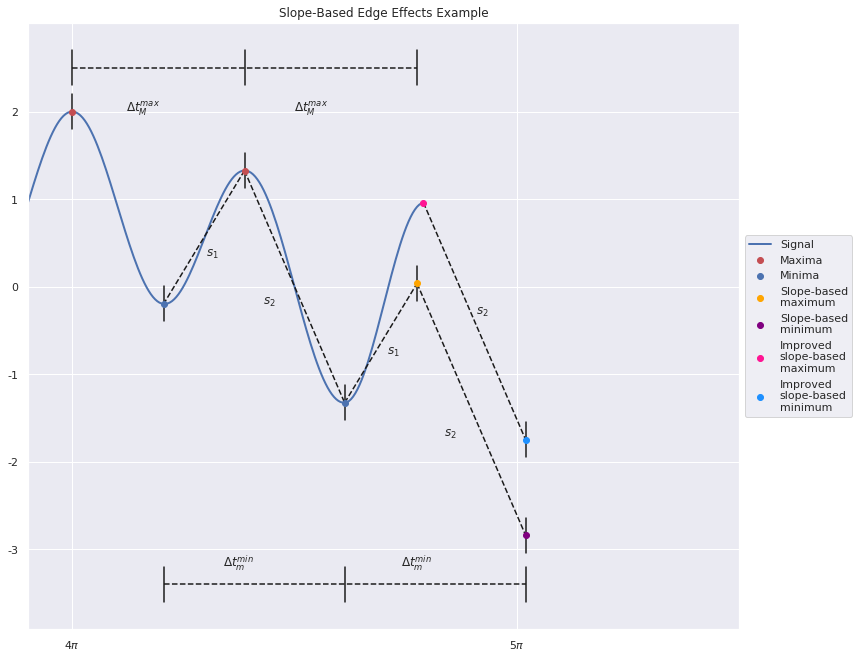

In [17]:
ax = plt.subplot(111)
figure_size = plt.gcf().get_size_inches()
factor = 0.9
plt.gcf().set_size_inches((figure_size[0], factor * figure_size[1]))
plt.gcf().subplots_adjust(bottom=0.10)
plt.plot(time, time_series, LineWidth=2, label='Signal')
plt.title('Slope-Based Edge Effects Example')
plt.plot(max_dash_time_1, max_dash_1, 'k-')
plt.plot(max_dash_time_2, max_dash_2, 'k-')
plt.plot(max_dash_time_3, max_dash_3, 'k-')
plt.plot(min_dash_time_1, min_dash_1, 'k-')
plt.plot(min_dash_time_2, min_dash_2, 'k-')
plt.plot(min_dash_time_3, min_dash_3, 'k-')
plt.plot(min_dash_time_4, min_dash_4, 'k-')
plt.plot(maxima_dash_time_1, maxima_dash, 'k-')
plt.plot(maxima_dash_time_2, maxima_dash, 'k-')
plt.plot(maxima_dash_time_3, maxima_dash, 'k-')
plt.plot(minima_dash_time_1, minima_dash, 'k-')
plt.plot(minima_dash_time_2, minima_dash, 'k-')
plt.plot(minima_dash_time_3, minima_dash, 'k-')
plt.text(4.34 * np.pi, -3.2, r'$\Delta{t^{min}_{m}}$')
plt.text(4.74 * np.pi, -3.2, r'$\Delta{t^{min}_{m}}$')
plt.text(4.12 * np.pi, 2, r'$\Delta{t^{max}_{M}}$')
plt.text(4.50 * np.pi, 2, r'$\Delta{t^{max}_{M}}$')
plt.text(4.30 * np.pi, 0.35, r'$s_1$')
plt.text(4.43 * np.pi, -0.20, r'$s_2$')
plt.text(4.30 * np.pi + (minima_x[-1] - minima_x[-2]), 0.35 + (minima_y[-1] - minima_y[-2]), r'$s_1$')
plt.text(4.43 * np.pi + (slope_based_minimum_time - minima_x[-1]), -0.20 + (slope_based_minimum - minima_y[-1]), r'$s_2$')
plt.text(4.50 * np.pi + (slope_based_minimum_time - minima_x[-1]), 1.20 + (slope_based_minimum - minima_y[-1]), r'$s_2$')
plt.plot(minima_line_dash_time, minima_line_dash, 'k--')
plt.plot(maxima_line_dash_time, maxima_line_dash, 'k--')
plt.plot(dash_1_time, dash_1, 'k--')
plt.plot(dash_2_time, dash_2, 'k--')
plt.plot(dash_3_time, dash_3, 'k--')
plt.plot(dash_4_time, dash_4, 'k--')
plt.plot(dash_final_time, dash_final, 'k--')
plt.scatter(maxima_x, maxima_y, c='r', zorder=4, label='Maxima')
plt.scatter(minima_x, minima_y, c='b', zorder=4, label='Minima')
plt.scatter(slope_based_maximum_time, slope_based_maximum, c='orange', zorder=4, label=textwrap.fill('Slope-based maximum', 11))
plt.scatter(slope_based_minimum_time, slope_based_minimum, c='purple', zorder=4, label=textwrap.fill('Slope-based minimum', 11))
plt.scatter(improved_slope_based_maximum_time, improved_slope_based_maximum, c='deeppink', zorder=4, label=textwrap.fill('Improved slope-based maximum', 11))
plt.scatter(improved_slope_based_minimum_time, improved_slope_based_minimum, c='dodgerblue', zorder=4, label=textwrap.fill('Improved slope-based minimum', 11))
plt.xlim(3.9 * np.pi, 5.5 * np.pi)
plt.xticks((4 * np.pi, 5 * np.pi), (r'4$\pi$', r'5$\pi$'))
plt.yticks((-3, -2, -1, 0, 1, 2), ('-3', '-2', '-1', '0', '1', '2'))
box_0 = ax.get_position()
ax.set_position([box_0.x0 - 0.05, box_0.y0, box_0.width * 0.85, box_0.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Figure 9: Example time series demonstrating two different slope-based edge effect techniques.

### Characteristic Wave Methods

This family of methods uses the extrema at the edge of the time series to estimate amplitudesand periods to approximate the next extrema using a sinusoidal wave. The original HuangCharacteristic Wave approach is discussed in Huanget al.(1998) and Wu and Qu (2008) -the Modified Huang Characteristic Wave method takes the trend of the edge implicitly intoaccount when approximating the next extrema. The Coughlin Characteristic Wave approachis discussed in Coughlin and Tung (2004) and Wu and Qu (2008) - this method uses only thelast two extrema and approximates the next extrema using a simple sinusoidal extension.

#### Modified Huang Characteristic Wave

The descriptions of the original technique inHuanget al.(1998) and Wu and Qu (2008) are very nebulous and are open to interpretation,but by reviewing Huanget al.(1998), Coughlin and Tung (2004), and Wu and Qu (2008) areasonable method (edge_effect=‘characteristic_wave_mod_Huang’) can be inferred andmodified with some confidence. By calculating $ p_2 = 2\times(t^{max}_{M-1} - t^{min}_{m-1}) $, $ p_1 = 2\times(t^{max}_{M} - t^{min}_{m}) $,  $ a_2 = \frac{(X(t^{max}_{M-1}) - X(t^{min}_{m-1}))}{2} $, and $ a_1 = \frac{(X(t^{max}_{M}) - X(t^{min}_{m}))}{2} $, as seen in Figure 10, the next maximum may be estimated as follows:

\begin{equation}
	t^{max}_{M+1} = t^{min}_{m} + \frac{p_1}{p_2}\times(t^{max}_{M} - t^{min}_{m-1}),
\end{equation}

and

\begin{equation}
	X(t^{max}_{M+1}) = X(t^{min}_{m}) + \frac{a_1}{a_2}\times(X(t^{max}_{M}) - X(t^{min}_{m-1})),
\end{equation}

with the next minimum being estimated as:

\begin{equation}
t^{min}_{m+1} = t^{max}_{M+1} + \frac{p_1}{p_2}\times(t^{min}_{m} - t^{max}_{M}),
\end{equation}

and

\begin{equation}
X(t^{min}_{m+1}) = X(t^{max}_{M+1}) + \frac{a_1}{a_2}\times(X(t^{min}_{m}) - X(t^{max}_{M})).
\end{equation}

#### Coughlin Characteristic Wave

The Coughlin Characteristic Wave is a less intensive tech-nique (edge_effect=‘characteristic_wave_Coughlin’) and only uses $ t^{max}_{M} $, $ t^{min}_{m} $, $ X(t^{max}_{M}) $, and $ X(t^{min}_{m}) $ - the last two extrema. This method disregards any trend in the structure of the edges, but is simpler to calculate. With $ a_1 $ and $ p_1 $ as before, the next maximum is calculated as follows:

\begin{equation}
t^{max}_{M+1} = t^{min}_{m} + \frac{p_1}{2},
\end{equation}

and

\begin{equation}
X(t^{max}_{M+1}) = X(t^{max}_{M}),
\end{equation}

with the next minimum being estimated as:

\begin{equation}
t^{min}_{m+1} = t^{max}_{M+1} + \frac{p_1}{2},
\end{equation}

and

\begin{equation}
X(t^{min}_{m+1}) = X(t^{min}_{m}).
\end{equation}

This is equivalent to a simple sinusoidal wave with amplitude $ a_1 $ and period $ p_1 $. The maximum derived in this manner is equivalent to the maximum derived using the Symmetric Discard technique, but this is where the equivalency ends as the minimums are significantly different.

#### Average Characteristic Wave

The Average Characteristic Wave plot is not includedin Figure 10 as there is no amplitude defined for either the maxima characteristic wave orthe minima characteristic wave, but the calculation of the maximum and minimum relyon the characteristic periods and extrema (and hence indirectly on the amplitude) andshould be included in this class of method. Unlike the other characteristic wave methods(edge_effect=‘average’), the Average Characteristic Wave method implicitly uses two sep-arate characteristic waves for the maximum and minimum calculation respectively - this canbe seen in the calculations below as the maximum calculation does not refer to the minimaand vice versa. This method is used in Chiew, Peel, Amirthanathan, and Pegram (2005).The average maximum is calculated as follows:

\begin{equation}
t^{max}_{M+1} = t^{max}_{M} + (t^{max}_{M} - t^{max}_{M-1}),
\end{equation}

and

\begin{equation}
X(t^{max}_{M+1}) = \frac{(X(t^{max}_{M}) + X(t^{max}_{M-1}))}{2},
\end{equation}

with the average minimum being calculated as follows:

\begin{equation}
t^{min}_{m+1} = t^{min}_{m} + (t^{min}_{m} - t^{min}_{m-1}),
\end{equation}

and

\begin{equation}
X(t^{min}_{m+1}) = \frac{(X(t^{min}_{m}) + X(t^{min}_{m-1}))}{2}.
\end{equation}

# Figure 10

In [18]:
a = 0.25
width = 0.2
time = np.linspace(0, (5 - a) * np.pi, 1001)
time_series = np.cos(time) + np.cos(5 * time)
utils = emd_utils.Utility(time=time, time_series=time_series)
max_bool = utils.max_bool_func_1st_order_fd()
maxima_x = time[max_bool]
maxima_y = time_series[max_bool]
min_bool = utils.min_bool_func_1st_order_fd()
minima_x = time[min_bool]
minima_y = time_series[min_bool]
A2 = np.abs(maxima_y[-2] - minima_y[-2]) / 2
A1 = np.abs(maxima_y[-1] - minima_y[-1]) / 2
P2 = 2 * np.abs(maxima_x[-2] - minima_x[-2])
P1 = 2 * np.abs(maxima_x[-1] - minima_x[-1])
Huang_time = (P1 / P2) * (time[time >= maxima_x[-2]] - time[time == maxima_x[-2]]) + maxima_x[-1]
Huang_wave = (A1 / A2) * (time_series[time >= maxima_x[-2]] - time_series[time == maxima_x[-2]]) + maxima_y[-1]
Coughlin_time = Huang_time
Coughlin_wave = A1 * np.cos(2 * np.pi * (1 / P1) * (Coughlin_time - Coughlin_time[0]))
Average_max_time = maxima_x[-1] + (maxima_x[-1] - maxima_x[-2])
Average_max = (maxima_y[-2] + maxima_y[-1]) / 2
Average_min_time = minima_x[-1] + (minima_x[-1] - minima_x[-2])
Average_min = (minima_y[-2] + minima_y[-1]) / 2
utils_Huang = emd_utils.Utility(time=time, time_series=Huang_wave)
Huang_max_bool = utils_Huang.max_bool_func_1st_order_fd()
Huang_min_bool = utils_Huang.min_bool_func_1st_order_fd()
utils_Coughlin = emd_utils.Utility(time=time, time_series=Coughlin_wave)
Coughlin_max_bool = utils_Coughlin.max_bool_func_1st_order_fd()
Coughlin_min_bool = utils_Coughlin.min_bool_func_1st_order_fd()
Huang_max_time = Huang_time[Huang_max_bool]
Huang_max = Huang_wave[Huang_max_bool]
Huang_min_time = Huang_time[Huang_min_bool]
Huang_min = Huang_wave[Huang_min_bool]
Coughlin_max_time = Coughlin_time[Coughlin_max_bool]
Coughlin_max = Coughlin_wave[Coughlin_max_bool]
Coughlin_min_time = Coughlin_time[Coughlin_min_bool]
Coughlin_min = Coughlin_wave[Coughlin_min_bool]
max_2_x_time = np.linspace(maxima_x[-2] - width, maxima_x[-2] + width, 101)
max_2_x_time_side = np.linspace(5.3 * np.pi - width, 5.3 * np.pi + width, 101)
max_2_x = maxima_y[-2] * np.ones_like(max_2_x_time)
min_2_x_time = np.linspace(minima_x[-2] - width, minima_x[-2] + width, 101)
min_2_x_time_side = np.linspace(5.3 * np.pi - width, 5.3 * np.pi + width, 101)
min_2_x = minima_y[-2] * np.ones_like(min_2_x_time)
dash_max_min_2_x = np.linspace(minima_y[-2], maxima_y[-2], 101)
dash_max_min_2_x_time = 5.3 * np.pi * np.ones_like(dash_max_min_2_x)
max_2_y = np.linspace(maxima_y[-2] - width, maxima_y[-2] + width, 101)
max_2_y_side = np.linspace(-1.8 - width, -1.8 + width, 101)
max_2_y_time = maxima_x[-2] * np.ones_like(max_2_y)
min_2_y = np.linspace(minima_y[-2] - width, minima_y[-2] + width, 101)
min_2_y_side = np.linspace(-1.8 - width, -1.8 + width, 101)
min_2_y_time = minima_x[-2] * np.ones_like(min_2_y)
dash_max_min_2_y_time = np.linspace(minima_x[-2], maxima_x[-2], 101)
dash_max_min_2_y = -1.8 * np.ones_like(dash_max_min_2_y_time)
max_1_x_time = np.linspace(maxima_x[-1] - width, maxima_x[-1] + width, 101)
max_1_x_time_side = np.linspace(5.4 * np.pi - width, 5.4 * np.pi + width, 101)
max_1_x = maxima_y[-1] * np.ones_like(max_1_x_time)
min_1_x_time = np.linspace(minima_x[-1] - width, minima_x[-1] + width, 101)
min_1_x_time_side = np.linspace(5.4 * np.pi - width, 5.4 * np.pi + width, 101)
min_1_x = minima_y[-1] * np.ones_like(min_1_x_time)
dash_max_min_1_x = np.linspace(minima_y[-1], maxima_y[-1], 101)
dash_max_min_1_x_time = 5.4 * np.pi * np.ones_like(dash_max_min_1_x)
max_1_y = np.linspace(maxima_y[-1] - width, maxima_y[-1] + width, 101)
max_1_y_side = np.linspace(-2.1 - width, -2.1 + width, 101)
max_1_y_time = maxima_x[-1] * np.ones_like(max_1_y)
min_1_y = np.linspace(minima_y[-1] - width, minima_y[-1] + width, 101)
min_1_y_side = np.linspace(-2.1 - width, -2.1 + width, 101)
min_1_y_time = minima_x[-1] * np.ones_like(min_1_y)
dash_max_min_1_y_time = np.linspace(minima_x[-1], maxima_x[-1], 101)
dash_max_min_1_y = -2.1 * np.ones_like(dash_max_min_1_y_time)

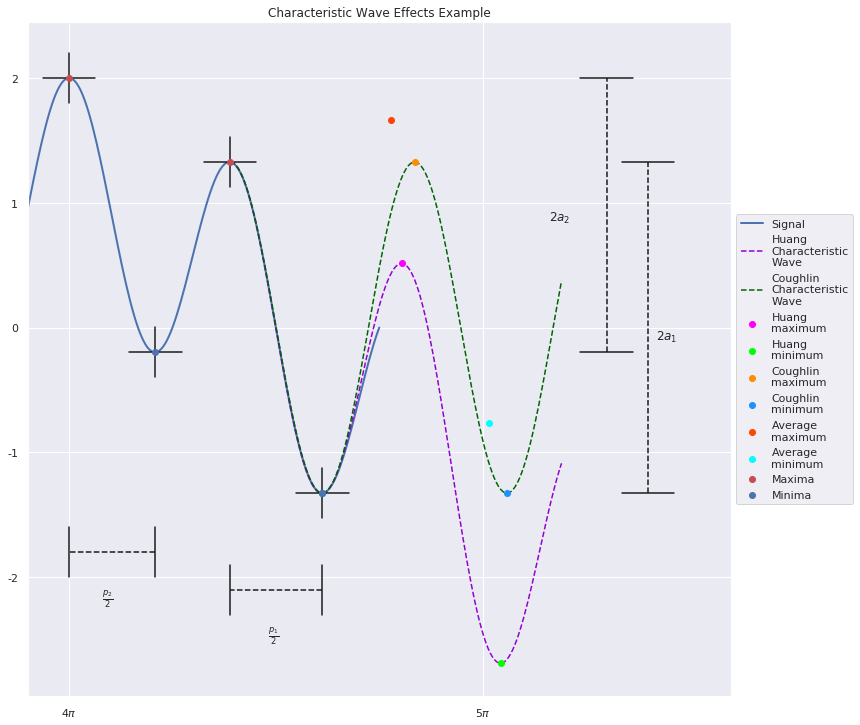

In [19]:
ax = plt.subplot(111)
plt.gcf().subplots_adjust(bottom=0.10)
plt.title('Characteristic Wave Effects Example')
plt.plot(time, time_series, LineWidth=2, label='Signal')
plt.scatter(Huang_max_time, Huang_max, c='magenta', zorder=4, label=textwrap.fill('Huang maximum', 10))
plt.scatter(Huang_min_time, Huang_min, c='lime', zorder=4, label=textwrap.fill('Huang minimum', 10))
plt.scatter(Coughlin_max_time, Coughlin_max, c='darkorange', zorder=4, label=textwrap.fill('Coughlin maximum', 14))
plt.scatter(Coughlin_min_time, Coughlin_min, c='dodgerblue', zorder=4, label=textwrap.fill('Coughlin minimum', 14))
plt.scatter(Average_max_time, Average_max, c='orangered', zorder=4, label=textwrap.fill('Average maximum', 14))
plt.scatter(Average_min_time, Average_min, c='cyan', zorder=4, label=textwrap.fill('Average minimum', 14))
plt.scatter(maxima_x, maxima_y, c='r', zorder=4, label='Maxima')
plt.scatter(minima_x, minima_y, c='b', zorder=4, label='Minima')
plt.plot(Huang_time, Huang_wave, '--', c='darkviolet', label=textwrap.fill('Huang Characteristic Wave', 14))
plt.plot(Coughlin_time, Coughlin_wave, '--', c='darkgreen', label=textwrap.fill('Coughlin Characteristic Wave', 14))
plt.plot(max_2_x_time, max_2_x, 'k-')
plt.plot(max_2_x_time_side, max_2_x, 'k-')
plt.plot(min_2_x_time, min_2_x, 'k-')
plt.plot(min_2_x_time_side, min_2_x, 'k-')
plt.plot(dash_max_min_2_x_time, dash_max_min_2_x, 'k--')
plt.text(5.16 * np.pi, 0.85, r'$2a_2$')
plt.plot(max_2_y_time, max_2_y, 'k-')
plt.plot(max_2_y_time, max_2_y_side, 'k-')
plt.plot(min_2_y_time, min_2_y, 'k-')
plt.plot(min_2_y_time, min_2_y_side, 'k-')
plt.plot(dash_max_min_2_y_time, dash_max_min_2_y, 'k--')
plt.text(4.08 * np.pi, -2.2, r'$\frac{p_2}{2}$')
plt.plot(max_1_x_time, max_1_x, 'k-')
plt.plot(max_1_x_time_side, max_1_x, 'k-')
plt.plot(min_1_x_time, min_1_x, 'k-')
plt.plot(min_1_x_time_side, min_1_x, 'k-')
plt.plot(dash_max_min_1_x_time, dash_max_min_1_x, 'k--')
plt.text(5.42 * np.pi, -0.1, r'$2a_1$')
plt.plot(max_1_y_time, max_1_y, 'k-')
plt.plot(max_1_y_time, max_1_y_side, 'k-')
plt.plot(min_1_y_time, min_1_y, 'k-')
plt.plot(min_1_y_time, min_1_y_side, 'k-')
plt.plot(dash_max_min_1_y_time, dash_max_min_1_y, 'k--')
plt.text(4.48 * np.pi, -2.5, r'$\frac{p_1}{2}$')
plt.xlim(3.9 * np.pi, 5.6 * np.pi)
plt.xticks((4 * np.pi, 5 * np.pi), (r'4$\pi$', r'5$\pi$'))
plt.yticks((-2, -1, 0, 1, 2), ('-2', '-1', '0', '1', '2'))
box_0 = ax.get_position()
ax.set_position([box_0.x0 - 0.05, box_0.y0, box_0.width * 0.84, box_0.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Figure 10: Example time series demonstrating three different characteristic wave edge effecttechniques with average characteristic waves excluded.

### Explicit Methods

All of the above edge effect techniques may be further sub-classified under implicit edgeeffect methods as the time series itself is not explicitly extrapolated to find the next extremafrom the extrapolated time series. Instead, only the nearest two or four extrema are usedto approximate where the next two will occur. Another approach is to explicitly extrapolatethe time series and extract the resulting extrema. Only one method in this family will beexplored, but there are many more.

#### Single Neuron Neural Network

The method (edge_effect=‘neural_network’) demon-strated here follows the work done in Deng, Wang, Qian, Wang, and Dai (2001). The objective function is:

\begin{equation} \label{neural_network}
    min_{\bar{w}}(\bar{w}P - \bar{y}),
\end{equation}

with

\begin{equation}
\bar{w} = 
\begin{bmatrix}
    w_1 & w_2 & \dots & w_k
\end{bmatrix},
\end{equation}

\begin{equation}
    P = 
\begin{bmatrix}
    y_{-(m+k)} & y_{-(m+k-1)} & \cdots & y_{-(k+1)}\\
    y_{-(m+k-1)} & y_{-(m+k-2)} & \cdots & y_{-(k)}\\
    \vdots & \vdots & \ddots & \vdots\\
    y_{-(m+1)} & y_{-m} & \cdots & y_{-2}
\end{bmatrix},
\end{equation}

and

\begin{equation}
    \bar{y} = 
\begin{bmatrix}
    y_{-m} & y_{-(m-1)} & \dots & y_{-1}
\end{bmatrix}.
\end{equation}

In the absence of an activation function or the use of the identity function as an activationfunction a single neuron neural network simply reduces to linear regression as can be seen inEquation (58). The naming convention is kept for consistency with the method proposed in Denget al.(2001). In this problem $k$ (nn_k=100) is the number of previous points (number of parameters) needed to estimate the next point in the time series and $m$ (nn_m=200) is the number of target outputs used to estimate the parameters. Two different techniques may be used to estimate $ \bar{w} $ - either gradient descent (nn_method='grad_descent') or steepest descent (nn_method='steep_descent'). The optimisation problem is arranged in the same manner for both techniques. The weights are initialised ($\bar{w_0}$), a learning rate is stipulated ($l$) (nn_learning_rate=0.01), and a fixed number of iterations is set (nn_iter=100). The algorithm proceeds as follows:

    w = w_0

for iter in iterations:

    y_0 = np.matmul(w, P)
    e = (y - y_0)
    grad = - e * P
    av_grad = np.mean(grad, axis=1)
    if method == 'gradient_descent':
        adj = - l * av_grad
    elif method == 'steepest_descent':
        max_grad = av_grad * (np.abs(av_grad) == max(np.abs(av_grad)))
        adj = - l * max_grad
    w += adj

The gradient descent optimisation method requires a lower learning rate than the steepest descent optimisation method as all the weights are optimised simultaneously in gradient descent in each iteration, whereas only a single weight is optimised in each iteration during steepest descent. Depending on the complexity of the time series, the weighting vector obtained using steepest descent may be very sparse and this could be desirable in certain situations.

# FIgure 11

In [20]:
t = np.linspace(5, 95, 100)
signal_orig = np.cos(2 * np.pi * t / 50) + 0.6 * np.cos(2 * np.pi * t / 25) + 0.5 * np.sin(2 * np.pi * t / 200)
util_nn = emd_utils.Utility(time=t, time_series=signal_orig)
maxima = signal_orig[util_nn.max_bool_func_1st_order_fd()]
minima = signal_orig[util_nn.min_bool_func_1st_order_fd()]
cs_max = CubicSpline(t[util_nn.max_bool_func_1st_order_fd()], maxima)
cs_min = CubicSpline(t[util_nn.min_bool_func_1st_order_fd()], minima)
time = np.linspace(0, 5 * np.pi, 1001)
lsq_signal = np.cos(time) + np.cos(5 * time)
knots = np.linspace(0, 5 * np.pi, 101)
time_extended = time_extension(time)
time_series_extended = np.zeros_like(time_extended) / 0
time_series_extended[int(len(lsq_signal) - 1):int(2 * (len(lsq_signal) - 1) + 1)] = lsq_signal
neural_network_m = 200
neural_network_k = 100

# forward ->

P = np.zeros((int(neural_network_k + 1), neural_network_m))
for col in range(neural_network_m):
    P[:-1, col] = lsq_signal[(-(neural_network_m + neural_network_k - col)):(-(neural_network_m - col))]
    P[-1, col] = 1  # for additive constant
t = lsq_signal[-neural_network_m:]
seed_weights = np.ones(neural_network_k) / neural_network_k
weights = 0 * seed_weights.copy()
train_input = P[:-1, :]
lr = 0.01

for iterations in range(1000):

    output = np.matmul(weights, train_input)
    error = (t - output)
    gradients = error * (- train_input)
    # guess average gradients
    average_gradients = np.mean(gradients, axis=1)
    # steepest descent
    max_gradient_vector = average_gradients * (np.abs(average_gradients) == max(np.abs(average_gradients)))
    adjustment = - lr * average_gradients
    # adjustment = - lr * max_gradient_vector
    weights += adjustment

weights_right = np.hstack((weights, 0))
max_count_right = 0
min_count_right = 0
i_right = 0

while ((max_count_right < 1) or (min_count_right < 1)) and (i_right < len(lsq_signal) - 1):

    time_series_extended[int(2 * (len(lsq_signal) - 1) + 1 + i_right)] = \
        sum(weights_right * np.hstack((time_series_extended[int(2 * (len(lsq_signal) - 1) + 1 - neural_network_k + i_right):int(2 * (len(lsq_signal) - 1) + 1 + i_right)], 1)))

    i_right += 1
    if i_right > 1:

        emd_utils_max = \
            emd_utils.Utility(time=time_extended[int(2 * (len(lsq_signal) - 1) + 1):int(2 * (len(lsq_signal) - 1) + 1 + i_right + 1)],
                              time_series=time_series_extended[int(2 * (len(lsq_signal) - 1) + 1):int(2 * (len(lsq_signal) - 1) + 1 + i_right + 1)])

        if sum(emd_utils_max.max_bool_func_1st_order_fd()) > 0:

            max_count_right += 1

        emd_utils_min = \
            emd_utils.Utility(time=time_extended[int(2 * (len(lsq_signal) - 1) + 1):int(2 * (len(lsq_signal) - 1) + 1 + i_right + 1)],
                              time_series=time_series_extended[int(2 * (len(lsq_signal) - 1) + 1):int(2 * (len(lsq_signal) - 1) + 1 + i_right + 1)])

        if sum(emd_utils_min.min_bool_func_1st_order_fd()) > 0:

            min_count_right += 1

# backward <-

P = np.zeros((int(neural_network_k + 1), neural_network_m))
for col in range(neural_network_m):
    P[:-1, col] = lsq_signal[int(col + 1):int(col + neural_network_k + 1)]
    P[-1, col] = 1  # for additive constant
t = lsq_signal[:neural_network_m]
vx = cvx.Variable(int(neural_network_k + 1))
objective = cvx.Minimize(cvx.norm((2 * (vx * P) + 1 - t), 2))  # linear activation function is arbitrary
prob = cvx.Problem(objective)
result = prob.solve(verbose=True, solver=cvx.ECOS)
weights_left = np.array(vx.value)
max_count_left = 0
min_count_left = 0
i_left = 0

while ((max_count_left < 1) or (min_count_left < 1)) and (i_left < len(lsq_signal) - 1):

    time_series_extended[int(len(lsq_signal) - 2 - i_left)] = \
        2 * sum(weights_left * np.hstack((time_series_extended[int(len(lsq_signal) - 1 - i_left):int(len(lsq_signal) - 1 - i_left + neural_network_k)],1))) + 1

    i_left += 1
    if i_left > 1:

        emd_utils_max = \
            emd_utils.Utility(time=time_extended[int(len(lsq_signal) - 1 - i_left):int(len(lsq_signal))],
                              time_series=time_series_extended[int(len(lsq_signal) - 1 - i_left):int(len(lsq_signal))])

        if sum(emd_utils_max.max_bool_func_1st_order_fd()) > 0:

            max_count_left += 1

        emd_utils_min = \
            emd_utils.Utility(time=time_extended[int(len(lsq_signal) - 1 - i_left):int(len(lsq_signal))],
                              time_series=time_series_extended[int(len(lsq_signal) - 1 - i_left):int(len(lsq_signal))])

        if sum(emd_utils_min.min_bool_func_1st_order_fd()) > 0:

            min_count_left += 1


lsq_utils = emd_utils.Utility(time=time, time_series=lsq_signal)
utils_extended = emd_utils.Utility(time=time_extended, time_series=time_series_extended)
maxima = lsq_signal[lsq_utils.max_bool_func_1st_order_fd()]
maxima_time = time[lsq_utils.max_bool_func_1st_order_fd()]
maxima_extrapolate = time_series_extended[utils_extended.max_bool_func_1st_order_fd()][-1]
maxima_extrapolate_time = time_extended[utils_extended.max_bool_func_1st_order_fd()][-1]
minima = lsq_signal[lsq_utils.min_bool_func_1st_order_fd()]
minima_time = time[lsq_utils.min_bool_func_1st_order_fd()]
minima_extrapolate = time_series_extended[utils_extended.min_bool_func_1st_order_fd()][-2:]
minima_extrapolate_time = time_extended[utils_extended.min_bool_func_1st_order_fd()][-2:]


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +4e+02  5e-01  5e-07  1e+00  2e+02    ---    ---    0  1  - |  -  - 
 1  -1.781e-02  +1.435e-15  +4e+00  1e-02  6e-09  3e-02  2e+00  0.9890  1e-04   2  1  1 |  0  0
 2  -3.933e-04  +3.175e-17  +4e-02  1e-04  7e-11  5e-04  2e-02  0.9890  1e-04   3  1  1 |  0  0
 3  -6.513e-06  +5.279e-19  +5e-04  1e-06  7e-13  8e-06  2e-04  0.9890  1e-04   1  1  1 |  0  0
 4  -9.587e-08  +7.772e-21  +5e-06  1e-08  8e-15  1e-07  3e-06  0.9890  1e-04   1  0  0 |  0  0
 5  -1.323e-09  +1.082e-22  +6e-08  2e-10  1e-16  1e-09  3e-08  0.9890  1e-04   1  0  0 |  0  0
 6  -1.753e-11  +1.472e-24  +7e-10  2e-12  9e-18  2e-11  3e-10  0.9890  1e-04   2  0  0 |  0  0

OPTIMAL (within feastol=1.8e-12, reltol=3.7e+01, abstol=6.5e-10).
Runtime: 0.016647 seconds.



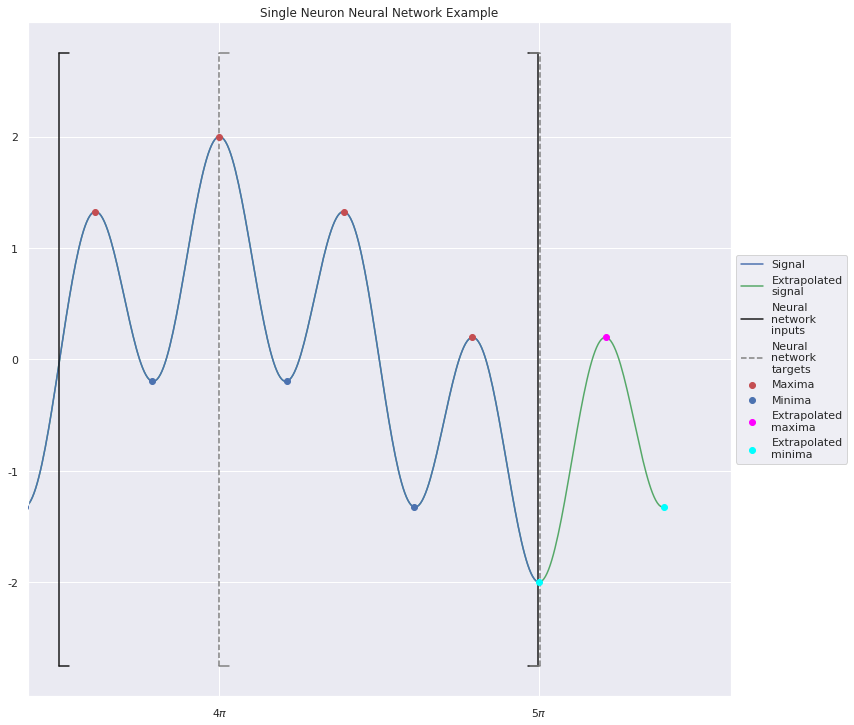

In [21]:
ax = plt.subplot(111)
plt.gcf().subplots_adjust(bottom=0.10)
plt.title('Single Neuron Neural Network Example')
plt.plot(time, lsq_signal, zorder=2, label='Signal')
plt.plot(time_extended, time_series_extended, c='g', zorder=1, label=textwrap.fill('Extrapolated signal', 12))
plt.scatter(maxima_time, maxima, c='r', zorder=3, label='Maxima')
plt.scatter(minima_time, minima, c='b', zorder=3, label='Minima')
plt.scatter(maxima_extrapolate_time, maxima_extrapolate, c='magenta', zorder=3, label=textwrap.fill('Extrapolated maxima', 12))
plt.scatter(minima_extrapolate_time, minima_extrapolate, c='cyan', zorder=4, label=textwrap.fill('Extrapolated minima', 12))
plt.plot(((time[-302] + time[-301]) / 2) * np.ones(100), np.linspace(-2.75, 2.75, 100), c='k', label=textwrap.fill('Neural network inputs', 13))
plt.plot(np.linspace(((time[-302] + time[-301]) / 2), ((time[-302] + time[-301]) / 2) + 0.1, 100), -2.75 * np.ones(100), c='k')
plt.plot(np.linspace(((time[-302] + time[-301]) / 2), ((time[-302] + time[-301]) / 2) + 0.1, 100), 2.75 * np.ones(100), c='k')
plt.plot(np.linspace(((time_extended[-1001] + time_extended[-1002]) / 2), ((time_extended[-1001] + time_extended[-1002]) / 2) - 0.1, 100), -2.75 * np.ones(100), c='k')
plt.plot(np.linspace(((time_extended[-1001] + time_extended[-1002]) / 2), ((time_extended[-1001] + time_extended[-1002]) / 2) - 0.1, 100), 2.75 * np.ones(100), c='k')
plt.plot(((time_extended[-1001] + time_extended[-1002]) / 2) * np.ones(100), np.linspace(-2.75, 2.75, 100), c='k')
plt.plot(((time[-202] + time[-201]) / 2) * np.ones(100), np.linspace(-2.75, 2.75, 100), c='gray', linestyle='dashed', label=textwrap.fill('Neural network targets', 13))
plt.plot(np.linspace(((time[-202] + time[-201]) / 2), ((time[-202] + time[-201]) / 2) + 0.1, 100), -2.75 * np.ones(100), c='gray')
plt.plot(np.linspace(((time[-202] + time[-201]) / 2), ((time[-202] + time[-201]) / 2) + 0.1, 100), 2.75 * np.ones(100), c='gray')
plt.plot(np.linspace(((time_extended[-1001] + time_extended[-1000]) / 2), ((time_extended[-1001] + time_extended[-1000]) / 2) - 0.1, 100), -2.75 * np.ones(100), c='gray')
plt.plot(np.linspace(((time_extended[-1001] + time_extended[-1000]) / 2), ((time_extended[-1001] + time_extended[-1000]) / 2) - 0.1, 100), 2.75 * np.ones(100), c='gray')
plt.plot(((time_extended[-1001] + time_extended[-1000]) / 2) * np.ones(100), np.linspace(-2.75, 2.75, 100), c='gray',linestyle='dashed')
plt.xlim(3.4 * np.pi, 5.6 * np.pi)
plt.xticks((4 * np.pi, 5 * np.pi), (r'4$\pi$', r'5$\pi$'))
plt.yticks((-2, -1, 0, 1, 2), ('-2', '-1', '0', '1', '2'))
box_0 = ax.get_position()
ax.set_position([box_0.x0 - 0.05, box_0.y0, box_0.width * 0.84, box_0.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Figure 11: Example time series demonstrating single neuron neural network edge effect with $m=200$ and $k=100$ with forecasted time series in green.

### Recommendations for Edge Effects in AdvEMDpy Package

The edge effect is the most diverse method in this paper with many options available. Nomethod suits every time series. The most robust methods would be the Conditional SymmetricAnchor method or the Coughlin Characteristic Wave. Both of these methods only use the lasttwo extrema to forecast the next extrema, but the Conditional Symmetric Discard methodexplicitly takes into account the end of the time series. The Conditional Symmetric Anchormethod is therefore recommended.  The Single Neuron Neural Network has not been asextensively studied and robustified as the other method and it is advised to be used withcaution.

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,knot_time=knot_time,edge_effect='symmetric_anchor',sym_alpha=0.1).

## 6.4. Detrended Fluctuation Analysis in AdvEMDpy Package

At EMD’s core, the algorithm iterates by progressively removing the local mean from the IMFcandidate. Owing to the numerous ways of defining and estimating a local mean, local meanestimation should be referred to as detrended fluctuation analysis.  Detrended fluctuation analysis was originally introduced in Peng, Buldyrev, Havlin, Simons, Stanley, and Goldberger (1994) and intended for a different purpose where data was partitioned into equal sets anddetrended using discontinuous linear approximations of the local trends. The average of thevariances of the detrended data in these partitioned sets was calculated before the subsetswere increased in size and the process was repeated. This was done to determine the presenceof long-memory processes or rather long-term correlation structures. For our purposes, eachset of data (data points between two consecutive knots) is detrended using continuous cubicB-splines to approximate the local trend or local mean. The trends are extracted using localwindows defined using the knot sequences. The time series can therefore be estimated as aseries of bases and thought of as a sequence of locally defined segments.In Figure 12 detrended fluctuation analysis is demonstrated using the following time series:

\begin{equation} \label{eq:DFA}
    f(t) = \text{cos}(2t) + \text{cos}(4t) + \text{cos}(8t) + \epsilon(t),
\end{equation}

where $ \epsilon(t) \in \mathcal{N}(0,1) $ for $ t \in \{t_0, \dots, t_{1000}\} $. One can observe in Figure 12 that as the distance between the uniformly placed knots is increased, the fitted splines cannot detect the higher-frequency structures.

# Figure 12

In [22]:
np.random.seed(0)
time = np.linspace(0, 5 * np.pi, 1001)
knots_51 = np.linspace(0, 5 * np.pi, 51)
time_series = np.cos(2 * time) + np.cos(4 * time) + np.cos(8 * time)
noise = np.random.normal(0, 1, len(time_series))
time_series += noise
advemdpy = EMD(time=time, time_series=time_series)
imfs_51, hts_51, ifs_51 = advemdpy.empirical_mode_decomposition(knots=knots_51, max_imfs=3, edge_effect='symmetric_anchor', verbose=False)[:3]
knots_31 = np.linspace(0, 5 * np.pi, 31)
imfs_31, hts_31, ifs_31 = advemdpy.empirical_mode_decomposition(knots=knots_31, max_imfs=2, edge_effect='symmetric_anchor', verbose=False)[:3]
knots_11 = np.linspace(0, 5 * np.pi, 11)
imfs_11, hts_11, ifs_11 = advemdpy.empirical_mode_decomposition(knots=knots_11, max_imfs=1, edge_effect='symmetric_anchor', verbose=False)[:3]

../AdvEMDpy.py:1191: UserWarning: Recommended knots are subset of knot time points for discontinuity issues.
  warnings.warn('Recommended knots are subset of knot time points for discontinuity issues.')


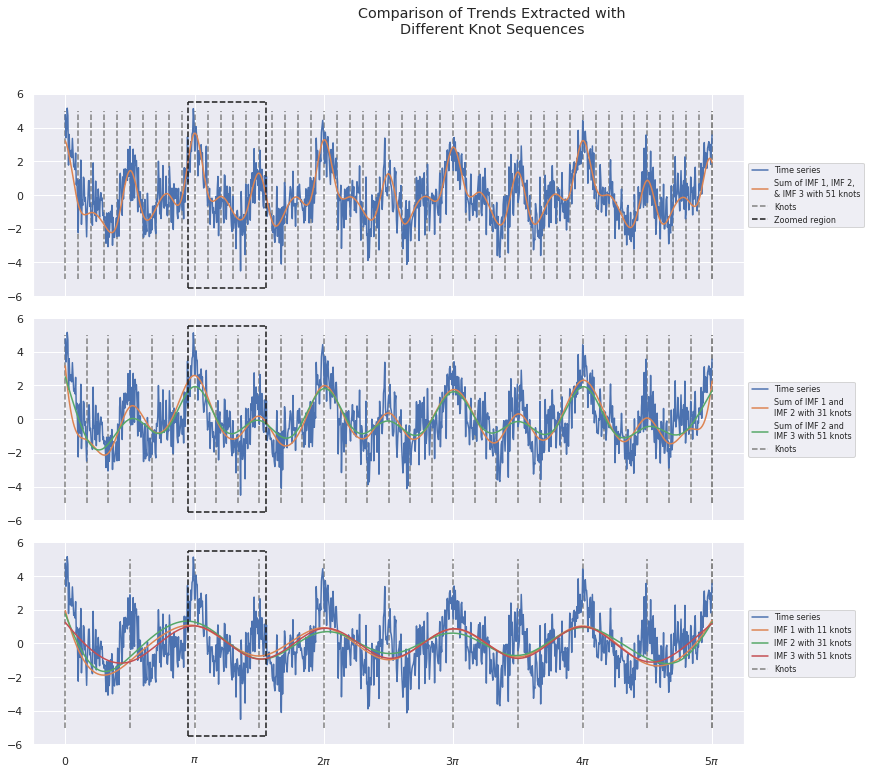

In [23]:
fig, axs = plt.subplots(3, 1)
plt.suptitle(textwrap.fill('Comparison of Trends Extracted with Different Knot Sequences', 40))
plt.subplots_adjust(hspace=0.1)
axs[0].plot(time, time_series, label='Time series')
axs[0].plot(time, imfs_51[1, :] + imfs_51[2, :] + imfs_51[3, :], label=textwrap.fill('Sum of IMF 1, IMF 2, & IMF 3 with 51 knots', 21))
for knot in knots_51:
    axs[0].plot(knot * np.ones(101), np.linspace(-5, 5, 101), '--', c='grey', zorder=1)
axs[0].plot(knot * np.ones(101), np.linspace(-5, 5, 101), '--', c='grey', zorder=1, label='Knots')
axs[0].set_xticks([0, np.pi, 2 * np.pi, 3 * np.pi, 4 * np.pi, 5 * np.pi])
axs[0].set_xticklabels(['', '', '', '', '', ''])
axs[0].plot(np.linspace(0.95 * np.pi, 1.55 * np.pi, 101), 5.5 * np.ones(101), 'k--')
axs[0].plot(np.linspace(0.95 * np.pi, 1.55 * np.pi, 101), -5.5 * np.ones(101), 'k--')
axs[0].plot(0.95 * np.pi * np.ones(101), np.linspace(-5.5, 5.5, 101), 'k--')
axs[0].plot(1.55 * np.pi * np.ones(101), np.linspace(-5.5, 5.5, 101), 'k--', label='Zoomed region')
box_0 = axs[0].get_position()
axs[0].set_position([box_0.x0 - 0.05, box_0.y0, box_0.width * 0.85, box_0.height])
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

axs[1].plot(time, time_series, label='Time series')
axs[1].plot(time, imfs_31[1, :] + imfs_31[2, :], label=textwrap.fill('Sum of IMF 1 and IMF 2 with 31 knots', 19))
axs[1].plot(time, imfs_51[2, :] + imfs_51[3, :], label=textwrap.fill('Sum of IMF 2 and IMF 3 with 51 knots', 19))
for knot in knots_31:
    axs[1].plot(knot * np.ones(101), np.linspace(-5, 5, 101), '--', c='grey', zorder=1)
axs[1].plot(knot * np.ones(101), np.linspace(-5, 5, 101), '--', c='grey', zorder=1, label='Knots')
axs[1].set_xticks([0, np.pi, 2 * np.pi, 3 * np.pi, 4 * np.pi, 5 * np.pi])
axs[1].set_xticklabels(['', '', '', '', '', ''])
box_1 = axs[1].get_position()
axs[1].set_position([box_1.x0 - 0.05, box_1.y0, box_1.width * 0.85, box_1.height])
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
axs[1].plot(np.linspace(0.95 * np.pi, 1.55 * np.pi, 101), 5.5 * np.ones(101), 'k--')
axs[1].plot(np.linspace(0.95 * np.pi, 1.55 * np.pi, 101), -5.5 * np.ones(101), 'k--')
axs[1].plot(0.95 * np.pi * np.ones(101), np.linspace(-5.5, 5.5, 101), 'k--')
axs[1].plot(1.55 * np.pi * np.ones(101), np.linspace(-5.5, 5.5, 101), 'k--', label='Zoomed region')

axs[2].plot(time, time_series, label='Time series')
axs[2].plot(time, imfs_11[1, :], label='IMF 1 with 11 knots')
axs[2].plot(time, imfs_31[2, :], label='IMF 2 with 31 knots')
axs[2].plot(time, imfs_51[3, :], label='IMF 3 with 51 knots')
for knot in knots_11:
    axs[2].plot(knot * np.ones(101), np.linspace(-5, 5, 101), '--', c='grey', zorder=1)
axs[2].plot(knot * np.ones(101), np.linspace(-5, 5, 101), '--', c='grey', zorder=1, label='Knots')
axs[2].set_xticks([0, np.pi, 2 * np.pi, 3 * np.pi, 4 * np.pi, 5 * np.pi])
axs[2].set_xticklabels(['$0$', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$4\pi$', r'$5\pi$'])
box_2 = axs[2].get_position()
axs[2].set_position([box_2.x0 - 0.05, box_2.y0, box_2.width * 0.85, box_2.height])
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
axs[2].plot(np.linspace(0.95 * np.pi, 1.55 * np.pi, 101), 5.5 * np.ones(101), 'k--')
axs[2].plot(np.linspace(0.95 * np.pi, 1.55 * np.pi, 101), -5.5 * np.ones(101), 'k--')
axs[2].plot(0.95 * np.pi * np.ones(101), np.linspace(-5.5, 5.5, 101), 'k--')
axs[2].plot(1.55 * np.pi * np.ones(101), np.linspace(-5.5, 5.5, 101), 'k--', label='Zoomed region')
plt.show()

Figure 12: Example time series demonstrating detrended fluctuation analysis of time serieswith different knot sequences resulting in different trend estimation.

In Figure 12 one can observe the relationship between detrended fluctuation analysis and theiterative IMF extraction method known as EMD. In the top image of Figure 12, one canobserve the trend as the sum of all the IMFs extracted with a sufficient knot sequence. In themiddle image, the trend is approximated with a knot sequence that is insufficient to capturethe highest frequency structure. One can also see how closely this trend resembles the sum ofIMF 2 and IMF 3 for EMD when the knot sequence is sufficient. Finally, in the bottom image, one can see how the trend is estimated with a wholly insufficient knot sequence compared with the lowest order IMF of each previous sifting procedure.

# Figure 13

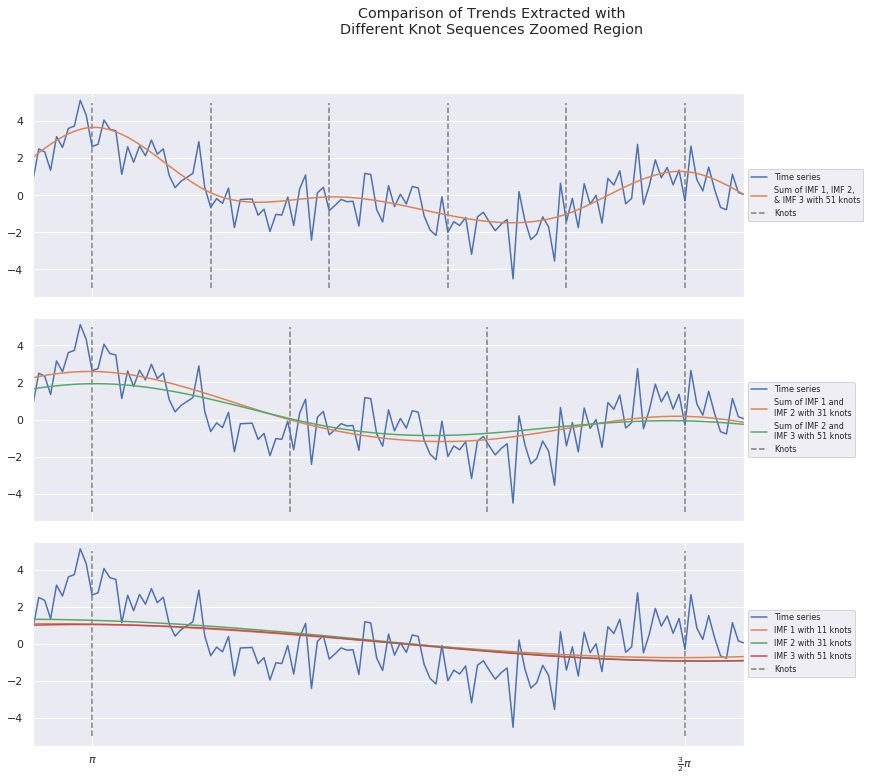

In [24]:
fig, axs = plt.subplots(3, 1)
plt.suptitle(textwrap.fill('Comparison of Trends Extracted with Different Knot Sequences Zoomed Region', 40))
plt.subplots_adjust(hspace=0.1)
axs[0].plot(time, time_series, label='Time series')
axs[0].plot(time, imfs_51[1, :] + imfs_51[2, :] + imfs_51[3, :], label=textwrap.fill('Sum of IMF 1, IMF 2, & IMF 3 with 51 knots', 21))
for knot in knots_51:
    axs[0].plot(knot * np.ones(101), np.linspace(-5, 5, 101), '--', c='grey', zorder=1)
axs[0].plot(knot * np.ones(101), np.linspace(-5, 5, 101), '--', c='grey', zorder=1, label='Knots')
axs[0].set_xticks([0, np.pi, 2 * np.pi, 3 * np.pi, 4 * np.pi, 5 * np.pi])
axs[0].set_xticklabels(['', '', '', '', '', ''])
box_0 = axs[0].get_position()
axs[0].set_position([box_0.x0 - 0.05, box_0.y0, box_0.width * 0.85, box_0.height])
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
axs[0].set_ylim(-5.5, 5.5)
axs[0].set_xlim(0.95 * np.pi, 1.55 * np.pi)

axs[1].plot(time, time_series, label='Time series')
axs[1].plot(time, imfs_31[1, :] + imfs_31[2, :], label=textwrap.fill('Sum of IMF 1 and IMF 2 with 31 knots', 19))
axs[1].plot(time, imfs_51[2, :] + imfs_51[3, :], label=textwrap.fill('Sum of IMF 2 and IMF 3 with 51 knots', 19))
for knot in knots_31:
    axs[1].plot(knot * np.ones(101), np.linspace(-5, 5, 101), '--', c='grey', zorder=1)
axs[1].plot(knot * np.ones(101), np.linspace(-5, 5, 101), '--', c='grey', zorder=1, label='Knots')
axs[1].set_xticks([0, np.pi, 2 * np.pi, 3 * np.pi, 4 * np.pi, 5 * np.pi])
axs[1].set_xticklabels(['', '', '', '', '', ''])
box_1 = axs[1].get_position()
axs[1].set_position([box_1.x0 - 0.05, box_1.y0, box_1.width * 0.85, box_1.height])
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
axs[1].set_ylim(-5.5, 5.5)
axs[1].set_xlim(0.95 * np.pi, 1.55 * np.pi)

axs[2].plot(time, time_series, label='Time series')
axs[2].plot(time, imfs_11[1, :], label='IMF 1 with 11 knots')
axs[2].plot(time, imfs_31[2, :], label='IMF 2 with 31 knots')
axs[2].plot(time, imfs_51[3, :], label='IMF 3 with 51 knots')
for knot in knots_11:
    axs[2].plot(knot * np.ones(101), np.linspace(-5, 5, 101), '--', c='grey', zorder=1)
axs[2].plot(knot * np.ones(101), np.linspace(-5, 5, 101), '--', c='grey', zorder=1, label='Knots')
axs[2].set_xticks([np.pi, (3 / 2) * np.pi])
axs[2].set_xticklabels([r'$\pi$', r'$\frac{3}{2}\pi$'])
box_2 = axs[2].get_position()
axs[2].set_position([box_2.x0 - 0.05, box_2.y0, box_2.width * 0.85, box_2.height])
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
axs[2].set_ylim(-5.5, 5.5)
axs[2].set_xlim(0.95 * np.pi, 1.55 * np.pi)
plt.show()

Figure 13: Example time series demonstrating detrended fluctuation analysis of time serieswith different knot sequences resulting in different trend estimation.

In Figure 13 the different frequency structures are more easily visible. It can be shown that:

\begin{equation} \label{eq: DFA_limit}
    \text{lim}_{n\rightarrow{\infty}}\sqrt{\frac{1}{n-1}\sum_{k=1}^{n}\text{cos}^2\bigg(\frac{2\pi{fk}}{n}\bigg)} = \frac{1}{\sqrt{2}} \approx 0.707,
\end{equation}

with $ f \in N $ and $ f << n $. With this in mind, and noting the structure of Equation (62), one can understand the following results:

\begin{equation}
\begin{split}
    SD\bigg(f(t) - \sum_{i=1}^3{IMF^{51}_i(t)}\bigg) &= 1.005 \approx 1\\
    SD\bigg(f(t) - \sum_{i=1}^2{IMF^{31}_i(t)}\bigg) &= 1.558\\
    SD\bigg(f(t) - IMF^{11}_1(t)\bigg) &= 2.072,
\end{split}
\end{equation}

In [25]:
print(np.round(np.var(time_series - (imfs_51[1, :] + imfs_51[2, :] + imfs_51[3, :])), 3))
print(np.round(np.var(time_series - (imfs_31[1, :] + imfs_31[2, :])), 3))
print(np.round(np.var(time_series - imfs_51[3, :]), 3))

1.005
1.558
2.072


with $ IMF^{j}_i $ being the $ i^{th} $ IMF with knot sequence $ j $. The first equality in Equation (64) most closely calculates the true underlying noise present in the system as a result of the random fluctuations caused by the Standard Normally distributed Gaussian Noise. In the other equalities, the standard deviation calculations are confounded by undetected underlying high-frequency structures with their individual "standard deviations" being approximated by Equation (63). The parallels between detrended fluctuation analysis and EMD should be noted by the user. By noting Figure 12, Figure 13, and Figure 14 one can observe that as a result of the defined knot sequence that fluctuation is measured relative to some frequency band. Each IMF exists in some frequency range and the fluctuations calculated in Equation (64) measure the local fluctuation relative to some implicit frequency boundary as a result of the knot sequence defined.

# Figure 14

In [26]:
hs_ouputs = hilbert_spectrum(time, imfs_51, hts_51, ifs_51, max_frequency=12, plot=False)

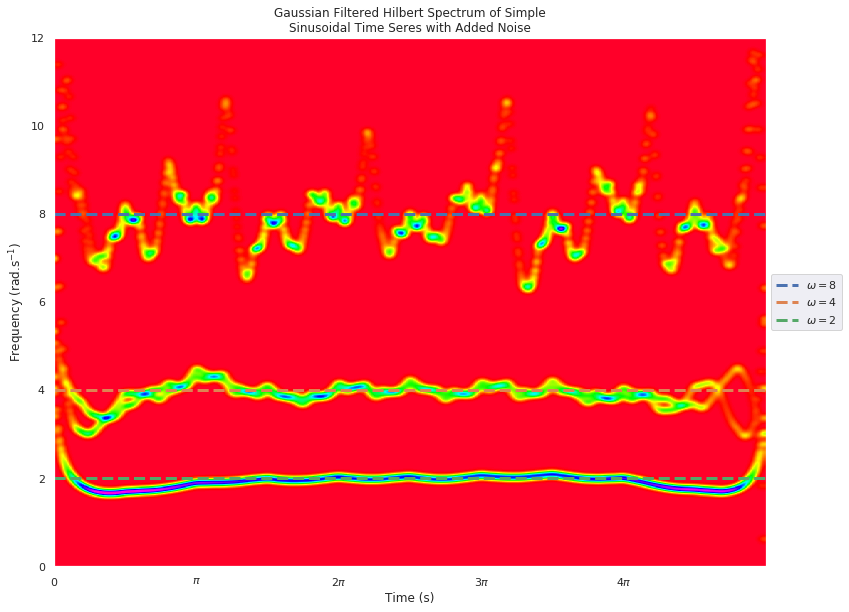

In [27]:
ax = plt.subplot(111)
figure_size = plt.gcf().get_size_inches()
factor = 0.9
plt.gcf().set_size_inches((figure_size[0], factor * figure_size[1]))
plt.title(textwrap.fill('Gaussian Filtered Hilbert Spectrum of Simple Sinusoidal Time Seres with Added Noise', 50))
x_hs, y, z = hs_ouputs
z_min, z_max = 0, np.abs(z).max()
ax.pcolormesh(x_hs, y, np.abs(z), cmap='gist_rainbow', vmin=z_min, vmax=z_max)
ax.plot(x_hs[0, :], 8 * np.ones_like(x_hs[0, :]), '--', label=r'$\omega = 8$', Linewidth=3)
ax.plot(x_hs[0, :], 4 * np.ones_like(x_hs[0, :]), '--', label=r'$\omega = 4$', Linewidth=3)
ax.plot(x_hs[0, :], 2 * np.ones_like(x_hs[0, :]), '--', label=r'$\omega = 2$', Linewidth=3)
ax.set_xticks([0, np.pi, 2 * np.pi, 3 * np.pi, 4 * np.pi])
ax.set_xticklabels(['$0$', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$4\pi$'])
plt.ylabel(r'Frequency (rad.s$^{-1}$)')
plt.xlabel('Time (s)')
box_0 = ax.get_position()
ax.set_position([box_0.x0, box_0.y0 + 0.05, box_0.width * 0.85, box_0.height * 0.9])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Figure 14: Hilbert spectrum of example time series demonstrating the frequencies of the threeIMFs present when sufficient knots are used.

In Figure 14 the frequencies of the three constituent structures (apart from the added standardnormal Gaussian noise) are visible.  The highest frequency structure is perturbed by thenoise as expected. EMD can be viewed as a generalisation of detrended fluctuation analysiswhereby the trend is decomposed into separate frequency structures in descending order ofinstantaneous frequency using a defined knot sequence (in general).The local mean can be estimated using the framework in Section 2.3 without any explicit orimplicit smoothing. Explicit smoothing that deals simultaneously with smoothing and theedge effects is referred to in the literature as Statistical EMD (SEMD). The base implemen-tation of the detrended fluctuation analysis is as follows:

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,knot_time=knot_time,smooth=True,smoothing_penalty=0.1,dft='envelopes',order=15,increment=10).

### Statistical EMD (P-Splines)

This method (smooth=True) is introduced in Kim, Kim, and Oh (2012). SEMD, in the cubic B-spline envelope setting, can be implemented by introducing a smoothing parameter intothe objective function, Equation (19). The specific introduction of a penalty into B-splinesis discussed in Eilers and Marx (1996) and is referred to as P-splines. The matricificationof the P-spline objective function can be seen below.  Second-order smoothing is done onthe coefficients, but this can be generalised to higher-order smoothing.  The second-ordersmoothing of the coefficients is incorporated using the $ \boldsymbol{D} $ matrix seen below:

\begin{equation}
\boldsymbol{D} = \begin{bmatrix}
1 & -2 & 1 & 0 & 0 & \cdots & 0\\
0 & 1 & -2 & 1 & 0 & \cdots & 0\\
\vdots & & \ddots & \ddots & \ddots & & \vdots\\
0 & \cdots & 0 & 1 & -2 & 1 & 0\\
0 & \cdots & 0 & 0 & 1 & -2 & 1\\
\end{bmatrix},
\end{equation}

and with $ \boldsymbol{P} $ defined as below,

\begin{equation} \label{P_matrix}
    \boldsymbol{P} = \boldsymbol{D}^T\boldsymbol{D},
\end{equation}

Equation (19), with $ \boldsymbol{s} $, $ \boldsymbol{B} $, and $ \boldsymbol{c} $ defined as before and with discrete penalty term $ \lambda $, becomes:

\begin{equation} \label{DPMSE}
    DPMSE(\boldsymbol{c}|\boldsymbol{s}) = (\boldsymbol{s} - \boldsymbol{B}\boldsymbol{c})^T(\boldsymbol{s} - \boldsymbol{B}\boldsymbol{c}) + \lambda\boldsymbol{c}^T\boldsymbol{P}\boldsymbol{c}.
\end{equation}

The magnitude of the penalty term, $ \lambda $ (smoothing_penalty=0.1), determines the amount of smoothing. SEMD is implemented separately to the other detrended fluctuation techniques as smoothing can be done irrespective of the detrended fluctuation technique used. It is highly recommended that \code{smooth=True} and the smoothing penalty is non-zero when \code{dft='envelopes'} as the extrema are not guaranteed to satisfy the Schoenberg–Whitney Conditions (SWC) for an arbitrary knot sequence. This will allow envelopes to be fitted even when there are no extrema between successive knot points, otherwise nonsensical envelopes may result. For an arbitrary set of extrema $ \mathbf{y} = \{y_1, y_2, \dots, y_j\} $, a cubic B-spline knot sequence $ \boldsymbol{\tau} = \{\tau_1, \tau_2, \dots, \tau_{j+4}\} $, the SWC can be stated as:

\begin{equation}
    \tau_i \leq y_i, \leq \tau_{i+1}\text{ }\forall\text{ }i \in \{1, 2, \dots, j-1\}.
\end{equation}

In Figure 15 the following time series is plotted to demonstrate the necessity for either the SWC to be satisfied or for the envelopes to be smoothed:

\begin{equation}
    g(t) = \text{cos}(t) + \text{cos}(5t),
\end{equation}

with $ t \in [0, 5\pi] $. With $ \lambda = 0 $ in Equation (67) and with the SWC not being satisfied by either the maxima or the minima, the envelopes are stretched towards zero. This is, unfortunately, unavoidable without either the SWC being satisfied or some form of smoothing.

# Figure 15

In [28]:
time = np.linspace(0, 5 * np.pi, 1001)
time_series = np.cos(time) + np.cos(5 * time)
knots = np.linspace(0, 5 * np.pi, 51)
fluc = Fluctuation(time=time, time_series=time_series)
max_unsmoothed = fluc.envelope_basis_function_approximation(knots_for_envelope=knots, extrema_type='maxima', smooth=False)
max_smoothed = fluc.envelope_basis_function_approximation(knots_for_envelope=knots, extrema_type='maxima', smooth=True)
min_unsmoothed = fluc.envelope_basis_function_approximation(knots_for_envelope=knots, extrema_type='minima', smooth=False)
min_smoothed = fluc.envelope_basis_function_approximation(knots_for_envelope=knots, extrema_type='minima', smooth=True)
util = Utility(time=time, time_series=time_series)
maxima = util.max_bool_func_1st_order_fd()
minima = util.min_bool_func_1st_order_fd()

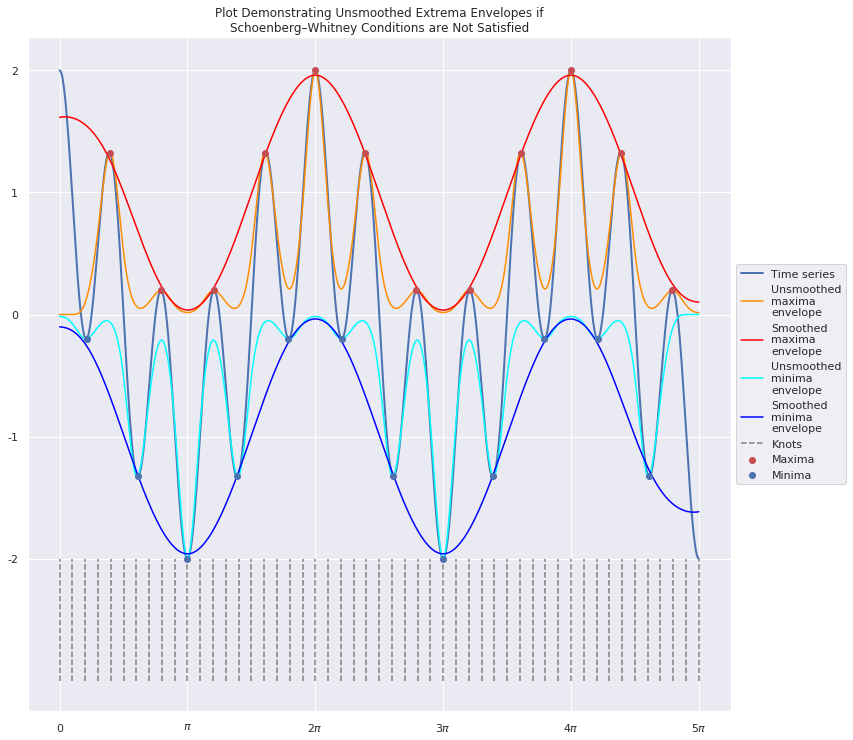

In [29]:
ax = plt.subplot(111)
plt.gcf().subplots_adjust(bottom=0.10)
plt.title(textwrap.fill('Plot Demonstrating Unsmoothed Extrema Envelopes if Schoenberg–Whitney Conditions are Not Satisfied', 50))
plt.plot(time, time_series, label='Time series', zorder=2, LineWidth=2)
plt.scatter(time[maxima], time_series[maxima], c='r', label='Maxima', zorder=10)
plt.scatter(time[minima], time_series[minima], c='b', label='Minima', zorder=10)
plt.plot(time, max_unsmoothed[0], label=textwrap.fill('Unsmoothed maxima envelope', 10), c='darkorange')
plt.plot(time, max_smoothed[0], label=textwrap.fill('Smoothed maxima envelope', 10), c='red')
plt.plot(time, min_unsmoothed[0], label=textwrap.fill('Unsmoothed minima envelope', 10), c='cyan')
plt.plot(time, min_smoothed[0], label=textwrap.fill('Smoothed minima envelope', 10), c='blue')
for knot in knots[:-1]:
    plt.plot(knot * np.ones(101), np.linspace(-3.0, -2.0, 101), '--', c='grey', zorder=1)
plt.plot(knots[-1] * np.ones(101), np.linspace(-3.0, -2.0, 101), '--', c='grey', label='Knots', zorder=1)
plt.xticks((0, 1 * np.pi, 2 * np.pi, 3 * np.pi, 4 * np.pi, 5 * np.pi), (r'$0$', r'$\pi$', r'2$\pi$', r'3$\pi$', r'4$\pi$', r'5$\pi$'))
plt.yticks((-2, -1, 0, 1, 2), ('-2', '-1', '0', '1', '2'))
plt.xlim(-0.25 * np.pi, 5.25 * np.pi)
box_0 = ax.get_position()
ax.set_position([box_0.x0 - 0.05, box_0.y0, box_0.width * 0.84, box_0.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Figure 15: Example time series demonstrating unsmoothed extrema envelopes being fittedwhen SWC are not satisfied resulting in nonsensical envelopes.

### Enhanced EMD

In Kopsinis and McLaughlin (2007a) Enhanced EMD (dft=‘enhanced’) is introduced. InKopsinis and McLaughlin (2007b) and Kopsinis and McLaughlin (2008) a genetic searchalgorithm is used to optimise the interpolation point allocation to optimise the local meanestimation when compared against the known local mean but in Kopsinis and McLaughlin(2007a), the EMD is performed on the derivative of the time series to isolate the highestfrequency component. Using the highest frequency component of the derivative, the optimalinterpolation point allocation can be estimated for the estimation of the local mean.The only difference to the above is the preprocessing (in a sense) of the time series to estimatethe optimal extrema points.The derivative of the time series can be calculated using the first forward difference:

\begin{equation}
	\boldsymbol{s'} = \begin{bmatrix}
	s'(t_0) = \frac{s(t_1) - s(t_0)}{t_1 - t_0}\\
	s'(t_1) = \frac{s(t_2) - s(t_1)}{t_2 - t_1}\\
	\vdots\\
	s'(t_{N-1}) = \frac{s(t_N) - s(t_{N-1})}{t_N - t_{N-1}}
	\end{bmatrix}.
\end{equation}

Given the B-spline framework developed in Section 2.3 and using a result stated in Chen et al.(2006) and proved in de Boor (1978) the derivative of a B-spline basis (and therefore a spline fitted using B-splines) can be calculated as:

\begin{equation}
	B'_{j,k,\tau}(t) = \dfrac{k-1}{\tau_{j+k-1} - \tau_j}B_{j,k-1,\tau}(t) - \dfrac{k-1}{\tau_{j+k} - \tau_{j+1}}B_{j+1,k-1,\tau}(t).
\end{equation} 

Therefore, with

\begin{equation}
\boldsymbol{B}' = \begin{bmatrix}
B'_{0,4}(t_0) & \cdots & B'_{(M-4),4}(t_0)\\
B'_{0,4}(t_1) & \cdots & B'_{(M-4),4}(t_1)\\
\vdots & \ddots & \vdots\\
B'_{0,4}(t_{N}) & \cdots & B'_{(M-4),4}(t_{N})\\
\end{bmatrix},
\end{equation}

and $ \boldsymbol{c} $ optimised in either Equation (19) or Equation (67), the derivative of of a B-spline curve can be calculated as:

\begin{equation}
\boldsymbol{s'} = \boldsymbol{B}'\boldsymbol{c}.
\end{equation}

Once the derivative of the spline curve has been obtained (by whichever method), the EMD method is then performed on the derivative until the first IMF (highest frequency structure) is isolated. The derivative is therefore dichotomised such that:

\begin{equation}
	s'(t) = s'_h(t) + s'_l(t).
\end{equation}

Using the same technique as above such that:

\begin{equation}
\begin{split}
B''_{j,k,\tau}(t) &= \dfrac{k-1}{\tau_{j+k-1} - \tau_j}B'_{j,k-1,\tau}(t) - \dfrac{k-1}{\tau_{j+k} - \tau_{j+1}}B'_{j+1,k-1,\tau}(t)\\
&= \dfrac{(k-1)(k-2)}{(\tau_{j+k-1} - \tau_j)(\tau_{j+k-2} - \tau_j)}B_{j,k-2,\tau}(t)\\ 
&- \dfrac{(k-1)(k-2)}{(\tau_{j+k-1} - \tau_j)(\tau_{j+k-1} - \tau_{j+1})}B_{j+1,k-2,\tau}(t)\\
&- \dfrac{(k-1)(k-2)}{(\tau_{j+k} - \tau_{j+1})(\tau_{j+k-1} - \tau_{j+1})}B_{j+1,k-2,\tau}(t)\\
&+ \dfrac{(k-1)(k-2)}{(\tau_{j+k} - \tau_{j+1})(\tau_{j+k} - \tau_{j+2})}B_{j+2,k-2,\tau}(t)\\
\end{split},
\end{equation}

the derivative of $ s'_h(t) $, $ s''_h(t) $, can be calculated as:

\begin{equation}
\boldsymbol{s''_h} = \boldsymbol{B}''\boldsymbol{c_h},
\end{equation}

with

\begin{equation}
\boldsymbol{B}'' = \begin{bmatrix}
B''_{0,4}(t_0) & \cdots & B''_{(M-4),4}(t_0)\\
B''_{0,4}(t_1) & \cdots & B''_{(M-4),4}(t_1)\\
\vdots & \ddots & \vdots\\
B''_{0,4}(t_{N}) & \cdots & B''_{(M-4),4}(t_{N})\\
\end{bmatrix},
\end{equation}

and $ \boldsymbol{c_h} $ being the coefficients corresponding to $ s'_h(t) $. The optimised maxima for the extraction of the first IMF can then be calculated as the points in $ s(t) $ such that:

\begin{equation}
	s'_h(t) = 0 \text{ and } s''_h(t) < 0,
\end{equation}

with the optimised minima being calculated as the points in $ s(t) $ such that:

\begin{equation}
s'_h(t) = 0 \text{ and } s''_h(t) > 0.
\end{equation}

The EMD algorithm proceeds as before with the extrema not changing until an IMF is extracted. The new optimised extrema are then calculated and the algorithm continues.

### Inflection Point Interpolation

The detrended fluctuation analysis of a time series to estimate the local mean by interpolatingthrough the interpolation points (dft=‘inflection_points’) was first proposed in Kopsinisand McLaughlin (2007b). The inflection points are calculated using:

\begin{equation}
\boldsymbol{s''} = \boldsymbol{B}''\boldsymbol{c},
\end{equation}

with the inflection points being such that:

\begin{equation}
	s''(t) = 0.
\end{equation}

### Binomial Average Interpolation

All the above methods are well suited to smoothed data. If the above methods were to bedirectly applied to noisy data there would be a proliferation of extrema and any potentiallymeaningful information in the first IMF would be obscured by the noise. This is a double-edged sword as over-smoothing would also result in the loss of meaningful high-frequency information. In Chen et al.(2006), estimating the local mean structure is done by taking a binomial average(dft=‘binomial_average’) of the surrounding points. This may be classified as a form ofpreprocessing as smoothing is then required to create a local mean to be extracted, otherwisehigh-frequency content may be present in lower-order IMFs.The binomial average is calculated as:

\begin{equation}
\mu(\tau_j) = \dfrac{1}{2^{k-1}}{{\sum}}_{h = j-\frac{(k-1)}{2}}^{j+\frac{(k-1)}{2}}\binom{k-1}{h-\Big(j-\frac{(k-1)}{2}\Big)}s(\tau_h),
\end{equation}

with $ \mu(\tau_j) $ being the binomial average of the time series at time point $ \tau_j $, k (\code{order=15}) being the order of the binomial averaging such that $ k = 2n + 1 $ with $ n \in \mathbb{N} $, and $ s(\tau_h) $ being the value of time series at time point $ \tau_j $ with $ j $ being every $ 10^{th} $ (increment=10) point. All of the discussed detrended fluctuation techniques can be seen in Figure 16 - when thetime series is well-behaved or smooth all the methods converge, but nuances still exist.

# Figure 16

In [30]:
a = 0.25
width = 0.2
time = np.linspace((0 + a) * np.pi, (5 - a) * np.pi, 1001)
knots = np.linspace((0 + a) * np.pi, (5 - a) * np.pi, 11)
time_series = np.cos(time) + np.cos(5 * time)
utils = emd_utils.Utility(time=time, time_series=time_series)
max_bool = utils.max_bool_func_1st_order_fd()
maxima_x = time[max_bool]
maxima_y = time_series[max_bool]
min_bool = utils.min_bool_func_1st_order_fd()
minima_x = time[min_bool]
minima_y = time_series[min_bool]
inflection_bool = utils.inflection_point()
inflection_x = time[inflection_bool]
inflection_y = time_series[inflection_bool]

fluctuation = emd_mean.Fluctuation(time=time, time_series=time_series)
maxima_envelope = fluctuation.envelope_basis_function_approximation(knots, 'maxima', smooth=False, smoothing_penalty=0.2, edge_effect='none', spline_method='b_spline')[0]
maxima_envelope_smooth = fluctuation.envelope_basis_function_approximation(knots, 'maxima', smooth=True, smoothing_penalty=0.2, edge_effect='none', spline_method='b_spline')[0]
minima_envelope = fluctuation.envelope_basis_function_approximation(knots, 'minima', smooth=False, smoothing_penalty=0.2, edge_effect='none', spline_method='b_spline')[0]
minima_envelope_smooth = fluctuation.envelope_basis_function_approximation(knots, 'minima', smooth=True, smoothing_penalty=0.2, edge_effect='none', spline_method='b_spline')[0]
inflection_points_envelope = fluctuation.direct_detrended_fluctuation_estimation(knots, smooth=True, smoothing_penalty=0.2, technique='inflection_points')[0]
binomial_points_envelope = fluctuation.direct_detrended_fluctuation_estimation(knots, smooth=True, smoothing_penalty=0.2, technique='binomial_average', order=21, increment=20)[0]
derivative_of_lsq = utils.derivative_forward_diff()
derivative_time = time[:-1]
derivative_knots = np.linspace(knots[0], knots[-1], 31)

# change (1) detrended_fluctuation_technique and (2) max_internal_iter and (3) debug (confusing with external debugging)
emd = AdvEMDpy.EMD(time=derivative_time, time_series=derivative_of_lsq)
imf_1_of_derivative = emd.empirical_mode_decomposition(knots=derivative_knots, knot_time=derivative_time, text=False)[0][1, :]
utils = emd_utils.Utility(time=time[:-1], time_series=imf_1_of_derivative)
optimal_maxima = np.r_[False, utils.derivative_forward_diff() < 0, False] & np.r_[utils.zero_crossing() == 1, False]
optimal_minima = np.r_[False, utils.derivative_forward_diff() > 0, False] & np.r_[utils.zero_crossing() == 1, False]

EEMD_maxima_envelope = fluctuation.envelope_basis_function_approximation_fixed_points(knots, 'maxima', optimal_maxima, optimal_minima, smooth=False, smoothing_penalty=0.2, edge_effect='none')[0]
EEMD_minima_envelope = fluctuation.envelope_basis_function_approximation_fixed_points(knots, 'minima', optimal_maxima, optimal_minima, smooth=False, smoothing_penalty=0.2, edge_effect='none')[0]

../AdvEMDpy.py:1191: UserWarning: Recommended knots are subset of knot time points for discontinuity issues.
  warnings.warn('Recommended knots are subset of knot time points for discontinuity issues.')


IMF_11 Standard deviation STOPPING CRITERION NOT MET with sd = 103.2
IMF_12 Standard deviation STOPPING CRITERION NOT MET with sd = 57.58
IMF_13 Standard deviation STOPPING CRITERION MET with sd = 6.12 < sd threshold = 10
IMF_21 Standard deviation STOPPING CRITERION NOT MET with sd = 152126.49
IMF_22 Standard deviation STOPPING CRITERION NOT MET with sd = 565066.17
IMF_23 ALL IMF CONDITIONS MET
IMF_31 TREND CONDITION MET with fewer than 3 extrema and global mean removed
IMF_32 ALL IMF CONDITIONS MET


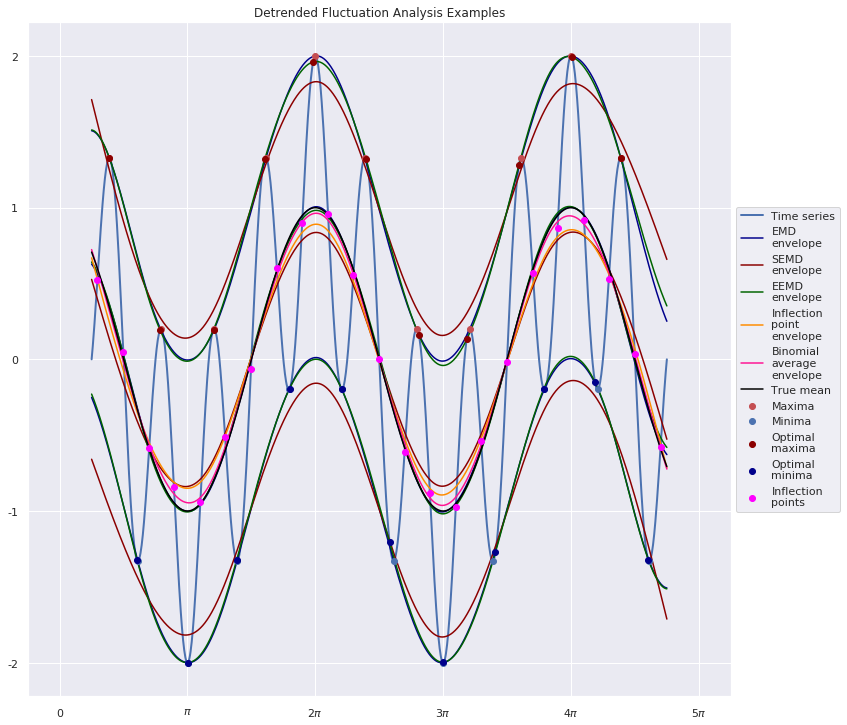

In [31]:
ax = plt.subplot(111)
plt.gcf().subplots_adjust(bottom=0.10)
plt.title('Detrended Fluctuation Analysis Examples')
plt.plot(time, time_series, LineWidth=2, label='Time series')
plt.scatter(maxima_x, maxima_y, c='r', zorder=4, label='Maxima')
plt.scatter(minima_x, minima_y, c='b', zorder=4, label='Minima')
plt.scatter(time[optimal_maxima], time_series[optimal_maxima], c='darkred', zorder=4, label=textwrap.fill('Optimal maxima', 10))
plt.scatter(time[optimal_minima], time_series[optimal_minima], c='darkblue', zorder=4, label=textwrap.fill('Optimal minima', 10))
plt.scatter(inflection_x, inflection_y, c='magenta', zorder=4, label=textwrap.fill('Inflection points', 10))
plt.plot(time, maxima_envelope, c='darkblue', label=textwrap.fill('EMD envelope', 10))
plt.plot(time, minima_envelope, c='darkblue')
plt.plot(time, (maxima_envelope + minima_envelope) / 2, c='darkblue')
plt.plot(time, maxima_envelope_smooth, c='darkred', label=textwrap.fill('SEMD envelope', 10))
plt.plot(time, minima_envelope_smooth, c='darkred')
plt.plot(time, (maxima_envelope_smooth + minima_envelope_smooth) / 2, c='darkred')
plt.plot(time, EEMD_maxima_envelope, c='darkgreen', label=textwrap.fill('EEMD envelope', 10))
plt.plot(time, EEMD_minima_envelope, c='darkgreen')
plt.plot(time, (EEMD_maxima_envelope + EEMD_minima_envelope) / 2, c='darkgreen')
plt.plot(time, inflection_points_envelope, c='darkorange', label=textwrap.fill('Inflection point envelope', 10))
plt.plot(time, binomial_points_envelope, c='deeppink', label=textwrap.fill('Binomial average envelope', 10))
plt.plot(time, np.cos(time), c='black', label='True mean')
plt.xticks((0, 1 * np.pi, 2 * np.pi, 3 * np.pi, 4 * np.pi, 5 * np.pi), (r'$0$', r'$\pi$', r'2$\pi$', r'3$\pi$', r'4$\pi$', r'5$\pi$'))
plt.yticks((-2, -1, 0, 1, 2), ('-2', '-1', '0', '1', '2'))
plt.xlim(-0.25 * np.pi, 5.25 * np.pi)
box_0 = ax.get_position()
ax.set_position([box_0.x0 - 0.05, box_0.y0, box_0.width * 0.84, box_0.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Figure 16: Example time series demonstrating five different local mean estimation techniquesthrough detrended fluctuation analysis.

### Recommendations for Detrended Fluctuation Analysis in AdvEMDpy Package

The most studied and utilised local mean estimation technique is the standard envelopetechnique (dft=‘envelopes’) originally put forward in Huang et al.(1998), Huang et al.(1999), and Huang (1999) and, as already mentioned, should be performed with smoothingsuch thatsmooth=Trueandsmoothing_penalty=0.1. This technique is recommended andis intended to be applied after an initial preprocessing or smoothing, otherwise, the first fewIMFs may be nonsensical as the noise in the time series will result in the proliferation ofextrema and confound our IMFs.

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,knot_time=knot_time,initial_smoothing=True,smooth=True,smoothing_penalty=0.1,dft='envelopes').

## 6.5. Stopping Criteria in AdvEMDpy Package

To prevent over-sifting resulting in physically meaningless IMFs and little discernible infor-mation about the process under observation, several stopping criteria are provided to preventover-sifting.  The validity of the various stopping criteria warrants further study as some are more related to algorithmic steps than others. The base implementation of the stoppingcriteria is as follows:

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,knot_time=knot_time,stop_crit='S_stoppage',stop_crit_threshold=10,mft_theta_1=0.05,mft_theta_2=0.5,mft_alpha=0.05,mean_threshold=10,max_internal_iter=30,max_imfs=10).

### Modified Mean Threshold

In order to be classified as an IMF, Condition 1 and Condition 2 need to both be satisfied.In practice, Condition 1 is easily achievable and takes relatively few iterations, but Condition2 is computationally very expensive and the large number of iterations required for the localmean of an IMF candidate to approach zero would, unfortunately, remove a large portionof meaningful content from the time series. This necessitates the statement of a modifiedversion of Condition 2 as stated in Section 5 and repeated here for ease of reference.

### Modified Condition 2:

\begin{equation}
\sum_t\text{abs}\bigg(\tilde{\gamma}^{\mu}_k(t) - 0 \bigg) = \sum_t\text{abs}\big(\tilde{\gamma}^{\mu}_k(t) \big) \leq \epsilon,
\end{equation}

for some chosen threshold value $ \epsilon $ (\code{mean_threshold=10}).

### Fixed Iteration

A simple stopping criterion puts a hard limit on the number of iterations allowed before theinternal iteration loop stops and the IMF is extracted (max_internal_iter=10). The fixediteration stopping criterion and the modified mean threshold criterion are implemented inaddition to other stopping criteria with them functioning as a hard limit on the number ofsiftings and a modification of the classical IMF condition, respectively.

### S Stoppage 

Much like the fixed iteration count stopping criterion, the S Stoppage, as in Huang andWu (2008) (stop_crit=‘S_stoppage’), is not mathematically rigorous but relies on a countvariable. Unlike the Fixed Iteration count stopping criterion, the S Stoppage criterion has aconditional count variable. The stopping criterion is reached when the difference between thenumber of zero crossings and the number of extrema remains constant over $ S $ iterations withthe number of iterations as another input (stop_crit_threshold=10).

### Cauchy-Type Convergence

This stopping criterion (stop_crit=‘sd’) was first proposed in Huanget al. (1998). Its nameresults from its similarity to the Cauchy convergence of a series in functional analysis. Thestandard deviation of IMF candidate $ j $ at iteration $ k $ is calculated as:

\begin{equation} \label{sd_stop}
SD_{(j,k)} = \sum_{t=t_0}^{T_{N}} \Bigg[\dfrac{\big|(h_{(j,k-1)}(t) - h_{(j,k)}(t))\big|^2}{h^2_{(j,k-1)}(t)}\Bigg] < \epsilon,
\end{equation}

for some threshold value $ \epsilon $ (stop_crit_threshold=10), with $ h_{(j,k)}(t) $ being IMF candidate $ j $ on iteration $ k $. In Huanget al.(1998) a threshold value of $ 0.2-0.3 $ is suggested with other works citing a value of $ 0.1 $. These values are subjective and are very dependent on the length of the time series under observation - a better description would be threshold per time point. 

### Cauchy-Type Convergence 11a

The first variation (stop_crit=‘sd_11a’) of the above stopping criterion proposed in Huangand Wu (2008) as Equation (11a) is calculated as:

\begin{equation}
SD^{11a}_{(j,k)} = \dfrac{\sum_{t=t_0}^{T_{N}}\big|(h_{(j,k-1)}(t) - h_{(j,k)}(t))\big|^2}{\sum_{t=t_0}^{T_{N}}h^2_{(j,k-1)}(t)} < \epsilon.
\end{equation}

This stopping criterion measures the relative energy difference between IMFs, rather than theCauchy-type convergence.

### Cauchy-Type Convergence 11b

The second variation (stop_crit=‘sd_11b’) of the above Cauchy-type convergence stopppingcriterion is also proposed in Huang and Wu (2008) as Equation (11b) and is calculated as:

\begin{equation} \label{11b}
SD^{11b}_{(j,k)} = \dfrac{\sum_{t=t_0}^{T_{N}}\mu^2_{(j,k)}(t)}{\sum_{t=t_0}^{T_{N}}h^2_{(j,k)}(t)} < \epsilon.
\end{equation}

Equation (85) can be seen as a combination of the Modified Mean Threshold and the Cauchy-Type Convergence. It has standardised the allowed mean discrepancy.

### Mean Fluctuation

This stopping criterion (stop_crit=‘mft’) is proposed in Rillinget al.(2003) and modifiedin Tabrizi, Garibaldi, Fasana, and Marchesiello (2014). It takes into account locally largefluctuations that would otherwise cause over-sifting throughout the majority of the signal.With $ \mu(t) $ being the calculated local mean and $ a(t) $ being the mode amplitude calculated as:

\begin{equation}
	a(t) = \dfrac{|M(t) - m(t)|}{2},
\end{equation}

with $ M(t) $ being the maximum envelope and $ m(t) $ being the minimum envelope the evaluation function can be calculated. The evaluation function is calculated as follows:

\begin{equation}
	\sigma(t) = \bigg|\dfrac{\mu(t)}{a(t)}\bigg|.
\end{equation}


Unlike the other stopping criteria, this stopping criterion requires three parameters, namely $ \theta_1 $ (\code{mft_theta_1=0.05}), $ \theta_2 $ (\code{mft_theta_2=0.5}), and $ \alpha $ (\code{mft_alpha=0.05}). The stopping criterion is met (and the internal loop is terminated) when $ \sigma(t) < \theta_1 $ for fraction $ (1 - \alpha) $ of the entire range of the time series, and $ \sigma(t) < \theta_2 $ for the remainder of the time series. In Rillinget al. (2003) typical values for the parameters are proposed as $ \theta_1 = 0.05 $, $ \theta_2 = 10\theta_1 $, and $ \alpha = 0.05 $.

### Energy Difference Tracking

This method (stop_crit=‘edt’) was proposed in Junsheng, Dejie, and Yu (2006). It takesadvantage of the orthogonality of the IMFs and as such the cumulative energy of the IMFsshould be equal to the energy of the original time series. The energy of an individual IMFcandidate can be calculated as:

\begin{equation}
E_{h_{(j,k)}} = E\big[h_{(j,k)}(t)\big] = \sum_{t=t_0}^{T_{N-1}}\Big|h_{(j,k)}(t)\Big|^2\Delta{t}.
\end{equation}

Should this candidate be selected as an IMF, the energy of the potential remainder of the time series after the removal of the IMF is calculated as:

\begin{equation}
E_{r_j} = E\big[r_j(t)\big] = \sum_{t=t_0}^{T_{N-1}}\Big|r_j(t)\Big|^2\Delta{t}.
\end{equation}

The energy of the residual time series before the removal of the IMF is calculated as:

\begin{equation}
E_{r_{j-1}} = E\big[r_{j-1}(t)\big] = \sum_{t=t_0}^{T_{N-1}}\Big|r_{j-1}(t)\Big|^2\Delta{t}.
\end{equation}

The internal iteration stops when the energy difference falls below a certain threshold value $ \epsilon $:

\begin{equation}
E_{diff} = \Big|E_{r_{j-1}} - \big(E_{h_{(j,k)}} + E_{r_j}\big)\Big| < \epsilon.
\end{equation}

### Recommendations for Stopping Criteria in AdvEMDpy Package

There are several recommendations for this particular aspect of the algorithm.  The mostwidely used stopping criterion is the Cauchy-Type Convergence, but this is often unstableand does not converge steadily such as an exponential decaying variable. One should useS Stoppage (stop_crit=‘S_stoppage’) with a threshold of 10 (stop_crit_threshold=10).In addition to this criterion, one should impose a value on the Modified Mean Threshold(mean_threshold=10), the maximum number of internal iterations (max_internal_iter=30),and the maximum allowed number of IMFs (max_imfs=10). With all these conditions thestopping criteria aspect of the algorithm should be sufficiently managed.

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,knot_time=knot_time,stop_crit='S_stoppage',stop_crit_threshold=10,mean_threshold=10,max_internal_iter=30,max_imfs=10).

## 6.6. Spline Methods in AdvEMDpy Package

All the above techniques are listed with the cubic B-spline implementation of EMD in mind.Other spline techniques are effective when using EMD. The other splines used have a differentbasis, but because they are both cubic bases, they may be easily mapped onto one another.The base implementation of cubic B-spline EMD is:

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,knot_time=knot_time,spline_method='b_spline').

EMD using cubic Hermite spline interpolation (CHSI) and Akima spline interpolation (ASI)is performed in Egambaramet al.(2016) to demonstrate their effectiveness in removing eye-blink artifacts from electroencephalograms. The basis for both CHSI and ASI is:

\begin{equation}
\begin{split}
	p(t) &= h_{00}(t^*)y(\tau_k) + h_{10}(t^*)(\tau_{k+1} - \tau_k)m(\tau_k)\\
	&+ h_{01}(t^*)y(\tau_{k+1}) + h_{11}(t^*)(\tau_{k+1} - \tau_k)m(\tau_{k+1}),
\end{split}
\end{equation}

with,

\begin{equation}
\begin{split}
	t^* &= \dfrac{t - \tau_k}{\tau_{k+1} - \tau_k},\\
	h_{00}(t^*) &= 2{t^*}^3 - 3{t^*}^2 + 1,\\
	h_{10}(t^*) &= {t^*}^3 - 2{t^*}^2 + t^*,\\
	h_{01}(t^*) &= -2{t^*}^3 + 3{t^*}^2, \text{ and}\\
	h_{11}(t^*) &= {t^*}^3 - {t^*}^2.
\end{split}
\end{equation}

Despite both CHSI and ASI using the same bases, the interpolation techniques differ when calculating the derivative values $ m(\tau_k) $ and $ m(\tau_{k+1}) $. The positional values for both techniques are calculated as $ y(\tau_k) = s(\tau_k) $ and $ y(\tau_{k+1}) = s(\tau_{k+1}) $. One can note the differences between the cubic Hermite bases and the cubic B-spline bases in Figure 17.

# Figure 17

In [32]:
knots = np.arange(12)
time = np.linspace(0, 11, 1101)
basis = emd_basis.Basis(time=time, time_series=time)
b_spline_basis = basis.cubic_b_spline(knots)
chsi_basis = basis.chsi_basis(knots)

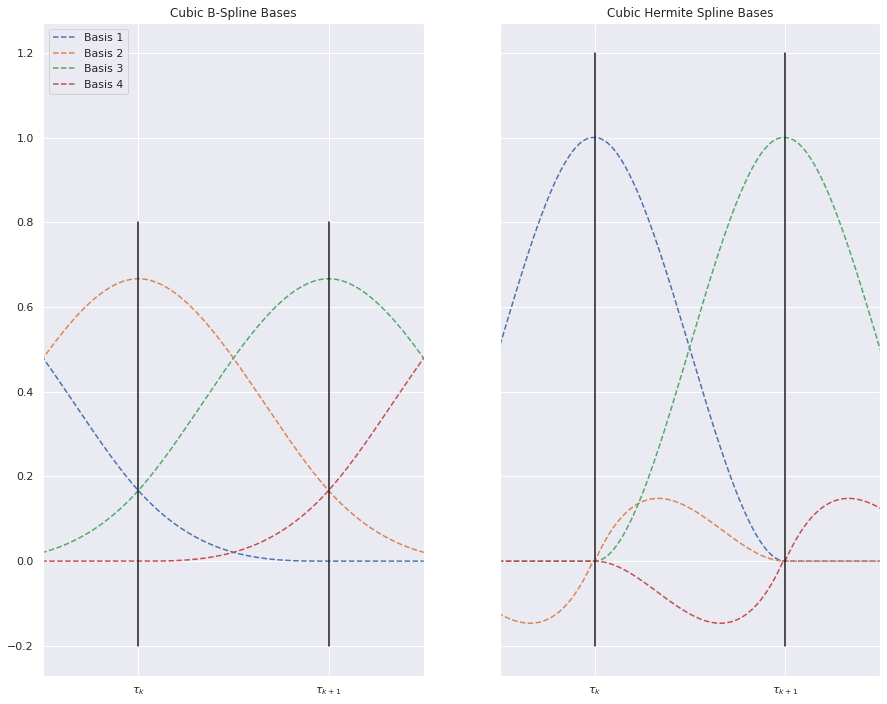

In [33]:
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].set_title('Cubic B-Spline Bases')
axs[0].plot(time, b_spline_basis[2, :].T, '--', label='Basis 1')
axs[0].plot(time, b_spline_basis[3, :].T, '--', label='Basis 2')
axs[0].plot(time, b_spline_basis[4, :].T, '--', label='Basis 3')
axs[0].plot(time, b_spline_basis[5, :].T, '--', label='Basis 4')
axs[0].legend(loc='upper left')
axs[0].plot(5 * np.ones(100), np.linspace(-0.2, 0.8, 100), 'k-')
axs[0].plot(6 * np.ones(100), np.linspace(-0.2, 0.8, 100), 'k-')
axs[0].set_xticks([5, 6])
axs[0].set_xticklabels([r'$ \tau_k $', r'$ \tau_{k+1} $'])
axs[0].set_xlim(4.5, 6.5)
axs[1].set_title('Cubic Hermite Spline Bases')
axs[1].plot(time, chsi_basis[10, :].T, '--')
axs[1].plot(time, chsi_basis[11, :].T, '--')
axs[1].plot(time, chsi_basis[12, :].T, '--')
axs[1].plot(time, chsi_basis[13, :].T, '--')
axs[1].plot(5 * np.ones(100), np.linspace(-0.2, 1.2, 100), 'k-')
axs[1].plot(6 * np.ones(100), np.linspace(-0.2, 1.2, 100), 'k-')
axs[1].set_xticks([5, 6])
axs[1].set_xticklabels([r'$ \tau_k $', r'$ \tau_{k+1} $'])
axs[1].set_xlim(4.5, 6.5)
plt.show()

Figure 17: Comparison of cubic B-spline bases versus cubic Hermite spline bases between twoarbitrary knots of uniform knot sequence.

### Cubic Hermite Spline Interpolation

There are a number of methods used to calculate the tangential parameters for CHSI curve-fitting (spline_method='chsi'). With $ t_i = \tau_k $ and $ t_j = \tau_{k+1} $ being the time points corresponding to the knot points, a common method, with low computational expense, for calculating the tangential values are:

\begin{equation}
    m_{CHSI}(\tau_k) = \frac{1}{2}\Bigg(\frac{s(t_{i+1}) - s(t_{i})}{t_{i+1} - t_{i}}+\frac{s(t_{i}) - s(t_{i-1})}{t_{i} - t_{i-1}}\Bigg),
\end{equation}

and

\begin{equation}
    m_{CHSI}(\tau_{k+1}) = \frac{1}{2}\Bigg(\frac{s(t_{j+1}) - s(t_{j})}{t_{j+1} - t_{j}}+\frac{s(t_{j}) - s(t_{j-1})}{t_{j} - t_{j-1}}\Bigg).
\end{equation}

### Akima Spline Interpolation

ASI (spline_method='asi') should be viewed as a specific case of CHSI as the bases are the same with the only difference being a defined method for calculating the tangential values. With $ t_i $ and $ t_j $ being defined as above and with:

\begin{equation}
    v(t_i) = \frac{s(t_{i+1}) - s(t_{i})}{t_{i+1} - t_{i}},
\end{equation}

the tangential values for ASI are defined as:

\begin{equation}
    m_{ASI}(\tau_k) = \frac{|v(t_{i+1}) - v(t_{i})| \times v(t_{i-1}) + |v(t_{i-1}) - v(t_{i-2})| \times v(t_{i})}{|v(t_{i+1}) - v(t_{i})| + |v(t_{i-1}) - v(t_{i-2})|},
\end{equation}

and

\begin{equation}
    m_{ASI}(\tau_{k+1}) = \frac{|v(t_{j+1}) - v(t_{j})| \times v(t_{j-1}) + |v(t_{j-1}) - v(t_{j-2})| \times v(t_{j})}{|v(t_{j+1}) - v(t_{j})| + |v(t_{j-1}) - v(t_{j-2})|}.
\end{equation}

### Recommendations for Spline Methods in AdvEMDpy Package

Cubic Hermite splines and Akima splines lack second-order continuity and as such are not assmooth as cubic B-splines. This may also lead to overfitting and the higher frequency IMFsbeing unwanted smoothed noise. In addition to using cubic B-splines interpolation method(spline_method=‘b_spline’), the user should also smooth the cubic B-splines (smooth=True)for reasons already stated in Section 6.4.

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,knot_time=knot_time,spline_method='b_spline',smooth=True,smoothing_penalty=0.1).

## 6.7. Discrete-Time Hilbert Transforms in AdvEMDpy Package

Despite B-splines having closed form solutions to the HT, discrete solutions to the HT maybe needed for a number of reasons. Here are two widely known and used methods that areincluded. The base implementation of the DTHT is as follows:

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,knot_time=knot_time,dtht=False,dtht_method='fft').

### Basic DTHT

This method (dtht_method=‘kak’) is stated and proved in Kak (1970) and is often referred toin the literature as the Basis DTHT - it is quick and accurate. The Basic DTHT is calculatedas follows:

\begin{equation}
\bar{\mathcal{H}}(X)(t[k]) \approx \begin{cases}
\sum_{n \text{ is} \text{ odd}}\dfrac{2}{\pi{(k-n)}}X(t[n]),\text{ } k  \text{ is} \text{ even}\\
\sum_{n \text{ is} \text{ even}}\dfrac{2}{\pi{(k-n)}}X(t[n]),\text{ } k  \text{ is} \text{ odd}\\
\end{cases}.
\end{equation}

### FFT DTHT

This method (dtht_method=‘fft’), which followsPythonCore Team (2019), relies on therelationship that exists between the Fourier transform and the HT. The fast-Fourier transformis performed on the time series resulting in the below:

\begin{equation}
	\bar{\mathcal{F}}(X)(k) = \sum_{n = 0}^{N - 1}e^{-2\pi{i}(\frac{kn}{N})}X(n).
\end{equation}

The inverse fast-Fourier transform is then performed on twice the positive frequency components, zero times the negative frequency components, and one times the zero frequency component. There is a slight difference in implementation when the time series is of odd or even length. When the length of the time series, $ N $, is even:

\begin{equation}
\begin{split}
	\bar{\mathcal{H}}(X)(t) &\approx \dfrac{1}{N}\sum_{n = 0}^{N - 1}X(n)\\ 
	&+ \dfrac{2}{N}\sum_{k=1}^{\frac{N}{2} - 1}e^{2\pi{i}(\frac{kn}{N})}\bar{\mathcal{F}}(X)(k)\\
	&+ \dfrac{1}{N}(-1)^n\sum_{n = 0}^{N - 1}(-1)^n{X(n)},
\end{split}
\end{equation}

and when the length, $ N $, is odd:

\begin{equation}
\begin{split}
	\bar{\mathcal{H}}(X)(t) &\approx \dfrac{1}{N}\sum_{n = 0}^{N - 1}X(n)\\ 
	&+ \dfrac{2}{N}\sum_{k=1}^{\frac{N - 1}{2}}e^{2\pi{i}(\frac{kn}{N})}\bar{\mathcal{F}}(X)(k).
\end{split}
\end{equation}

### Recommendations for Discrete-Time Hilbert Transforms in AdvEMDpy Package

A DTHT is not output by default, but should the user want a DTHT as well as the closed-form cubic B-spline HT for comparison, the FFT DTHT is recommended.  The FFT issignificantly faster than the Basic DTHT owing to the relationship that exists between theFourier transform and the HT. Despite this significant increase in computational speed, itis, however, slightly less accurate than the Basic DTHT - especially at the edges of the timeseries.

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,knot_time=knot_time,dtht=True,dtht_method='fft').

## 6.8. Knot Point Optimisations in AdvEMDpy Package

Two methods are available for the optimisation of knot point allocation. Both methods arein the bisection family of knot optimisation techniques. The first technique simply bisectsthe domain iteratively until some error bound is met. The next method is a variation on thisthat extends the domain or diminishes the domain based on some error bound. The baseimplementation of the knot point optimisation is as follows:

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,knot_time=knot_time,optimise_knots=0,knot_method='ser_bisect',knot_error=10,knot_lamda=1,knot_epsilon=0.5).

### Bisection

The bisection method (knot_method='bisection') is the most basic of knot point optimisation techniques in that, given an error term (knot_error=10), the distance between two knots is iteratively halved until the sum of absolute errors between the spline and the time series over this interval is below the error term. In Figure 18, given knot point $ \tau_k $, the next knot, $ \tau^{0}_{k+1} $, is assumed to be the end of the time series (to start the iterative process). If the error between the spline and the time series is too large the distance between the knots is halved.

The spline is fitted again with the next knot point, $ \tau^{1}_{k+1} $, and if the error is still too large, the distance is halved again. The spline is then fitted between $ \tau_k $ and $ \tau^{2}_{k+1} $. If the calculated error is below the maximum allowed error, then the iterative knot optimisation stops, $ \tau^{2}_{k+1} $ is accepted as an optimised knot point ($ \tau_{k+1} $). The knot optimisation process is repeated for $ \tau_{k+1} = \tau^{2}_{k+1} $ and $ \tau^{0}_{k+2} = \tau^{0}_{k+1} $.

![](./AdvEMDpy_paper_notebook_images/Bisection.png)

Figure 18: Diagram demonstrating bisection knot point optimisation method where distance between last accepted knot and next potential knot is continuously halved until stopping criteria satisfied.

### Serial Bisection

The serial bisection knot optimisation method (knot_method=‘ser_bisect’) is introduced inDung and Tjahjowidodo (2017). As above, the domain is bisected until the calculated error isbelow the maximum allowed error. Once the error is satisfied, however, the domain betweenpotential knot points is extended again by half the distance between the knot points. If thecalculated error is now more than the maximum error, the distance is decreased by half thedistance it was increased by previously, if the calculated error is still less than the maximumallowed error the distance is increased by half the distance it was previously increased andso forth until the distance by which the distance is increased or decreased is less than $ \epsilon $ (knot_epsilon=0.5).

![](./AdvEMDpy_paper_notebook_images/Serial_Bisection.png)

Figure 19: Diagram demonstrating serial bisection knot point optimisation method where distance between last accepted knot and next potential knot can also be increased.

Since a cubic B-spline is used to optimise the knot allocation, a $ \lambda $ value (knot_lamda=1) is used to smooth the splines that are fitted to prevent abrupt changes in the coefficients of the B-splines to accommodate the maximum allowed error. Any spline-fitting technique may be used to optimise the knot point allocation, but B-splines are used in this package.

### Recommendations for Knot Point Optimisations in AdvEMDpy Package

There are several options and combinations of options available to the user. Depending onthe length and complexity of the time series, it is advised that the algorithm is first run witha uniform set of knots (either user-defined or defaults) withoptimise_knots=0. Once thealgorithm has run without error, the user may opt for the knots to be optimised once at theoutset (optimise_knots=1). The allowed error (knot_error=10) and the allowed minimumknot placement distance (knot_epsilon=0.5) are both very time series specific and shouldbe adjusted with care. The Bisection method (knot_method=bisect) is significantly fasterthan the Serial Bisection method (knot_method=ser_bisect), but does result in slightlymore knot points. One should first run the Bisection method with one optimisation at theoutset. If one wants knots that dynamically adjust to each potential IMF, then one can useoptimise_knots=2.

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,knot_time=knot_time,optimise_knots=1,knot_method='bisect',knot_error=10,knot_lamda=1,knot_epsilon=0.5).

## 6.9. Ensemble Empirical Mode Decomposition in AdvEMDpy Package

This is a noise-assisted data analysis (NADA) technique introduced in Wu and Huang (2009)that utilises white noise.  This technique relies on the ability of the algorithm to discernconsistent structures in the presence of different sets of randomised white noise. The baseimplementation of the EEMD is implemented as follows:

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,knot_time=knot_time,ensemble=False,ensemble_sd=0.5,ensemble_iter=10).

The original time series is median filtered to approximate the original level of noise in the system. The median is removed from the time series before the standard deviation is calculated, $ \sigma_s $. The noise added to the system has a mean of zero and a standard deviation of $ \sigma_s \times \sigma_e $, where $ \sigma_e $ (ensemble_sd=0.5) is the chosen level of standard deviation in the ensemble system as a fraction of the original standard deviation in the system. The IMFs are calculated for this modified time series and stored before a new set of noise is added to the original time series and the sifting process is repeated - the procedure is repeated a predetermined number of iterations (ensemble_iter=10).

Further applications of this technique will benefit from random additions of other colours of noise such as violet noise, blue noise, pink noise, and red noise (also known as Brownian noise), which all have non-constant power spectral densities, compared with white noise that has a constant power spectral density. This technique, with the random addition of other colours of noise, is called Full Spectrum Ensemble Empirical Mode Decomposition (FSEEMD). This technique is experimental and is also included with the package in the script entitled emd_experimental.py for completeness sake.

This method performs a similar task, utilising a different methodology, to ICA-EMD, in-troduced in van Jaarsveldt, Peters, Ames, and Chantler (2021), which is finding the mostconsistent structures amongst noisy data. EEMD proceeds by introducing noise to the timeseries and isolating IMFs from the noisy time series. This task is repeated several times andIMFs are simply averaged. A more sophisticated sorting technique such as the Minimum De-scription Length Principle (introduced in Fayyad and Irani (1993)) should be used to ensurestructures of similar frequency are grouped as in van Jaarsveldtet al.(2021).  ICA-EMDproceeds by applying Independent Component Analysis (ICA) directly to all the noisy IMFsto isolate the most consistent structure, before EMD is performed on the ICA component toisolate IMFs.

### Recommendations for Ensemble Empirical Mode Decomposition in AdvEMDpy Package

This technique shows promise, but it should be implemented with care. The implementationof the EEMD method removes some additional features such as the output of coefficients,knots, as well as the DTHT and IF from the corresponding DTHT. One should apply thistechnique after applying EMD for comparison.

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=knots,knot_time=knot_time,ensemble=True,ensemble_sd=0.5,ensemble_iter=10).

# 7. Worked Examples

One would benefit from some worked examples comparingAdvEMDpyagainstPyEMD0.2.10andemd 0.3.3. In Section 7.1, a synthetic example is created using a specific caseof the Duffing equation as provided in Huanget al.(1998) to demonstrate using these scriptshow to arrive at the desired output. The accuracy of the three methods is quantitativelycompared by calculating the absolute deviations of the second IMFs extracted using eachmethod with the underlying driving function.In Section 7.2, a well-known real-world data set is used to demonstrate how EMD canbe applied to real-world data.  The knot sequence would need to be appropriately con-structed. Should the data (unlike the Carbon Dioxide data) be noisy, some preprocessing(Section 6.2) may be appropriate or one would benefit by not performing initial smoothing(initial_smoothing=False) as all the noise would be captured in a nonsensical first IMF.As there is no true underlying IMF structure as in Section 7.1, the three methods are com-pared by measuring how accurately the instantaneous frequencies of each method replicatethe underlying annual structure.

## 7.1. Synthetic Example

The motion of a mass attached to a frictionless spring in a vacuum that is perturbed slightlyis governed by:

\begin{equation} \label{spring}
    \frac{d^2x(t)}{dt^2} + {\omega}x(t) = 0,
\end{equation}

with $ \omega^2 $ (squared by convention) being the constant natural frequency of the system and $ 0 $ being the driving force of the system - it oscillates about zero. A specific Duffing equation is governed by:

\begin{equation} \label{Duffing_equation}
    \frac{d^2x(t)}{dt^2} + \Big(1 - x^2(t)\Big)x(t) = \frac{1}{10}\text{cos}\bigg(\frac{1}{25}2{\pi}t\bigg),
\end{equation}

with the natural frequency of the system being a function of the displacement and the driving force of the system no longer being zero. This creates a more complex system than a simple sinusoid (solution to Equation (103)) - the displacement and velocity can be viewed in Figure 20. The simple script below can be used to produce Figure 20. For further details on how to reproduce this figure, and all others in this section, one can see jss_figures_replication_script.py and Worked_examples.ipynb.

# Figure 20

In [34]:
def duffing_equation(xy, ts):
    gamma = 0.1
    epsilon = 1
    omega = ((2 * np.pi) / 25)
    return [xy[1], xy[0] - epsilon * xy[0] ** 3 + gamma * np.cos(omega * ts)]


t = np.linspace(0, 150, 1501)
XY0 = [1, 1]
solution = odeint(duffing_equation, XY0, t)
x = solution[:, 0]
dxdt = solution[:, 1]

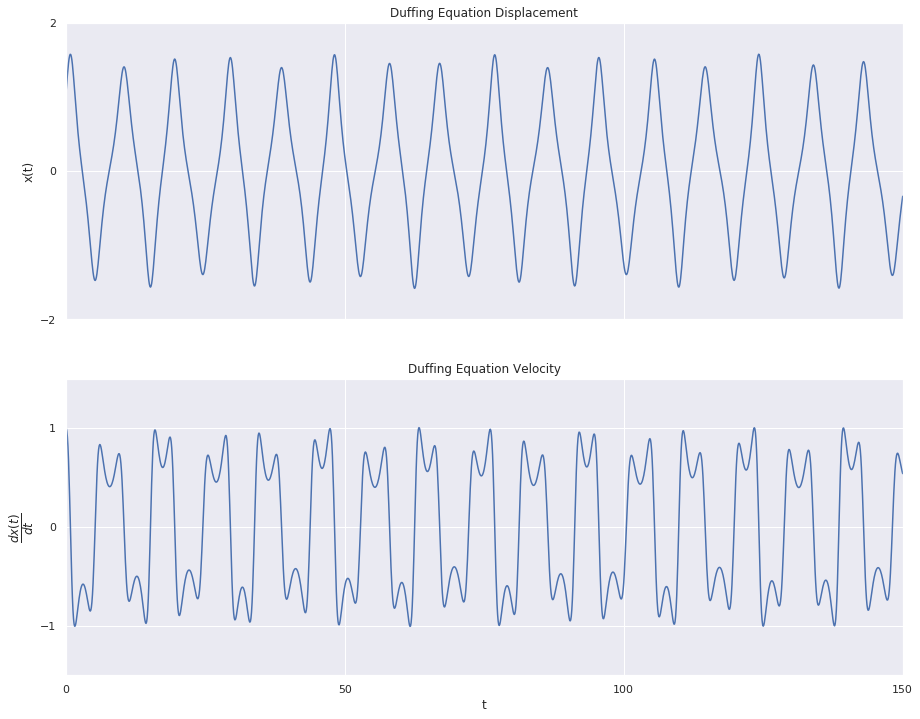

In [35]:
x_points = [0, 50, 100, 150]
x_names = {0, 50, 100, 150}
y_points_1 = [-2, 0, 2]
y_points_2 = [-1, 0, 1]

fig, axs = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.2)
axs[0].plot(t, x)
axs[0].set_title('Duffing Equation Displacement')
axs[0].set_ylim([-2, 2])
axs[0].set_xlim([0, 150])

axs[1].plot(t, dxdt)
axs[1].set_title('Duffing Equation Velocity')
axs[1].set_ylim([-1.5, 1.5])
axs[1].set_xlim([0, 150])

axis = 0
for ax in axs.flat:
    ax.label_outer()
    if axis == 0:
        ax.set_ylabel('x(t)')
        ax.set_yticks(y_points_1)
    if axis == 1:
        ax.set_ylabel(r'$ \dfrac{dx(t)}{dt} $')
        ax.set(xlabel='t')
        ax.set_yticks(y_points_2)
    ax.set_xticks(x_points)
    ax.set_xticklabels(x_names)
    axis += 1
plt.rcParams['figure.figsize'] = [15, 12]
plt.show()

Figure 20: Figure demonstrating Duffing equation (Equation (104)) displacement and velocity for $ t \in [0, 150] $.

In a frictionless environment, the total energy of the system is completely determined by the initial conditions of $ x(0) = 1 $ and $ \frac{dx(0)}{dt} = 1 $. The Hamiltonian frequency of the system (in the absence of a driving function) can be shown to be $ f = 0.124Hz $. This, as well as the frequency of the driving function, $ f = 0.04Hz $, can be seen in Figure 22, Figure 23, and Figure 24. One can extract the IMFs from the structure using the code below.

In Figure 21 one can see how accurately the second IMF structure extracted captures theforcing function in the Duffing equation. For comparison, IMF 1 and IMF 2 extracted using PyEMD 0.2.10 and emd 0.3.3 are also plotted. The various methods are also quantitativelycompared by measuring the sum of absolute differences between the second IMFs of eachmethod against the true underlying driving function, the errors are tabulated below:

\begin{equation} \label{eq: imf_error_compare}
\begin{split}
    \sum_{i=0}^{1500}\bigg|IMF^{emd}_{2}(t_i) - 0.1\text{cos}(0.08\pi(t_i))\bigg| &= 21.434\\
    \sum_{i=0}^{1500}\bigg|IMF^{PyEMD}_{2}(t_i) - 0.1\text{cos}(0.08\pi(t_i))\bigg| &= 20.774\\
    \sum_{i=0}^{1500}\bigg|IMF^{AdvEMDpy}_{2}(t_i) - 0.1\text{cos}(0.08\pi(t_i))\bigg| &= 15.978,
\end{split}
\end{equation}

with $ IMF^k_j(t_i) $ being IMF $ j $ isolated using method $ k $ at time point $ t_i $. From Equation (105) it can be seen that \textbf{AdvEMDpy} most closely captures the underlying driving function.

In [36]:
pyemd = pyemd0215()
py_emd = pyemd(x)

emd_sift = emd040.sift.sift(x)

emd_duffing = AdvEMDpy.EMD(time=t, time_series=x)
emd_duff, emd_ht_duff, emd_if_duff, _, _, _, _ = emd_duffing.empirical_mode_decomposition(verbose=False)

In [37]:
print(f'emd 0.3.3:    {round(sum(abs(0.1 * np.cos(0.04 * 2 * np.pi * t) - emd_sift[:, 1])), 3)}')
print(f'PyEMD 0.2.10: {round(sum(abs(0.1 * np.cos(0.04 * 2 * np.pi * t) - py_emd[1, :])), 3)}')
print(f'AdvEMDpy:     {round(sum(abs(0.1 * np.cos(0.04 * 2 * np.pi * t) - emd_duff[2, :])), 3)}')

emd 0.3.3:    21.434
PyEMD 0.2.10: 20.774
AdvEMDpy:     15.978


# Figure 21

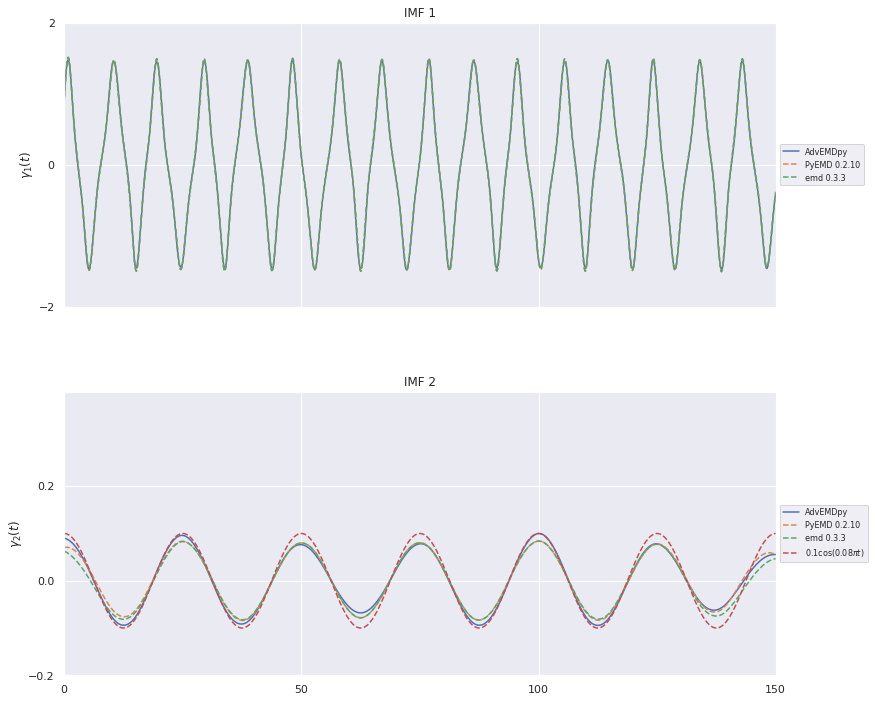

In [38]:
fig, axs = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.3)
axs[0].plot(t, emd_duff[1, :], label='AdvEMDpy')
axs[0].plot(t, py_emd[0, :], '--', label='PyEMD 0.2.10')
axs[0].plot(t, emd_sift[:, 0], '--', label='emd 0.3.3')
axs[0].set_title('IMF 1')
axs[0].set_ylim([-2, 2])
axs[0].set_xlim([0, 150])

axs[1].plot(t, emd_duff[2, :], label='AdvEMDpy')
axs[1].plot(t, py_emd[1, :], '--', label='PyEMD 0.2.10')
axs[1].plot(t, emd_sift[:, 1], '--', label='emd 0.3.3')
axs[1].plot(t, 0.1 * np.cos(0.04 * 2 * np.pi * t), '--', label=r'$0.1$cos$(0.08{\pi}t)$')
axs[1].set_title('IMF 2')
axs[1].set_ylim([-0.2, 0.4])
axs[1].set_xlim([0, 150])

axis = 0
for ax in axs.flat:
    ax.label_outer()
    if axis == 0:
        ax.set_ylabel(r'$\gamma_1(t)$')
        ax.set_yticks([-2, 0, 2])
    if axis == 1:
        ax.set_ylabel(r'$\gamma_2(t)$')
        ax.set_yticks([-0.2, 0, 0.2])
    box_0 = ax.get_position()
    ax.set_position([box_0.x0, box_0.y0, box_0.width * 0.85, box_0.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    ax.set_xticks(x_points)
    ax.set_xticklabels(x_names)
    axis += 1
plt.rcParams['figure.figsize'] = [15, 12]
plt.show()

Figure 21: Figure demonstrating the first three IMFs extracted from Duffing equation dis-placement along with driving force equation displayed alongside IMF 2.

The Hilbert spectrum in Figure 24 captures the complex frequency structures present farmore accurately than the STFT or MWT. The Hilbert spectrum can be calculated using thefollowing code.

For completeness, the Hilbert spectrum of the other two methods can be obtained by usingthe following code. One can note that in addition to the increased accuracy ofAdvEMDpyin resolving the underlying driving function, the resolution of the driving function in theHilbert spectrum of Figure 24 is not nearly as obscured by the instantaneous frequency of thefirst IMF as in Figure 22 and Figure 23.

# Figure 22

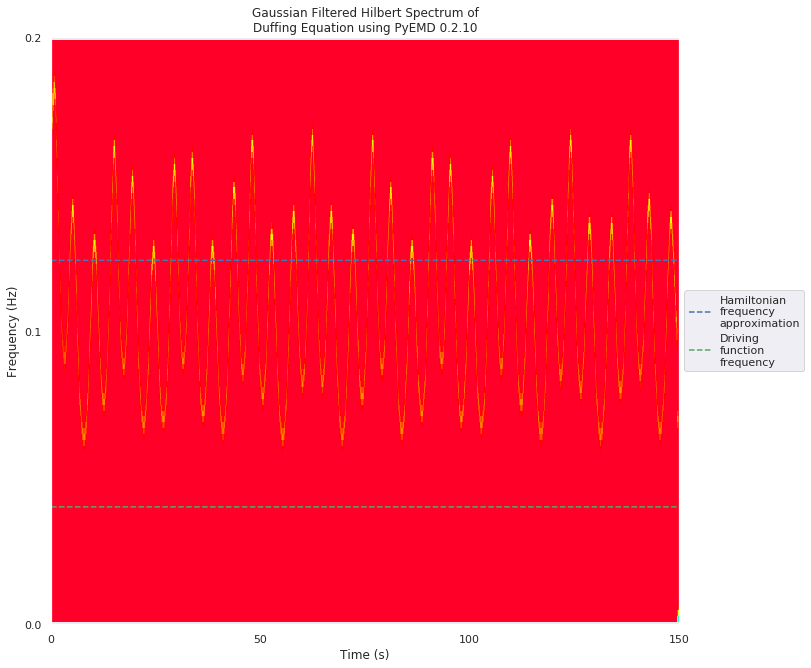

In [39]:
IP, IF, IA = emd040.spectra.frequency_transform(py_emd.T, 10, 'hilbert')
freq_edges, freq_bins = emd040.spectra.define_hist_bins(0, 0.2, 100)
hht = emd040.spectra.hilberthuang(IF, IA, freq_edges)
hht = gaussian_filter(hht, sigma=1)
ax = plt.subplot(111)
plt.title(textwrap.fill('Gaussian Filtered Hilbert Spectrum of Duffing Equation using PyEMD 0.2.10', 40))
plt.pcolormesh(t, freq_bins, hht, cmap='gist_rainbow', vmin=0, vmax=np.max(np.max(np.abs(hht))))
plt.plot(t[:-1], 0.124 * np.ones_like(t[:-1]), '--', label=textwrap.fill('Hamiltonian frequency approximation', 15))
plt.plot(t[:-1], 0.04 * np.ones_like(t[:-1]), 'g--', label=textwrap.fill('Driving function frequency', 15))
plt.xticks([0, 50, 100, 150])
plt.yticks([0, 0.1, 0.2])
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

box_0 = ax.get_position()
ax.set_position([box_0.x0, box_0.y0 + 0.05, box_0.width * 0.75, box_0.height * 0.9])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.rcParams['figure.figsize'] = [15, 12]
plt.show()

Figure 22: Hilbert spectrum of Duffing equation IMFs usingPyEMD 0.2.10.

# Figure 23

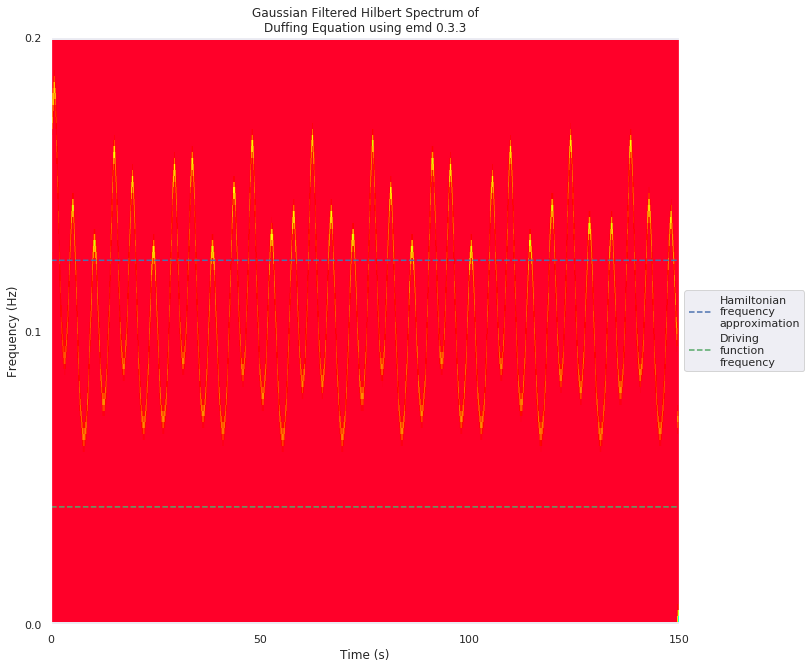

In [40]:
IP, IF, IA = emd040.spectra.frequency_transform(emd_sift, 10, 'hilbert')
freq_edges, freq_bins = emd040.spectra.define_hist_bins(0, 0.2, 100)
hht = emd040.spectra.hilberthuang(IF, IA, freq_edges)
hht = gaussian_filter(hht, sigma=1)
ax = plt.subplot(111)
plt.title(textwrap.fill('Gaussian Filtered Hilbert Spectrum of Duffing Equation using emd 0.3.3', 40))
plt.pcolormesh(t, freq_bins, hht, cmap='gist_rainbow', vmin=0, vmax=np.max(np.max(np.abs(hht))))
plt.plot(t[:-1], 0.124 * np.ones_like(t[:-1]), '--', label=textwrap.fill('Hamiltonian frequency approximation', 15))
plt.plot(t[:-1], 0.04 * np.ones_like(t[:-1]), 'g--', label=textwrap.fill('Driving function frequency', 15))
plt.xticks([0, 50, 100, 150])
plt.yticks([0, 0.1, 0.2])
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

box_0 = ax.get_position()
ax.set_position([box_0.x0, box_0.y0 + 0.05, box_0.width * 0.75, box_0.height * 0.9])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.rcParams['figure.figsize'] = [15, 12]
plt.show()

Figure 23: Hilbert spectrum of Duffing equation IMFs using emd 0.3.3.

# Figure 24

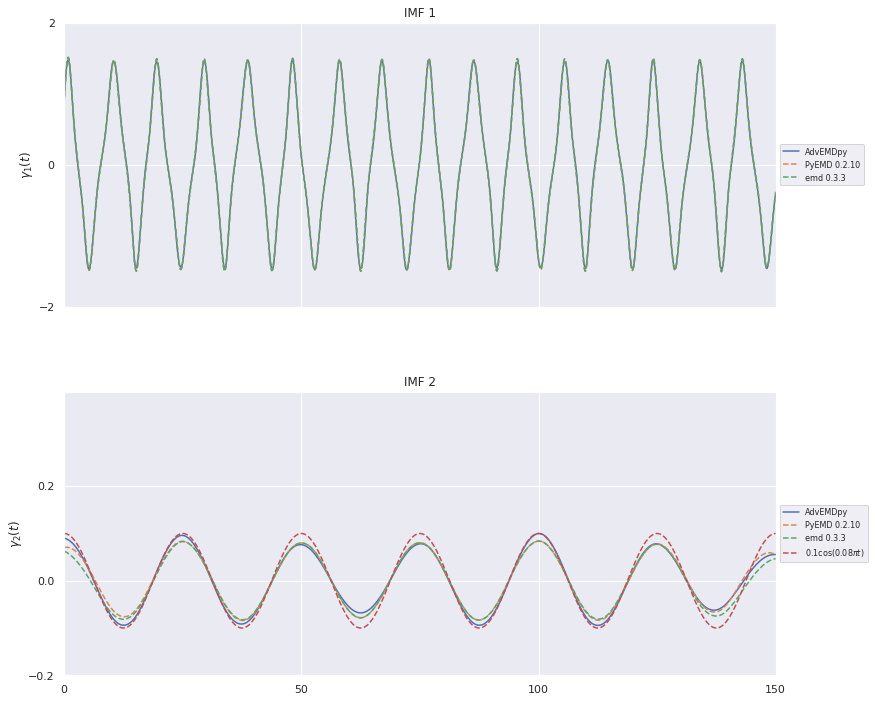

In [41]:
fig, axs = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.3)
axs[0].plot(t, emd_duff[1, :], label='AdvEMDpy')
axs[0].plot(t, py_emd[0, :], '--', label='PyEMD 0.2.10')
axs[0].plot(t, emd_sift[:, 0], '--', label='emd 0.3.3')
axs[0].set_title('IMF 1')
axs[0].set_ylim([-2, 2])
axs[0].set_xlim([0, 150])

axs[1].plot(t, emd_duff[2, :], label='AdvEMDpy')
axs[1].plot(t, py_emd[1, :], '--', label='PyEMD 0.2.10')
axs[1].plot(t, emd_sift[:, 1], '--', label='emd 0.3.3')
axs[1].plot(t, 0.1 * np.cos(0.04 * 2 * np.pi * t), '--', label=r'$0.1$cos$(0.08{\pi}t)$')
axs[1].set_title('IMF 2')
axs[1].set_ylim([-0.2, 0.4])
axs[1].set_xlim([0, 150])

axis = 0
for ax in axs.flat:
    ax.label_outer()
    if axis == 0:
        ax.set_ylabel(r'$\gamma_1(t)$')
        ax.set_yticks([-2, 0, 2])
    if axis == 1:
        ax.set_ylabel(r'$\gamma_2(t)$')
        ax.set_yticks([-0.2, 0, 0.2])
    box_0 = ax.get_position()
    ax.set_position([box_0.x0, box_0.y0, box_0.width * 0.85, box_0.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    ax.set_xticks(x_points)
    ax.set_xticklabels(x_names)
    axis += 1
plt.rcParams['figure.figsize'] = [15, 12]
plt.show()

Figure 24: Hilbert spectrum of Duffing equation IMFs using AdvEMDpy with frequency ofdriving force equation visible despite being of lower intensity.

## 7.2. Real-World Example

One would benefit from an example applied to real-world data. The following well-knowndata set is from Tans and Keeling (2020) to demonstrate the effectiveness of AdvEMDpy over PyEMD 0.2.10 and emd 0.3.3. One can see the transient nature of the data in Figure25 which hinders analysis using base-level applications of PyEMD 0.2.10 and emd 0.3.3.One can replicate Figure 25 using the below code.

# Figure 25

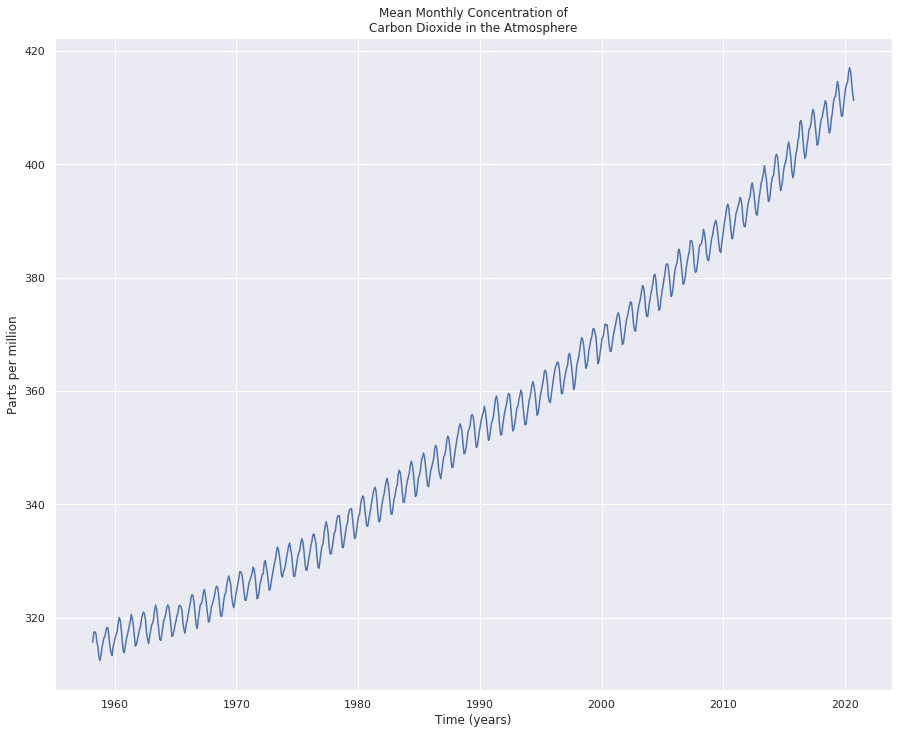

In [42]:
CO2_data = pd.read_csv('../Data/co2_mm_mlo.csv', header=51)

plt.plot(CO2_data['month'], CO2_data['decimal date'])
plt.title(textwrap.fill('Mean Monthly Concentration of Carbon Dioxide in the Atmosphere', 35))
plt.ylabel('Parts per million')
plt.xlabel('Time (years)')
plt.rcParams['figure.figsize'] = [15, 12]
plt.show()

signal = CO2_data['decimal date']
signal = np.asarray(signal)
time = CO2_data['month']
time = np.asarray(time)

Figure 25: Monthly mean atmospheric concentration of Carbon Dioxide in parts per millionfrom March 1958 until September 2020.

One can apply EMD to the time series with the following code:

co2_knots = np.linspace(co2_time[0], co2_time[-1], 200)

emd = EMD(time=co2_time, time_series=co2_time_series)

imfs, hts, ifs = emd.empirical_mode_decomposition(knots=co2_knots,knot_time=co2_time)

and plotting the resulting outputs, one will arrive at Figure 26.  The number of knots isincreased above the base-level application to accurately capture the annual cycle. The originaltime series is plotted as well as the smoothed version of the time series. A single IMF hasbeen extracted as well as a residual after the original time series was smoothed.

# Figure 26

../AdvEMDpy.py:1191: UserWarning: Recommended knots are subset of knot time points for discontinuity issues.
  warnings.warn('Recommended knots are subset of knot time points for discontinuity issues.')


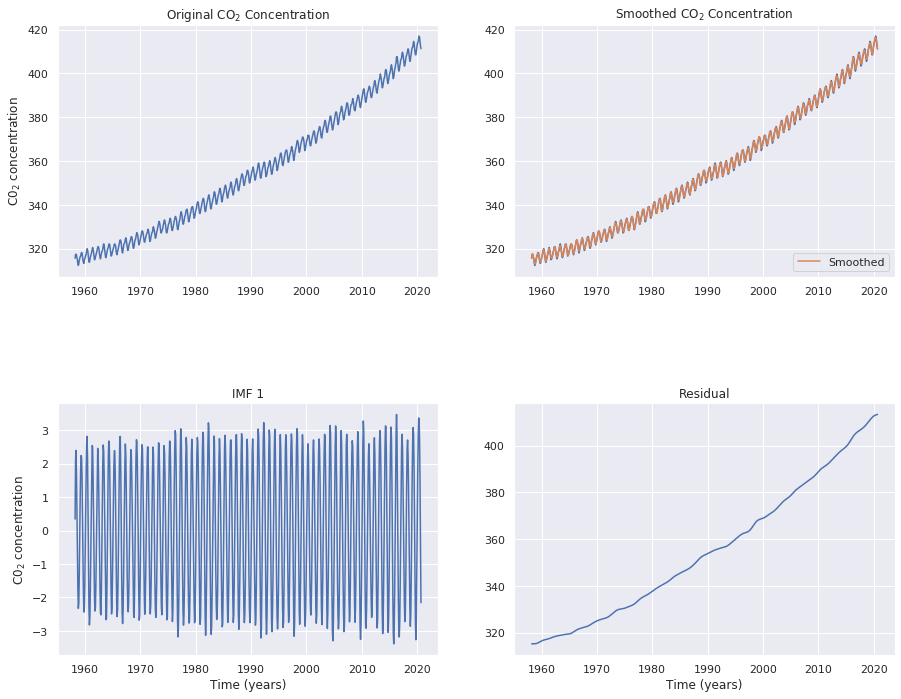

In [43]:
knots = np.linspace(time[0], time[-1], 200)
emd_example = AdvEMDpy.EMD(time=time, time_series=signal)
imfs, hts, ifs, _, _, _, _ = emd_example.empirical_mode_decomposition(knots=knots, knot_time=time, verbose=False)

fig, axs = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.5)
axs[0, 0].plot(time, signal)
axs[0, 1].plot(time, signal)
axs[0, 1].plot(time, imfs[0, :], label='Smoothed')
axs[0, 1].legend(loc='lower right')
axs[1, 0].plot(time, imfs[1, :])
axs[1, 1].plot(time, imfs[2, :])

axis = 0
for ax in axs.flat:
    if axis == 0:
        ax.set(ylabel=R'C0$_2$ concentration')
    if axis == 1:
        pass
    if axis == 2:
        ax.set(ylabel=R'C0$_2$ concentration')
        ax.set(xlabel='Time (years)')
    if axis == 3:
        ax.set(xlabel='Time (years)')
    axis += 1

plt.gcf().subplots_adjust(bottom=0.15)

axs[0, 0].set_title(r'Original CO$_2$ Concentration')
axs[0, 1].set_title('Smoothed CO$_2$ Concentration')
axs[1, 0].set_title('IMF 1')
axs[1, 1].set_title('Residual')

plt.gcf().subplots_adjust(bottom=0.15)
plt.rcParams['figure.figsize'] = [15, 12]
plt.show()

Figure 26: EMD of monthly mean Carbon Dioxide concentration in parts per million fromMarch 1958 until September 2020.

To plot the Hilbert spectrum, as seen in Figure 29, one can implement the following code:

x_hs, y, z = hilbert_spectrum(time, imfs, hts, ifs,max_frequency=10, which_imfs=[1],plot=False)

y = y / (2 * np.pi)

fig, ax = plt.subplots()

ax.pcolormesh(x_hs, y, np.abs(z), cmap='gist_rainbow',vmin=0, vmax=np.abs(z).max())

The accuracy ofAdvEMDpyversusPyEMD 0.2.10andemd 0.3.3in the resolution ofthe annual structure can be seen in Equation (106).

\begin{equation} \label{eq: error_compare}
\begin{split}
    \sum_{i=0}^{750}\bigg|IF^{PyEMD}_{1}(t_i) - 1\bigg| &= 181.076\\
    \sum_{i=0}^{750}\bigg|IF^{emd}_{1}(t_i) - 1\bigg| &= 174.047\\
    \sum_{i=0}^{750}\bigg|IF^{AdvEMDpy}_{1}(t_i) - 1\bigg| &= 37.616,
\end{split}
\end{equation}

with $ IF^{k}_j(t_i) $ being the instantaneous frequency of IMF $ j $ using method $ k $ at time point $ t_i $. The annual cycle is most accurately resolved in Figure 29 compared against Figure 27 and Figure 28. To reproduce Figure 27 one can implement the code below. 

pyemd = pyemd0215()

py_emd = pyemd(signal)

IP, IF, IA = emd040.spectra.frequency_transform(py_emd[:2, :].T,12,'hilbert')

freq_edges, freq_bins = emd040.spectra.define_hist_bins(0, 2, 100)

hht = emd040.spectra.hilberthuang(IF, IA, freq_edges)

hht = gaussian_filter(hht, sigma=1)

fig, ax = plt.subplots()

plt.pcolormesh(time, freq_bins, hht, cmap='gist_rainbow',vmin=0, vmax=np.max(np.max(np.abs(hht))))

# Figure 27

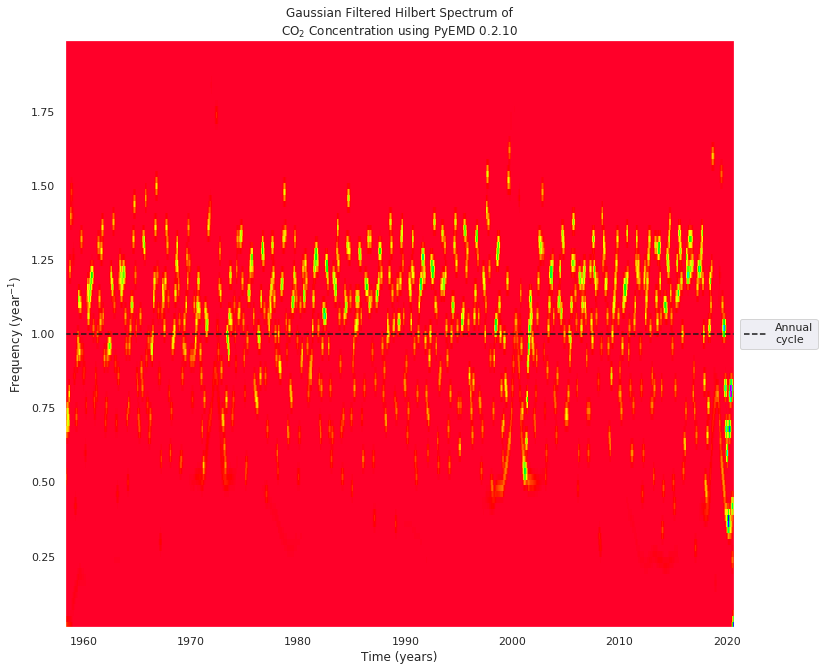

In [44]:
pyemd = pyemd0215()
py_emd = pyemd(signal)
IP, IFpyemd, IA = emd040.spectra.frequency_transform(py_emd[:2, :].T, 12, 'hilbert')
freq_edges, freq_bins = emd040.spectra.define_hist_bins(0, 2, 100)
hht = emd040.spectra.hilberthuang(IFpyemd, IA, freq_edges)
hht = gaussian_filter(hht, sigma=1)
fig, ax = plt.subplots()
plt.title(textwrap.fill('Gaussian Filtered Hilbert Spectrum of CO$_{2}$ Concentration using PyEMD 0.2.10', 45))
plt.ylabel('Frequency (year$^{-1}$)')
plt.xlabel('Time (years)')
plt.pcolormesh(time, freq_bins, hht, cmap='gist_rainbow', vmin=0, vmax=np.max(np.max(np.abs(hht))))
plt.plot(time, np.ones_like(time), 'k--', label=textwrap.fill('Annual cycle', 10))
box_0 = ax.get_position()
ax.set_position([box_0.x0 + 0.0125, box_0.y0 + 0.075, box_0.width * 0.8, box_0.height * 0.9])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.rcParams['figure.figsize'] = [15, 12]
plt.show()

Figure 27: HT of monthly mean Carbon Dioxide concentration in parts per million fromMarch 1958 until September 2020 using PyEMD 0.2.10.

To reproduce Figure 28 one can implement the code below. By comparing Figure 27 andFigure 28 against Figure 29 and by comparing the equalities in Equation (106), one can notethe increased resolution power ofAdvEMDpyoverPyEMD 0.2.10 and emd 0.3.3.

emd_sift = emd040.sift.sift(signal)

IP, IF, IA = emd040.spectra.frequency_transform(emd_sift[:, :1],12,'hilbert')

freq_edges, freq_bins = emd040.spectra.define_hist_bins(0, 2, 100)

hht = emd040.spectra.hilberthuang(IF, IA, freq_edges)

hht = gaussian_filter(hht, sigma=1)

fig, ax = plt.subplots()

plt.pcolormesh(time, freq_bins, hht, cmap='gist_rainbow',vmin=0, vmax=np.max(np.max(np.abs(hht))))

# Figure 28

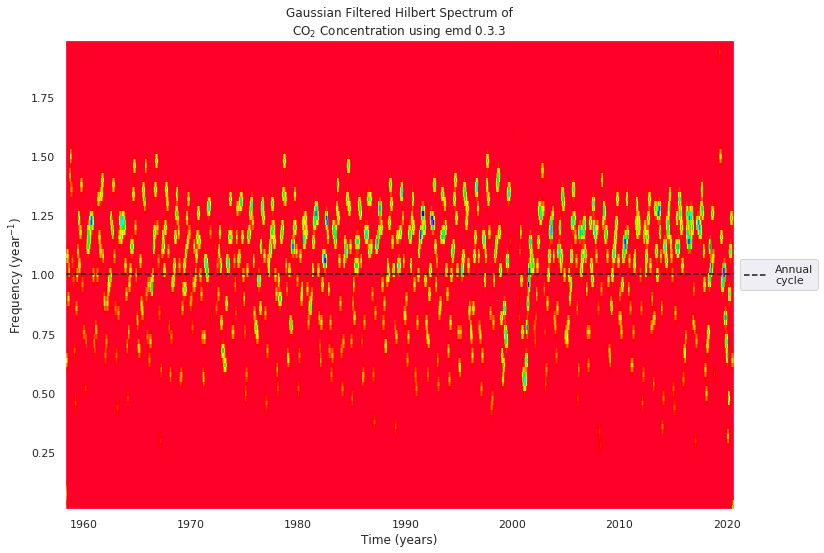

In [46]:
emd_sift = emd040.sift.sift(signal)
IP, IF, IA = emd040.spectra.frequency_transform(emd_sift[:, :1], 12, 'hilbert')
freq_edges, freq_bins = emd040.spectra.define_hist_bins(0, 2, 100)
hht = emd040.spectra.hilberthuang(IF, IA, freq_edges)
hht = gaussian_filter(hht, sigma=1)
fig, ax = plt.subplots()
figure_size = plt.gcf().get_size_inches()
factor = 0.8
plt.gcf().set_size_inches((figure_size[0], factor * figure_size[1]))
plt.title(textwrap.fill('Gaussian Filtered Hilbert Spectrum of CO$_{2}$ Concentration using emd 0.3.3', 45))
plt.ylabel('Frequency (year$^{-1}$)')
plt.xlabel('Time (years)')
plt.pcolormesh(time, freq_bins, hht, cmap='gist_rainbow', vmin=0, vmax=np.max(np.max(np.abs(hht))))
plt.plot(time, np.ones_like(time), 'k--', label=textwrap.fill('Annual cycle', 10))
box_0 = ax.get_position()
ax.set_position([box_0.x0 + 0.0125, box_0.y0 + 0.075, box_0.width * 0.8, box_0.height * 0.9])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Figure 28: HT of monthly mean Carbon Dioxide concentration in parts per million fromMarch 1958 until September 2020 using emd 0.3.3.

In van Jaarsveldtet al. (2021), the resolution of EMD is improved even further by augmentingEMD with X11 and forming the new technique known as EMD-X11. X11 is a simpler trendfiltering technique that functions as a post-processing technique in this setting that improvesthe resolution power of EMD. This will be included in a later version of the software alongwith many other novel contributions to the field.

# Figure 29

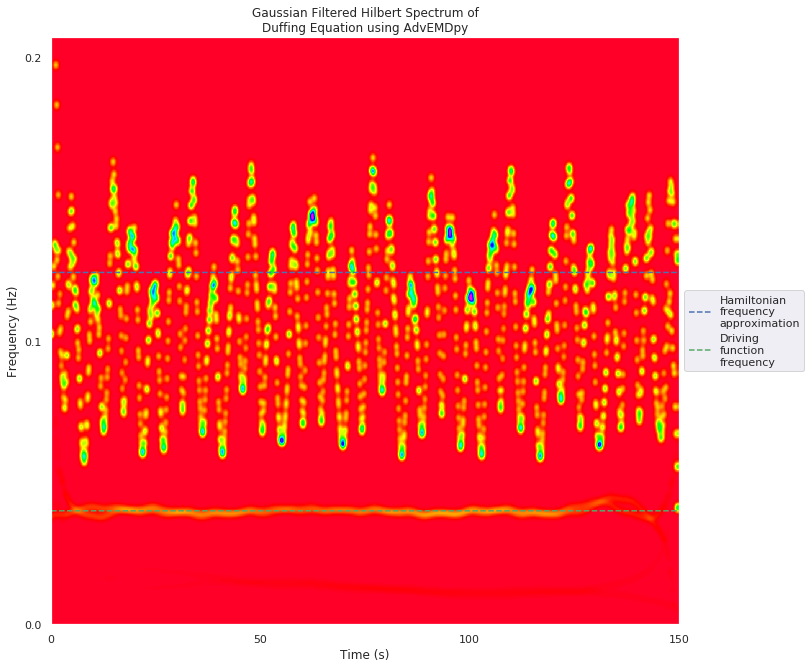

In [47]:
hs_ouputs = hilbert_spectrum(t, emd_duff, emd_ht_duff, emd_if_duff, max_frequency=1.3, plot=False)

ax = plt.subplot(111)
plt.title(textwrap.fill('Gaussian Filtered Hilbert Spectrum of Duffing Equation using AdvEMDpy', 40))
x_hs, y, z = hs_ouputs
y = y / (2 * np.pi)
z_min, z_max = 0, np.abs(z).max()
ax.pcolormesh(x_hs, y, np.abs(z), cmap='gist_rainbow', vmin=z_min, vmax=z_max)
plt.plot(t[:-1], 0.124 * np.ones_like(t[:-1]), '--', label=textwrap.fill('Hamiltonian frequency approximation', 15))
plt.plot(t[:-1], 0.04 * np.ones_like(t[:-1]), 'g--', label=textwrap.fill('Driving function frequency', 15))
plt.xticks([0, 50, 100, 150])
plt.yticks([0, 0.1, 0.2])
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

box_0 = ax.get_position()
ax.set_position([box_0.x0, box_0.y0 + 0.05, box_0.width * 0.75, box_0.height * 0.9])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.rcParams['figure.figsize'] = [15, 12]
plt.show()

Figure 29: HT of monthly mean Carbon Dioxide concentration in parts per million fromMarch 1958 until September 2020 using AdvEMDpy.

# Conclusion

AdvEMDpyseeks to provide customisability not present in other available EMD packagesboth withinPythonand across other programming languages such asRandMATLAB. Pre-processing of time series is sorely neglected in other packages, which is addressed in Section6.2 with future developments in Compressive Sampling EMD falling in this section and ad-dressed inemd_experimental.pyandexperimental.ipynb. The edge effect, which is themost ubiquitous problem in all of time series analysis, is also given a rather scant treatmentin other packages. Four separate families of techniques are reviewed thoroughly in Section6.3 with many others to follow.  The approximation of the local mean structure throughdetrended fluctuation analysis is also given a very brief treatment in other packages. Thispaper and package seek to formalise the treatment, as well as, introduce several modern viablealternatives such as Inflection Point Interpolation and Binomial Average Interpolation whichare presented in Section 6.4.

Several stopping criteria and spline choices are provided with most of these also being avail-able in other packages. Stopping criteria and splines are addressed in Section 6.5 and Section6.6, respectively. Most recent developments in EMD have been focused on edge effects and de-trended fluctuation analysis. Stopping criteria all try to prevent over-sifting, whereas splinechoices attempt to arrive at a desirable trade-off between accuracy and over-fitting. Knotoptimisation has not been addressed in other packages and provides valuable new insightinto spline choices and over-fitting and is addressed in Section 6.8. In addition to the stableviable options available in the package, Full-Spectrum Ensemble EMD (FSEEMD) (an ex-tension of EEMD discussed in Section 6.9) and Compressive Sampling EMD (CSEMD) are briefly discussed with demonstrative examples being shown inemd_experimental.pyandexperimental.ipynb.

This package is intended for both new users of EMD and advanced users who have experiencewith these decomposition and analysis algorithms.  Several simple scripts are included inthis paper, as well as injss_figures_replication_script.pyand the Jupyter Notebooksincluded with this package. In both Section 7.1 and Section 7.2AdvEMDpyis shown toexceedPyEMD 0.2.10andemd 0.3.3. In Section 7.1,AdvEMDpyis shown to moreaccurately resolve the underlying driving function that drives the dynamic equilibrium ofthe system. Finally, in Section 7.2,AdvEMDpyis shown to significantly exceed the othermethods in resolving the instantaneous frequency of the annual underlying cycle. This packagewill benefit many users, both those new to EMD and those experienced in the interrelatedfields of EMD, time series analysis, detrended fluctuation analysis, and time series filteringand graduation.

# References

Bianconcini S (2006). Trend-Cycle Estimation in Reproducing Kernel Hilbert Spaces. Ph.D.
thesis, Department of Statistics, University of Bologna, Bologna.

Bowman A, Evers L (2017). “Nonparametric Smoothing Lecture Notes.” Technical report, The
University of Glasgow, Glasgow. URL https://warwick.ac.uk/fac/sci/statistics/
apts/students/resources-1314/ns_notes.pdf.

Campi M, Peters G, Azzaoui N, Matsui T (2021). “Machine Learning Mitigants for Speech
Based Cyber Risk.” IEEE Access. doi:10.1109/ACCESS.2021.3117080.

Candès E (2006). “Compressive Sampling.” In M Sanz-Solé, J Soria, J Varona, J Verdera
(eds.), Proceedings of the International Congress of Mathematicians, volume 3, pp.
1433–1452. European Mathematical Society, European Mathematical Society Publishing,
Madrid. doi:10.4171/022-3/69.

Candès E, Romberg J, Tao T (2006). “Robust Uncertainty Principles: Exact Signal Recon-
struction from Highly Incomplete Frequency Information.” IEEE Transactions on Infor-
mation Theory, 52(2), 489–509. doi:10.1109/TIT.2005.862083.

Candès E, Wakin M (2008). “An Introduction to Compressive Sampling.” IEEE Signal
Processing Magazine, 25(2), 21–30. doi:10.1109/MSP.2007.914731.

Chen Q, Huang N, Riemenschneider S, Xu Y (2006). “A B-spline Approach for Empirical
Mode Decompositions.” Advances in Computational Mathematics, 24(1-4), 171–195. doi:
10.1007/s10444-004-7614-3.

Chiew F, Peel M, Amirthanathan G, Pegram G (2005). “Identification of oscillations in
historical global streamflow data using empirical mode decomposition.” In S Franks,
T Wagener, E Bøgh, H Gupta, L Bastidas, C Nobre, C Galvão (eds.), Regional Hy-
drological Impacts of Climatic Change - Hydroclimatic Variabiltiy, volume 296, pp. 53–62. 
International Association of Hydrological Sciences. ISBN 1901502139. URL https://www.cabdirect.org/cabdirect/abstract/20053083220.

Coughlin K, Tung K (2004). “11-Year solar cycle in the stratosphere extracted by the em-
pirical mode decomposition method.” Advances in Space Research, 34(2), 323–329. doi:
10.1016/j.asr.2003.02.045.

Craven P, Wahba G (1978). “Smoothing Noisy Data with Spline Functions.” Numerische
mathematik, 31(4), 377–403. doi:10.1007/BF01404567.

Crochiere R, Rabiner L (1983). “Multirate Digital Signal Processing.” In A Oppenheim
(ed.), Prentice-Hall Signal Processing Series: Advanced Monographs. Prentice-Hall, Inc.,
Englewood Cliffs, New Jersey, SA. ISBN 0136051626. URL https://books.google.co.
uk/books?id=X_NSAAAAMAAJ.

Dagum E, Bianconcini S (2006). “Local Polynomial Trend-Cycle Predictors in Reproducing
Kernel Hilbert Spaces for Current Economic Analysis.” In Anales de Economia Aplicada,
pp. 1–16.

Dagum E, Bianconcini S (2008). “The Henderson Smoother in Reproducing Kernel Hilbert
Space.” Journal of Business & Economic Statistics, 26(4), 536–545. doi:10.1198/
073500107000000322.

Dätig M, Schlurmann T (2004). “Performance and limitations of the Hilbert-Huang transfor-
mation (HHT) with an application to irregular water waves.” Ocean Engineering, 31(14-15),
1783–1834. doi:10.1016/j.oceaneng.2004.03.007.

de Boor C (1978). A Practical Guide to Splines, volume 27 of Applied Mathematical Sciences.
Springer-Verlag, New York, USA. ISBN 0387903569. doi:10.2307/2006241.

De Forest E (1877). “On Adjustment Formulas.” The Analyst, 4(3), 79–86. doi:10.2307/
2636257.

Deering R, Kaiser J (2005). “The Use of a Masking Signal to Improve Empirical Mode
Decomposition.” In Proceedings of IEEE International Conference on Acoustics, Speech,
and Signal Processing (ICASSP ’05), volume 4, pp. 485–488. IEEE. doi:10.1109/ICASSP.
2005.1416051.

Deng Y, Wang W, Qian C, Wang Z, Dai D (2001). “Boundary-processing-technique in EMD
method and Hilbert transform.” Chinese Science Bulletin, 46(1), 954–960. doi:10.1007/
BF02900475.

Dung V, Tjahjowidodo T (2017). “A direct method to solve optimal knots of B-spline curves:
An application for non-uniform B-spline curves fitting.” PLoS ONE, 12(3), e0173857. doi:
10.1371/journal.pone.0173857.

Egambaram A, Badruddin N, Asirvadam V, Begum T (2016). “Comparison of Envelope
Interpolation Techniques in Empirical Mode Decomposition (EMD) for Eyeblink Artifact
Removal From EEG.” In IEEE EMBS Conference on Biomedical Engineering and Sciences
(IECBES), pp. 590–595. IEEE. doi:10.1109/IECBES.2016.7843518.

Eilers P, Marx B (1996). “Flexible Smoothing with B-splines and Penalties.” Statistical
Science, 11(2), 89–121. doi:10.1214/ss/1038425655.

Fayyad U, Irani K (1993). “Multi-Interval Discretization of Continuous-Valued Attributes
for Classification Learning.” In Proceedings of the 13th International Joint Conference on
Artificial Intelligence (IJCAI-93), volume 2, pp. 1022–1027. URL http://hdl.handle.
net/2014/35171.

Hastings Jr C, Mosteller F, Tukey J, Winsor C (1947). “Low Moments for Small Samples:
A Comparative Study of Order Statistics.” The Annals of Mathematical Statistics, 18(3),
413–426. doi:10.1214/aoms/1177730388.

Henderson R (1916). “Note on Graduation by Adjusted Average.” Transactions of the Actu-
arial Society of America, 17, 43–48.
Henderson R (1924). “A New Method of Graduation.” Transactions of the Actuarial Society
of America, 25, 29–40.

Hodrick R, Prescott E (1997). “Postwar US Business Cycles: An Empirical Investigation.”
Journal of Money, Credit, and Banking, 29(1), 1–16. doi:10.2307/2953682.
Huang N (1999). “Computer Implemented Empirical Mode Decomposition Method, Appara-
tus and Article of Manufacture.” Patent. US Patent 5,983,162.

Huang N, Hu K, Yang A, Chang H, Jia D, Liang W, Yeh J, Kao C, Juan C, Peng C, Meijer
J, Wang Y, Long S, Wu Z (2016). “On Holo-Hilbert spectral analysis: a full informational
spectral representation for nonlinear and non-stationary data.” Philosophical Transactions
of the Royal Society A: Mathematical, Physical and Engineering Sciences, 374(2065), 1–21.
doi:10.1098/rsta.2015.0206.

Huang N, Shen Z, Long S (1999). “A New View of Nonlinear Water Waves: The Hilbert
Spectrum.” Annual Review of Fluid Mechanics, 31(1), 417–457. doi:10.1146/annurev.
fluid.31.1.417.

Huang N, Shen Z, Long S, Wu M, Shih H, Zheng Q, Yen N, Tung C, Liu H (1998). “The
empirical mode decomposition and the Hilbert spectrum for nonlinear and non-stationary
time series analysis.” Proceedings of the Royal Society of London A: Mathematical, Physical
and Engineering Sciences, 454(1971), 903–995. doi:10.1098/rspa.1998.0193.

Huang N, Wu Z (2008). “A review on Hilbert-Huang transform: Method and its applications
to geophysical studies.” Reviews of Geophysics, 46(2), (RG2006) 1–23. doi:10.1029/
2007RG000228.

Junsheng C, Dejie Y, Yu Y (2006). “Research on the Intrinsic Mode Function (IMF) Criterion
in EMD Method.” Mechanical Systems and Signal Processing, 20(4), 817–824. doi:10.
1016/j.ymssp.2005.09.011.

Kak S (1970). “The Discrete Hilbert Transform.” Proceedings of the IEEE, 58(4), 585–586.
doi:10.1109/PROC.1970.7696.

Kim D, Kim K, Oh H (2012). “Extending the scope of empirical mode decomposition by
smoothing.” EURASIP Journal on Advances in Signal Processing, 168(2012), 1–17. doi:
10.1186/1687-6180-2012-168.

Kim D, Oh H (2018). EMD: Empirical Mode Decomposition and Hilbert Spectral Analysis. R
package version 1.5.8, URL https://CRAN.R-project.org/package=EMD.

Kopsinis Y, McLaughlin S (2007a). “Enhanced Empirical Mode Decomposition using a Novel
Sifting-Based Interpolation Points Detection.” In Proceedings of the IEEE/SP 14th Work-
shop on Statistical Signal Processing (SSP’07), pp. 725–729. IEEE, Madison, Wisconsin,
USA. doi:10.1109/SSP.2007.4301354.

Kopsinis Y, McLaughlin S (2007b). “Investigation of the Empirical Mode Decomposition
Based on Genetic Algorithm Optimization Schemes.” In Proceedings of the 32nd IEEE In-
ternational Conference on Acoustics, Speech and Signal Processing (ICASSP’07), volume 3,
pp. 1397–1400. IEEE, Honolulu, Hawaii, USA. doi:10.1109/ICASSP.2007.367107.

Kopsinis Y, McLaughlin S (2008). “Investigation and Performance Enhancement of the Em-
pirical Mode Decomposition Method Based on a Heuristic Search Optimization Approach.”
IEEE Transactions on Signal Processing, 56(1), 1–13. doi:10.1109/TSP.2007.901155.
Laszuk D (2020). EMD-signal: Implementation of the Empirical Mode Decomposition (EMD)
and its variations. Python package version 0.2.10, URL https://pypi.org/project/
EMD-signal/.

MathWorks (2021). MATLAB. The Mathworks, Inc., Natick, Massachusetts, USA. MATLAB
Version R2021a, URL https://www.mathworks.com/.

Musgrave J (1964a). “Alternative Sets of Weights for Proposed X-11 Seasonal Factor Curve
Moving Averages.” Working paper. U.S. Bureau of the Census, U.S. Department of Com-
merce, Washington D.C., USA.

Musgrave J (1964b). “A Set of End Weights to End All End Weights.” Working paper. U.S.
Bureau of the Census, U.S. Department of Commerce, Washington D.C., USA.

Ortigueira M (2021). Empirical Mode Decomposition. MATLAB package version 1.0.0.0,
URL https://www.mathworks.com/matlabcentral/fileexchange/21409-empirical-mode-decomposition.

Peng C, Buldyrev S, Havlin S, Simons M, Stanley H, Goldberger A (1994). “Mosaic organi-
zation of DNA nucleotides.” Physical Review E: Statistical Physics, Plasmas, Fluids, and
Related Interdisciplinary Topics, 49(2), 1685–1689. doi:10.1103/PhysRevE.49.1685.

Python Core Team (2019). Python: A Dynamic, Open Source Programming Language. Python
Software Foundation, Amsterdam, Netherlands. Python Version 3.7.4, URL https://www.
python.org/.

R Core Team (2017). R: A Language and Environment for Statistical Computing. R Founda-
tion for Statistical Computing, Vienna, Austria. URL https://www.R-project.org/.

Quinn A (2020). emd: Empirical Mode Decomposition. Python package version 0.3.3, URL
https://pypi.org/project/emd/.

Rilling G, Flandrin P, Goncalves P (2003). “On Empirical Mode Decomposition and its
Algorithms.” In IEEE-EURASIP Workshop on Nonlinear Signal and Image Processing,
volume 3, pp. 8–11. NSIP-03, Grado (I). URL https://hal.inria.fr/inria-00570628.

Tabrizi A, Garibaldi L, Fasana A, Marchesiello S (2014). “Influence of Stopping Criterion for
Sifting Process of Empirical Mode Decomposition (EMD) on Roller Bearing Fault Diag-
nosis.” In G Dalpiaz, R Rubini, G D’Elia, M Cocconcelli, F Chaari, R Zimroz, W Bartel-
mus, M Haddar (eds.), Advances in Condition Monitoring of Machinery in Non-Stationary
Operations, pp. 389–398. Springer-Verlag, Berlin, Heidelberg. ISBN 9783642393488. doi:
10.1007/978-3-642-39348-8_33.

Tans, P (NOAA-GML) (wwwesrlnoaagov/gmd/ccgg/trends/) and Keeling, R (Scripps In-
stitution of Oceanography) (scrippsco2ucsdedu/) (2020). “Trends in Atmospheric Carbon
Dioxide.” https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html. Online; accessed
19 October 2020.

Torres M, Colominas M, Schlotthauer G, Flandrin P (2011). “A complete ensemble empir-
ical mode decomposition with adaptive noise.” In International Conference on Acoustics,
Speech and Signal Processing (ICASSP), pp. 4144–4147. IEEE. doi:10.1109/ICASSP.2011.5947265.

van Jaarsveldt C, Peters G, Ames M, Chantler M (2021). “Tutorial on Empirical Mode De-
composition: Basis Decomposition and Frequency Adaptive Graduation in Non-Stationary
Time Series.” Available at SSRN 3913330. doi:10.2139/ssrn.3913330.

Wahba G (1990). Spline Models for Observational Data. Conference Board of the Mathe-
matical Sciences, National Science Foundation (CBMS-NSF) Regional Conference Series
in Applied Mathematics, 6th edition. Society for Industrial and Applied Mathematics,
Philadelphia, Pennsylvania, USA. ISBN 9780898712445. Based on a series of 10 lectures
at Ohio State University at Columbus, Mar. 23-27, 1987.

Whittaker E (1922). “On a New Method of Graduation.” Proceedings of the Edinburgh
Mathematical Society, 41, 63–75. doi:10.1017/S0013091500077853.

Wu F, Qu L (2008). “An improved method for restraining the end effect in empirical mode de-
composition and its applications to the fault diagnosis of large rotating machinery.” Journal
of Sound and Vibration, 314(3-5), 586–602. doi:10.1016/j.jsv.2008.01.020.

Wu Z, Huang N (2009). “Ensemble Empirical Mode Decomposition: a noise-assisted data
analysis method.” Advances in Adaptive Data Analysis, 1(1), 1–41. doi:10.1142/
S1793536909000047.

Zeng K, He M (2004). “A Simple Boundary Process Technique for Empirical Mode Decom-
position.” In IEEE International Geoscience and Remote Sensing Symposium (IGARSS),
volume 6, pp. 4258–4261. IEEE. doi:10.1109/IGARSS.2004.1370076.

Zhao J, Huang D (2001). “Mirror Extending and Circular Spline Function for Empirical
Mode Decomposition Method.” Journal of Zhejiang University A: Science, 2(3), 247–252.
doi:10.1007/BF02839453.